In [1]:
import healpy
from jax_healpy import pixelfunc as jhp
import numpy as np
import jax
import jax.numpy as jnp
import jax.nn as jnn
import optax
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
jax.config.update("jax_enable_x64", True)

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


In [2]:
def rot_m(ang, vec):
    """Return 3x3 matrix defined by rotation by 'ang' around the
    axis 'vec', according to the right-hand rule.  Both can be vectors,
    returning a vector of rotation matrices.  Rotation matrix will have a
    scaling of |vec| (i.e. normalize |vec|=1 for a pure rotation)."""
    c = jnp.cos(ang); s = jnp.sin(ang); C = 1-c
    # vec = vec/jnp.linalg.norm(vec, axis=-1, keepdims=True) # just added
    x,y,z = vec[...,0], vec[...,1], vec[...,2]
    xs,ys,zs = x*s, y*s, z*s
    xC,yC,zC = x*C, y*C, z*C
    xyC,yzC,zxC = x*yC, y*zC, z*xC
    rm = jnp.array([[x*xC+c, xyC-zs, zxC+ys],
                   [xyC+zs, y*yC+c, yzC-xs],
                   [zxC-ys, yzC+xs, z*zC+c]], dtype=jnp.double)
    if rm.ndim > 2:
        axes = list(range(rm.ndim))
        return rm.transpose(axes[-1:] + axes[:-1])
    else:
        return rm

# def xyz2thphi(xyz):
#     """Convert xyz vectors (x,y,z along first axis) into angles theta
#     (from z axis), phi (counter-clockwise around z, 0 at x axis)."""
#     x,y,z = xyz
#     phi = jnp.arctan2(y, x)
#     th = jnp.arctan2(jnp.sqrt(x**2+y**2),z)
#     return jnp.array([th,phi], dtype=jnp.double)



def xyz2thphi(xyz, *, dtype=jnp.float64, return_mask=False, masked_fill=0.0):
    """
    Convert xyz vectors (x,y,z along first axis) into angles:
      theta (from +z), phi (counter-clockwise around +z, 0 at +x).

    - Accepts regular arrays or np.ma.MaskedArray.
    - If masked input is given (mask taken from x), masked elements are
      treated as `masked_fill` during the computation (default 0.0),
      which matches the original `.filled(0)` behavior.
    - Returns a JAX array shaped (2, ...): [theta, phi].
    - If `return_mask=True`, also returns a boolean mask shaped (2, ...),
      equal to [x.mask, x.mask] when a mask exists, else all False.
    """
    x, y, z = xyz

    # Detect masked arrays and normalize inputs
    x_is_ma = isinstance(x, np.ma.MaskedArray)
    if x_is_ma:
        # Use x's mask like the original function
        in_mask = jnp.asarray(getattr(x, "mask", False))
        # Compute with masked values filled as zeros (or masked_fill)
        x = np.ma.filled(x, masked_fill)
        y = np.ma.filled(y, masked_fill)
        z = np.ma.filled(z, masked_fill)
    else:
        in_mask = None

    # Convert to JAX arrays
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    z = jnp.asarray(z)

    # More stable than sqrt(x**2 + y**2)
    r   = jnp.hypot(x, y)
    phi = jnp.arctan2(y, x)
    th  = jnp.arctan2(r, z)

    out = jnp.stack([th, phi]).astype(dtype)

    if return_mask:
        if in_mask is None:
            mask = jnp.zeros_like(x, dtype=bool)
        else:
            mask = jnp.asarray(in_mask, dtype=bool)
        # Propagate the mask to both rows: [x.mask, x.mask]
        mask = jnp.broadcast_to(mask, x.shape)
        mask = jnp.stack([mask, mask])
        return out, mask

    return out

dtype_r = jnp.float64
DEFAULT_NSIDE = 32
DEFAULT_NPIX = healpy.nside2npix(DEFAULT_NSIDE)
px = jnp.arange(DEFAULT_NPIX)
th, phi = healpy.pix2ang(DEFAULT_NSIDE, px)
DEFAULT_BEAM_TH = jnp.cos(th)**2 * jnp.cos(phi)**2
DEFAULT_BEAM_PHI = jnp.cos(th)**2 * jnp.sin(phi)**2

In [3]:
from datetime import datetime, timezone
from zoneinfo import ZoneInfo
import os
mtn_tzone = ZoneInfo("America/Denver")

t_start = datetime(2025, 7, 20, 13, 11, 51, 774738, tzinfo=mtn_tzone)
t_stop =  datetime(2025, 7, 20, 14, 35, 41, 181442, tzinfo=mtn_tzone)
def unix_time_to_local(unix_times):
    local_times = np.array([datetime.fromtimestamp(ts, tz=timezone.utc).astimezone(mtn_tzone) for ts in unix_times])
    return local_times

In [4]:
npz_file = 'ant/all_ant_2.npz'
# dtype_r = np.float32
dtype_c = np.complex64
if not os.path.exists(npz_file):
    data = {}
    times = []
    for f in files:
        print(f)
        hdr = read_header(f)

# def rot_m(ang, vec, *, normalize=True, keep_batch_last=False, dtype=None, eps=1e-12):
#     """Axis–angle rotation matrix via Rodrigues' formula.
#     ang: (...,) radians
#     vec: (..., 3) axis vector; normalized if normalize=True
#     Returns: (..., 3, 3) unless keep_batch_last=True, in which case (3,3,...) like NumPy.
#     """
#     if dtype is not None:
#         ang = ang.astype(dtype)
#         vec = vec.astype(dtype)

#     if normalize:
#         n = jnp.linalg.norm(vec, axis=-1, keepdims=True)
#         # avoid divide-by-zero; fall back to identity when axis is ~0
#         k = jnp.where(n > eps, vec / n, jnp.array([0.0,0.0,1.0], dtype=vec.dtype))
#     else:
#         k = vec

#     x, y, z = k[..., 0], k[..., 1], k[..., 2]
#     c = jnp.cos(ang); s = jnp.sin(ang); C = 1.0 - c
#     xs, ys, zs  = x*s,   y*s,   z*s
#     xC, yC, zC  = x*C,   y*C,   z*C
#     xyC, yzC, zxC = x*yC, y*zC, z*xC

#     R = jnp.stack([
#         jnp.stack([x*xC + c,   xyC - zs,     zxC + ys], axis=-1),
#         jnp.stack([xyC + zs,   y*yC + c,     yzC - xs], axis=-1),
#         jnp.stack([zxC - ys,   yzC + xs,     z*zC + c], axis=-1),
#     ], axis=-2)

#     if normalize and jnp.ndim(ang) == 0 and jnp.all(jnp.linalg.norm(vec, axis=-1) <= eps):
#         R = jnp.eye(3, dtype=R.dtype)

#     if keep_batch_last:  # mimic your original transpose behavior for 1D batch
#         if R.ndim > 2:
#             return jnp.moveaxis(R, (-2,-1), (0,1))  # (3,3,...) form
#     return R  # (...,3,3)

        if unix_time_to_local(hdr['times'][-1:]) < t_start:
            continue
        if unix_time_to_local(hdr['times'][:1]) > t_stop:
            continue
        dat, hdr, meta = io.read_hdf5(f)
        times.append(hdr['times'])
        for k in dat.keys():
            _d = dat[k]
            data[k] = data.get(k, []) + [_d]
    for k, v in data.items():
        data[k] = np.concatenate(v, dtype=dtype_r if len(k) == 1 else dtype_c)
    times = np.concatenate(times)
    local_times = unix_time_to_local(times)
    np.savez(npz_file, times=times, local_times=local_times, freqs=freqs, **data)
else:
    npz = np.load(npz_file, allow_pickle=True)
    data = {k: npz[k] for k in npz.files}
    times = data.pop('times')
    local_times = data.pop('local_times')
    freqs = data.pop('freqs')

In [5]:
chs = np.arange(16, 1024, 16)
k_1 = '2'
reduced = data[k_1][:, chs]
reduced = data[k_1][:,chs] - 0.5 * (data[k_1][:,chs-1] + data[k_1][:,chs+1])

In [6]:
# f_ind = 35
f_ind = 44
# f_ind = 52
# f_ind = 61
ch = f_ind
AZ_STEPS = 72  # with endpoint=True
period = 68.78
#t_start = 1753038750 # s utc
t_start = 1753038750 + period/2 # s utc
# t_start = times[0] + period/2 # s utc
t_cut = [(1753039060, 1753039181), (1753042808, 1753042834), (1753043111, 1753043119)]  # junk data
i_start = np.searchsorted(times, t_start)
norm = 1 / np.mean(reduced[:i_start], axis=0, keepdims=True)
norm[:,:4] = 0
t_stop = t_start + AZ_STEPS * period
i_stop = np.searchsorted(times, t_stop)

valid = np.ones(times.shape, dtype=bool)
valid = np.where(reduced[:,52] * norm[:,52] < 1e-4, False, ~np.isnan(reduced[:,52]))
for ti, tj in t_cut:
    i, j = np.searchsorted(times, ti), np.searchsorted(times, tj)
    valid[i:j] = False
    
valid[1:-1] = np.logical_and(valid[1:-1], np.logical_and(valid[:-2], valid[2:]))
sl = slice(i_start, i_stop)
_times = times[sl].copy()
_times -= _times[0]
# optional for strictly data-driven double-period folding
#_times_rnd = np.floor(_times / (2 * period))
#_times_mod = _times - _times_rnd * (2 * period)
val = valid[sl]
print(freqs[::16][ch])

171.875


In [7]:
beam_maps_th = np.load('beam_maps/beam_th.npy')
beam_maps_ph = np.load('beam_maps/beam_ph.npy')
m_th =  beam_maps_th[ch-13] # offset by 13 due to freqs starting from 0, we start at 50
m_phi = beam_maps_ph[ch-13]

In [8]:
import aipy
class BeamFit:
    def __init__(self, times, az_steps=AZ_STEPS, lmax=5):
        self.az_steps = az_steps
        self.times = times
        self.lmax = lmax
        self._el_ax = self._ant_pvec = np.array([1, 0, 0], dtype=dtype_r)
        self._az_ax = np.array([0, 0, -1], dtype=dtype_r)
        self.prms = {}
        self.ant_pvec = self.polresp = self.A_Ylm = self.A = None

    def _set_timing_params(self, prms):
        keys = {'t_off', 'el_off', 't_az_step', 'period'}
        for k in keys:
            if k in prms and prms[k] != self.prms.get(k, None):
                self.prms[k] = prms[k]
                self.az_deg = self.el_deg = self.ant_pvec = self.A_Ylm = self.A = None

    def _set_pol_params(self, prms):
        keys = {'prz', 'px', 'py'}
        for k in keys:
            if k in prms and prms[k] != self.prms.get(k, None):
                self.prms[k] = prms[k]
                self.gnd_pvecs = self.polresp = self.A = None

    def set_params(self, prms):
        self._set_timing_params(prms)
        self._set_pol_params(prms)
        
    def build_az_el(self):
        '''Build az/el coordinates.'''
        if self.ant_pvec is not None:
            return
        az, el, inds = [], [], []
        t_off, el_off, t_az_step, period = self.prms['t_off'], self.prms['el_off'], self.prms['t_az_step'], self.prms['period']
        i = 0
        t_i = self.times[0] + t_off
        for cnt, _az in enumerate(np.linspace(-180, 180, self.az_steps, endpoint=True)):
            t_f = t_i + period
            while i < self.times.size and self.times[i] < t_f - t_az_step:
                az.append(_az)
                if cnt % 2 == 0:
                    el.append(-180 + 360 * (self.times[i] - t_i) / (period - t_az_step))
                else:
                    el.append( 180 - 360 * (self.times[i] - t_i) / (period - t_az_step))
                inds.append(i)
                i += 1
            while i < self.times.size and self.times[i] < t_f:
                az.append(_az + (360 / (self.az_steps - 1)) * (self.times[i] - (t_f - t_az_step))/t_az_step)
                el.append(el[-1])
                inds.append(i)
                i += 1
            t_i = t_f
        self.az_deg = np.array(az)
        self.el_deg = np.array(el) + el_off
        self.inds = np.array(inds)
        rot_az = aipy.coord.rot_m(np.deg2rad(self.az_deg), self._az_ax)
        rot_el = aipy.coord.rot_m(np.deg2rad(self.el_deg), self._el_ax)
        self.ant_pvec = np.einsum('pab,pbc,c->pa', rot_el, rot_az, self._ant_pvec)

    


    
    def build_pol_resp(self):
        self.build_az_el()
        if self.polresp is not None:
            return
        pvec = np.array([[self.prms['px'], 0, 0], [0, self.prms['py'], 0]], dtype=dtype_r)
        rot_m = aipy.coord.rot_m(np.deg2rad(self.prms['prz']), np.array([0, 0, 1])).astype(dtype_r)
        self.gnd_pvecs = np.dot(rot_m, pvec.T).T
        if self.gnd_pvecs.ndim == 1:
            self.gnd_pvecs = self.gnd_pvecs[None, :]
        resp = np.dot(self.ant_pvec, self.gnd_pvecs.T)
        self.polresp = np.sum(np.abs(resp)**2, axis=-1)

    def build_A_Ylm(self):
        self.build_az_el()
        if self.A_Ylm is not None:
            return
        phi = np.deg2rad(self.az_deg)
        theta = np.deg2rad(self.el_deg)
        theta = np.mod(theta, 2*np.pi)
        theta = np.where(theta > np.pi, 2*np.pi - theta, theta)
        phi = np.mod(phi, 2*np.pi)
    
        N = theta.size
        P = (self.lmax + 1)**2
        A = np.empty((N, P), dtype=dtype_r)
    
        # Keep track of which column corresponds to which (l,m,kind)
        # kind ∈ {'m0','c','s'} for m=0, cos-like, sin-like
        self._meta = []
        col = 0
        for ell in range(self.lmax + 1):
            # m = 0 term (purely real)
            Y_l0 = sph_harm(0, ell, phi, theta).real
            #Y_l0 *= gen_pol_resp(az_deg, el_deg, gnd_pvecs)
            A[:, col] = Y_l0
            self._meta.append((ell, 0, 'm0'))
            col += 1
    
            # m > 0 terms: sqrt(2)*Re and sqrt(2)*Im
            for m in range(1, ell + 1):
                Y_lm = sph_harm(m, ell, phi, theta)  # complex
                #Y_lm *= gen_pol_resp(az_deg, el_deg, gnd_pvecs)
                A[:, col] = SQRT2 * Y_lm.real
                A[:, col+1] = SQRT2 * Y_lm.imag
                self._meta.append((ell, m, 'c'))
                self._meta.append((ell, m, 's'))
                col += 2
    
        assert col == P
        self.A_Ylm = A

    def build_A(self):
        self.build_pol_resp()
        self.build_A_Ylm()
        if self.A is not None:
            return
        self.A = self.A_Ylm * self.polresp[:, None]

    def _realcoeff_to_alm(self, coeff):
        """
        Convert real-basis coeffficients (matching design-matrix columns) into a
        healpy alm array (complex, m>=0). For a real sky, alms obey:
          a_{l,-m} = (-1)^m a_{l m}^*
        We only fill m>=0 as healpy expects.
        """
        alm = np.zeros(Alm.getsize(self.lmax), dtype=dtype_c)
        for k, (ell, m, kind) in enumerate(self._meta):
            if m == 0 and kind == 'm0':
                alm[Alm.getidx(self.lmax, ell, 0)] = coeff[k]
            elif kind in ('c'):
                c = coeff[k]
                s = coeff[k + 1]
                a_lm = (c - 1j * s) / SQRT2
                alm[Alm.getidx(self.lmax, ell, m)] = a_lm
        return alm

    def fit_alms(self, ymeas, w=None, reg=None, rcond=1e-10):
        self.build_A()
    
        # Apply weights (as sqrt weights on rows)
        ymeas = ymeas[self.inds]
        if w is None:
            w = np.ones_like(ymeas)
        else:
            w = w[self.inds]
        sqrtw = np.sqrt(w)
        Aw = self.A * sqrtw[:, None]
        yw = ymeas * sqrtw
    
        # Optional ridge regularization: stack sqrt(reg)*I
        if reg is not None and reg > 0:
            P = self.A.shape[1]
            Aw = np.vstack([Aw, np.sqrt(reg) * np.eye(P)])
            yw = np.concatenate([yw, np.zeros(P)])
    
        coeff = np.linalg.lstsq(Aw[self.inds], yw[self.inds], rcond=rcond)[0]
        yhat = self.A @ coeff
        chisq = np.sum(w * (ymeas[self.inds] - yhat[self.inds])**2)
        alm = self._realcoeff_to_alm(coeff)
        return alm, chisq, yhat

In [9]:
# t_az_step = 1.0
t_az_step = 1.7
prms = dict(
    t_az_step = t_az_step, # XXX degenerate with beam width, need empirical measurement
    t_off = -2.4 + t_az_step/2,
    # t_off = -2.0 + t_az_step/2,
    el_off = -4.0,  # shift for pol_ang=62 on ch=44, seems to work for the rest. XXX degenerate with t_off?
    # el_off = -8.5,  # shift for pol_ang=62 on ch=44, seems to work for the rest. XXX degenerate with t_off?
    # az_off is unnecessary given fitting of polarization angle
    prz = 0.0,
    px = 1.0,
    py = 0.0,
    period = period,
)

# # force a rebuild
# fitter.ant_pvec = None
# fitter.az_deg = None
# fitter.el_deg = None
# fitter.A_Ylm = None
# fitter.A = None
# fitter.build_az_el()

fitter = BeamFit(_times[val])
fitter.set_params(prms)
fitter.build_az_el()

In [10]:
rot = reduced[:, ch][sl][val][fitter.inds] #* norm[:, ch]
outfile = 'figures/'

In [11]:
def _sph_basis(th, phi):
    s, c   = jnp.sin(th), jnp.cos(th)
    sp, cp = jnp.sin(phi), jnp.cos(phi)
    r_hat   = jnp.stack([cp*s,  sp*s,  c], axis=-1)
    th_hat  = jnp.stack([cp*c,  sp*c, -s], axis=-1)
    phi_hat = jnp.stack([-sp,     cp,  jnp.zeros_like(th)], axis=-1)
    return r_hat, th_hat, phi_hat


@jax.tree_util.register_pytree_node_class
class RotatingAntenna:
    def __init__(self, beam_th=DEFAULT_BEAM_TH, beam_phi=DEFAULT_BEAM_PHI):
        self.pwr_beam_th  = jnp.asarray(beam_th)
        self.pwr_beam_phi = jnp.asarray(beam_phi)
        # healpy helper to get nside (static python int)
        self.nside = healpy.npix2nside(int(jnp.size(beam_th)))
        # rotation axes in your convention
        self.el_axis = jnp.array([1, 0, 0], dtype=dtype_r)
        self.az_axis = jnp.array([0, 0, 1], dtype=dtype_r)
        # NEW: per-instance switch (default off). Set True to use θ' = π − θ everywhere.
        self._theta_flip_to_data = False
        self.pvec = jnp.array([1, 0, 0])

    # ---- PyTree protocol (arrays as leaves; statics in aux) ----
    def tree_flatten(self):
        leaves = (self.pwr_beam_th, self.pwr_beam_phi, self.el_axis, self.az_axis)
        aux = (self.nside, self._theta_flip_to_data)
        return leaves, aux

    @classmethod
    def tree_unflatten(cls, aux, leaves):
        nside, theta_flip = aux
        pwr_beam_th, pwr_beam_phi, el_axis, az_axis = leaves
        obj = cls(pwr_beam_th, pwr_beam_phi)
        object.__setattr__(obj, "nside", int(nside))
        object.__setattr__(obj, "el_axis", el_axis)
        object.__setattr__(obj, "az_axis", az_axis)
        object.__setattr__(obj, "_theta_flip_to_data", bool(theta_flip))
        return obj

    # ---- rotation (your original order) ----
    def rotation(self, az, el):
        R_az = rot_m(az, self.az_axis)
        R_el = rot_m(el, self.el_axis)
        return R_el @ R_az
        # return R_az @ R_el


    
    # ---- θ convention helper ----
    def _apply_theta_conv(self, th):
        # If enabled, convert simulator θ -> data θ : θ' = π − θ
        return jnp.where(self._theta_flip_to_data, (jnp.pi) - th, th)

    # ---- spherical unit vectors (use converted θ) ----
    def r_hat(self, th, phi):
        th = self._apply_theta_conv(th)
        r, _, _ = _sph_basis(th, phi)
        return r

    def th_hat(self, th, phi):
        th = self._apply_theta_conv(th)
        _, thh, _ = _sph_basis(th, phi)
        return thh

    def phi_hat(self, th, phi):
        # (phi-hat doesn’t depend on θ, but apply same conversion for consistency)
        th = self._apply_theta_conv(th)
        _, _, phh = _sph_basis(th, phi)
        return phh
    
    # def r_hat(self, th, phi): # XXX original
    #     shape = th.shape
    #     r_hat = jnp.empty(shape + (3,), dtype=dtype_r)
    #     # r_hat[..., 2] = jnp.cos(th)
    #     r_hat = r_hat.at[..., 2].set(jnp.cos(th))
    #     xy = jnp.sin(th)
    #     # r_hat[..., 0] = jnp.cos(phi) * xy
    #     # r_hat[..., 1] = jnp.sin(phi) * xy
    #     r_hat = r_hat.at[..., 0].set(jnp.cos(phi) * xy)
    #     r_hat = r_hat.at[..., 1].set(jnp.sin(phi) * xy)
    #     return r_hat
        
    # def phi_hat(self, th, phi):
    #     r_hat = self.r_hat(th, phi)
    #     phi_hat = jnp.cross(jnp.array([0, 0, 1]), r_hat)
    #     phi_hat /= jnp.linalg.norm(phi_hat, axis=-1, keepdims=True)
    #     return phi_hat

    # def th_hat(self, th, phi):
    #     r_hat = self.r_hat(th, phi)
    #     phi_hat = self.phi_hat(th, phi)
    #     return jnp.cross(r_hat, phi_hat)
    #     # return jnp.cross(phi_hat, r_hat) # XXX original

    # ---- HEALPix lookup (use converted θ) ----
    def ang2pix(self, th, phi):
        th  = self._apply_theta_conv(th)
        phi = jnp.mod(phi, 2*jnp.pi)
        return jhp.ang2pix(self.nside, th, phi, lonlat=False).astype(jnp.int32)

    # ---- power kernels (unchanged API; now consistent with θ flip) ----
    def power_transmitter(self, tx_ant, az, el):
        R = self.rotation(az, el)
        th_tx, phi_tx = tx_ant.heading_thphi(R)
        E_tx_rot = tx_ant.E_rotated(R)
        px = self.ang2pix(th_tx, phi_tx)
        th_hat = self.th_hat(th_tx, phi_tx)
        phi_hat = self.phi_hat(th_tx, phi_tx)
        E_tx_th  = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        P_rx_th  = self.pwr_beam_th[px]  * (E_tx_th**2)
        P_rx_phi = self.pwr_beam_phi[px] * (E_tx_phi**2)
        return P_rx_th + P_rx_phi

    def power_transmitter_jax(self, tx_ant, rot_mx, th_tx, phi_tx, px):
        E_tx_rot = tx_ant.E_rotated(rot_mx)
        th_hat = self.th_hat(th_tx, phi_tx)
        phi_hat = self.phi_hat(th_tx, phi_tx)
        E_tx_th  = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        return self.pwr_beam_th[px]*(E_tx_th**2) + self.pwr_beam_phi[px]*(E_tx_phi**2)

    def power_transmitter_jax_pure(self, tx_ant, rot_mx, th_tx, phi_tx, px,
                                   pwr_beam_th, pwr_beam_phi):
        E_tx_rot = tx_ant.E_rotated(rot_mx)
        # return jnp.sum(jnp.abs(jnp.dot(self.pvec, E_tx_rot.T))**2)
        th_hat   = self.th_hat(th_tx, phi_tx)
        phi_hat  = self.phi_hat(th_tx, phi_tx)
        E_tx_th  = jnp.dot(E_tx_rot, th_hat)
        E_tx_phi = jnp.dot(E_tx_rot, phi_hat)
        # E_tx_th  = jnp.dot(th_hat, E_tx_rot)
        # E_tx_phi = jnp.dot(phi_hat, E_tx_rot)
        px = jax.lax.convert_element_type(px, jnp.int32)
        g_th  = jax.lax.dynamic_index_in_dim(pwr_beam_th,  px, axis=0, keepdims=False)
        g_phi = jax.lax.dynamic_index_in_dim(pwr_beam_phi, px, axis=0, keepdims=False)
        # return 20*jnp.log10(E_tx_th + E_tx_phi) + 20*jnp.log10(g_th + g_phi) + 20*jnp.log10((2.1927676928 / (4 * jnp.pi * 100))**2)
        # return (((g_th + g_phi) * (E_tx_th + E_tx_phi) * (2.1927676928 / (4 * jnp.pi * 100))**2))
        # return g_th*(E_tx_th) + g_phi*(E_tx_phi)
        return g_th*(E_tx_th**2) + g_phi*(E_tx_phi**2)
        # return (g_th*E_tx_th)**2 + (g_phi*E_tx_phi)**2
   
    def power_transmitter_single_port(self, tx_ant, rot_mx, th_tx, phi_tx, px,
                                      gain_th, gain_phi,   # POWER gains (linear units)
                                      delta_rx=0.0,        # unknown RX relative phase? fit this if needed
                                      K=1.0):
        E = tx_ant.E_rotated(rot_mx)                      # complex (3,)
        th_hat  = self.th_hat(th_tx,  phi_tx).astype(E.dtype)
        phi_hat = self.phi_hat(th_tx, phi_tx).astype(E.dtype)
        Eth  = jnp.vdot(th_hat,  E)                       # complex scalar
        Ephi = jnp.vdot(phi_hat, E)
    
        px   = jax.lax.convert_element_type(px, jnp.int32)
        Gth  = jax.lax.dynamic_index_in_dim(gain_th,  px, axis=0, keepdims=False)
        Gphi = jax.lax.dynamic_index_in_dim(gain_phi, px, axis=0, keepdims=False)
    
        # Single-port RX: complex coefficients a, b in (θ, φ) basis
        a = jnp.sqrt(Gth)                                 # magnitude from power gain
        b = jnp.sqrt(Gphi) * jnp.exp(1j*delta_rx)         # include RX relative phase if unknown
    
        V = a * Eth + b * Ephi                            # complex port voltage
        return K * (V.conj() * V).real
   
    def autocorr_power_single_port(self, tx_ant, rot_mx, th_tx, phi_tx, px,
                                   Gth_lin, Gphi_lin,   # component power gains of the *RX port*
                                   delta_rx=0.0,        # relative phase between the two components (fit if unknown)
                                   K=1.0,               # overall calibration (TX power, path loss, backend units)
                                   C0=0.0):             # additive noise floor (receiver/system temp)
        # TX complex 3-vector in RX-local frame
        E = tx_ant.E_rotated(rot_mx)
    
        # Project to local spherical basis
        th_hat  = self.th_hat(th_tx,  phi_tx).astype(E.dtype)
        phi_hat = self.phi_hat(th_tx, phi_tx).astype(E.dtype)
        Eth  = jnp.vdot(th_hat,  E)      # complex scalar
        Ephi = jnp.vdot(phi_hat, E)
    
        # Lookup RX component gains (linear, not dB)
        px    = jax.lax.convert_element_type(px, jnp.int32)
        Gth   = jax.lax.dynamic_index_in_dim(Gth_lin,  px, axis=0, keepdims=False)
        Gphi  = jax.lax.dynamic_index_in_dim(Gphi_lin, px, axis=0, keepdims=False)
    
        # Single-port coherent combination
        a = jnp.sqrt(Gth)
        b = jnp.sqrt(Gphi) * jnp.exp(1j*delta_rx)
        V = a * Eth + b * Ephi
    
        # Auto-correlation power model (zero lag)
        return C0 + K * (V.conj() * V).real


def rot_mat(alpha=30):
    a = jnp.deg2rad(alpha)
    ca = jnp.cos(a)
    sa = jnp.sin(a)
    return jnp.array([[ca, -sa, 0], [sa, ca, 0], [0, 0, 1]])


@jax.tree_util.register_pytree_node_class
class TransmitterAntenna:
    def __init__(self, E1=1.0, E2=0.0, heading_top=jnp.array([0, 0, -1]), alpha=60, dtype=dtype_r):
        self.E1 = jnp.asarray(E1)
        self.E2 = jnp.asarray(E2)
        self.heading_top = jnp.asarray(heading_top, dtype=dtype_r)
        # self.ax1_top = jnp.array([1, 0, 0], dtype=dtype_r)
        # self.ax2_top = jnp.array([0, 1, 0], dtype=dtype_r)
 #       self.ax1_top = jnp.array([ 0.8660254, -0.5      ,  0.       ])
 #       self.ax2_top = jnp.array([ 0.5, 0.8660254,  0.       ])
        RM = rot_mat(alpha=alpha)
        self.ax1_top = RM @ jnp.array([1, 0, 0])
        self.ax2_top = RM @ jnp.array([0, 1, 0])
        
        # self.ax1_top = jnp.array([1/2, jnp.sqrt(3)/2, 0], dtype=dtype_r)
        # self.ax2_top = jnp.array([-jnp.sqrt(3)/2, 1/2, 0], dtype=dtype_r)

    def tree_flatten(self):
        return (self.E1, self.E2, self.heading_top, self.ax1_top, self.ax2_top), ()

    @classmethod
    def tree_unflatten(cls, aux, leaves):
        E1, E2, heading_top, ax1_top, ax2_top = leaves
        obj = cls(E1=E1, E2=E2, heading_top=heading_top)
        object.__setattr__(obj, "ax1_top", ax1_top)
        object.__setattr__(obj, "ax2_top", ax2_top)
        return obj
    
    def set_polarization(self, p1=1.0, delta=0.0, total_amp=1.0):
        """
        p1: fraction of POWER on ax1 (0..1). ax2 gets (1-p1).
        delta: relative phase (radians) of ax2 component w.r.t. ax1.
        total_amp: overall field scale (usually 1.0; absorb in K downstream).
        """
        a1 = jnp.sqrt(jnp.clip(p1, 0.0, 1.0))
        a2 = jnp.sqrt(1.0 - jnp.clip(p1, 0.0, 1.0)) * jnp.exp(1j*delta)
        self.E1 = total_amp * a1
        self.E2 = total_amp * a2

    def E_top(self):
        # Complex Jones vector in aperture-top basis (already transverse)
        return self.E1 * self.ax1_top.astype(self.E1.dtype) + self.E2 * self.ax2_top.astype(self.E2.dtype)
    
    # def E_top(self):
    #     return self.E1 * self.ax1_top + self.E2 * self.ax2_top
    # def E_top(self):
    #     # allow complex coefficients (E1 real, E2 with phase δ)
    #     return self.E1 * self.ax1_top.astype(self.E1.dtype) + self.E2 * self.ax2_top.astype(self.E2.dtype)

    # def E_rotated(self, R):
    #     # rotation matrices: inverse == transpose
    #     return R.T @ self.E_top()

    # def heading_rotated(self, R):
    #     return R.T @ self.heading_top
    def E_rotated(self, R):
        # rotation matrices: inverse == transpose
        return jnp.linalg.inv(R) @ self.E_top()

    def heading_rotated(self, R):
        return jnp.linalg.inv(R) @ self.heading_top

    def heading_thphi(self, R):
        v = self.heading_rotated(R)
        th, phi = xyz2thphi(v)
        return th, jnp.mod(phi, 2*jnp.pi)
        # return th, phi 



# -------- Optional: vectorized helpers (same API you’ve been using) --------
def px_th_ph_vmapped(rx: RotatingAntenna, tx: TransmitterAntenna, az, el):
    Rs = jax.vmap(rx.rotation)(az, el)
    ths, phis = jax.vmap(tx.heading_thphi)(Rs)
    pxs = jax.vmap(rx.ang2pix)(ths, phis).astype(jnp.int32)
    return Rs, ths, phis, pxs

@jax.jit
def simulate_powers_vmap(rx, tx, az, el, E1, E2, pwr_beam_th=None, pwr_beam_phi=None):
    if pwr_beam_th is None:  pwr_beam_th  = rx.pwr_beam_th
    if pwr_beam_phi is None: pwr_beam_phi = rx.pwr_beam_phi
    Rs, ths, phis, pxs = px_th_ph_vmapped(rx, tx, az, el)
    def _one(R, th, ph, px):
        return rx.power_transmitter_jax_pure(
            tx, R, th, ph, px,
            pwr_beam_th=pwr_beam_th, pwr_beam_phi=pwr_beam_phi
        )
    P = jax.vmap(_one)(Rs, ths, phis, pxs)
    return P, pxs

def power_transmitter_complex(rx, tx, R, th, phi, px, pwr_beam_th, pwr_beam_phi):
    E = tx.E_rotated(R)  # complex 3-vector
    th_hat = rx.th_hat(th, phi).astype(E.dtype)
    phi_hat = rx.phi_hat(th, phi).astype(E.dtype)
    Eth  = jnp.vdot(th_hat, E)   # conj(th_hat)·E
    Ephi = jnp.vdot(phi_hat, E)
    gth  = pwr_beam_th[px]; gphi = pwr_beam_phi[px]
    return gth * (Eth * Eth.conj()).real + gphi * (Ephi * Ephi.conj()).real

# @jax.jit
# def simulate_powers_vmap_phase(rx, tx, az, el, E1, E2, delta_rx=0, pwr_beam_th=None, pwr_beam_phi=None):
#     if pwr_beam_th is None:  pwr_beam_th  = rx.pwr_beam_th
#     if pwr_beam_phi is None: pwr_beam_phi = rx.pwr_beam_phi
#     Rs, ths, phis, pxs = px_th_ph_vmapped(rx, tx, az, el)
#     def _one(R, th, ph, px):
#         return rx.autocorr_power_single_port(
#             tx, R, th, ph, px,
#             Gth_lin=pwr_beam_th, Gphi_lin=pwr_beam_phi, delta_rx=delta_rx
#         )
#     P = jax.vmap(_one)(Rs, ths, phis, pxs)
#     return P, pxs

@jax.jit
def simulate_single_port(rx, tx, az, el,
                         Gth_map=None, Gphi_map=None,   # linear power gains; pass ones to emulate 2-liner
                         delta_rx=0.0, K=1.0, C0=0.0):
    if Gth_map is None:  Gth_map  = rx.pwr_beam_th
    if Gphi_map is None: Gphi_map = rx.pwr_beam_phi

    # Geometry
    Rs, ths, phis, pxs = px_th_ph_vmapped(rx, tx, az, el)
    Es      = jax.vmap(tx.E_rotated)(Rs)        # (N,3), complex ok
    th_hat  = rx.th_hat(ths, phis)              # (N,3), real
    phi_hat = rx.phi_hat(ths, phis)             # (N,3), real

    # TX projections
    Eth  = jnp.einsum('ij,ij->i', Es, th_hat)
    Ephi = jnp.einsum('ij,ij->i', Es, phi_hat)

    # --- This is the key: fixed port axis projected into local θ/φ ---
    ex = jnp.array([1.0, 0.0, 0.0], dtype=Es.dtype)   # same axis as your 2-liner
    alpha = jnp.einsum('j,ij->i', ex, th_hat)         # = (ex·θ̂)
    beta  = jnp.einsum('j,ij->i', ex, phi_hat)        # = (ex·φ̂)

    # RX gains (linear)
    pxs  = jax.lax.convert_element_type(pxs, jnp.int32)
    Gth  = jax.lax.dynamic_index_in_dim(Gth_map,  pxs, axis=0, keepdims=False)
    Gphi = jax.lax.dynamic_index_in_dim(Gphi_map, pxs, axis=0, keepdims=False)

    # Coherent single-port combination
    a = jnp.sqrt(Gth) * alpha
    b = jnp.sqrt(Gphi) * beta * jnp.exp(1j * delta_rx)
    V = a * Eth + b * Ephi

    return C0 + K * (V.conj() * V).real, pxs

In [12]:
@jax.jit
def simulate_powers_vmap_phase(rx, tx, az, el, E1, E2,                   # kept for parity
                               delta_rx=0.0,
                               pwr_beam_th=None, pwr_beam_phi=None,       # LINEAR power gains
                               K=1.0, C0=0.0):
    # defaults from rx
    if pwr_beam_th is None:  pwr_beam_th  = rx.pwr_beam_th
    if pwr_beam_phi is None: pwr_beam_phi = rx.pwr_beam_phi

    # geometry
    Rs, ths, phis, pxs = px_th_ph_vmapped(rx, tx, az, el)

    # TX field in RX-local frame
    Es = jax.vmap(tx.E_rotated)(Rs)                 # (N,3), complex ok

    # local spherical basis and projections
    th_hat  = rx.th_hat(ths, phis)                  # (N,3), real
    phi_hat = rx.phi_hat(ths, phis)                 # (N,3), real
    # Eth  = jnp.einsum('ij,ij->i', Es, th_hat)       # (N,), complex
    # Ephi = jnp.einsum('ij,ij->i', Es, phi_hat)      # (N,), complex
    Eth  = jnp.einsum('ij,ij->i', th_hat, Es)       # (N,), complex
    Ephi = jnp.einsum('ij,ij->i', phi_hat, Es)      # (N,), complex

    # ---- KEY MIXING: project fixed instrument +x into local θ/φ ----
    # ex = jnp.array([1.0, 0.0, 0.0], dtype=Es.dtype) # same axis as your 2-liner
    ex = rx.el_axis / jnp.linalg.norm(rx.el_axis)
    alpha = jnp.einsum('j,ij->i', ex, th_hat)       # ex·θ̂ (N,), real
    beta  = jnp.einsum('j,ij->i', ex, phi_hat)      # ex·φ̂ (N,), real

    # gather component gains (LINEAR units; if dBi, convert upstream)
    pxs  = pxs.astype(jnp.int32)
    Gth  = jnp.take(pwr_beam_th,  pxs, axis=0)      # (N,)
    Gphi = jnp.take(pwr_beam_phi, pxs, axis=0)      # (N,)

    # coherent single-port combination
    a = jnp.sqrt(Gth)  * alpha
    b = jnp.sqrt(Gphi) * beta * jnp.exp(1j * delta_rx)
    V = a * Eth + b * Ephi

    # auto-correlation (zero lag) power
    P = C0 + K * (V.conj() * V).real
    return P, pxs

In [13]:
# txe1 = 0.0#.3 # .4
# txe2 = 1.0#.7 # .6 looks close actually, when plotted over time
txe1 = jnp.sin(jnp.deg2rad(0))**2
txe2 = jnp.cos(jnp.deg2rad(0))**2
# txe1 = 0.7#.3 # .4
# txe2 = 0.3#.7 # .6 looks close actually, when plotted over time
ones_th = jnp.zeros_like(m_th) * 10  
ones_ph = jnp.zeros_like(m_phi)* 10
# ones_th = ones_th.at[hit_pxs].set(1)
# ones_ph = ones_ph.at[hit_pxs].set(1)
rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_phi)
# rx_true = RotatingAntenna(beam_th=ones_th, beam_phi=ones_ph)
el_correction = -jnp.deg2rad(0.0)
az_correction = jnp.deg2rad(0)

az_inds = np.deg2rad(fitter.az_deg[fitter.inds]) + az_correction#+ np.pi
el_inds = np.deg2rad(fitter.el_deg[fitter.inds]) + el_correction


rx_true._theta_flip_to_data = False   # <- enable the convention used by your (az, el) scatter

coord = jnp.array([-0.0, 0.0, -1])
tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)

# sim_p, hit_pxs = simulate_powers_vmap(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2)
# sim_p, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(180), K=0.2730307444904443, C0=0.5957045841041818)
sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)
sim_norm_rot = 1 / np.mean(sim_p_rot, axis=0)
unique_hits = jnp.unique(hit_pxs)

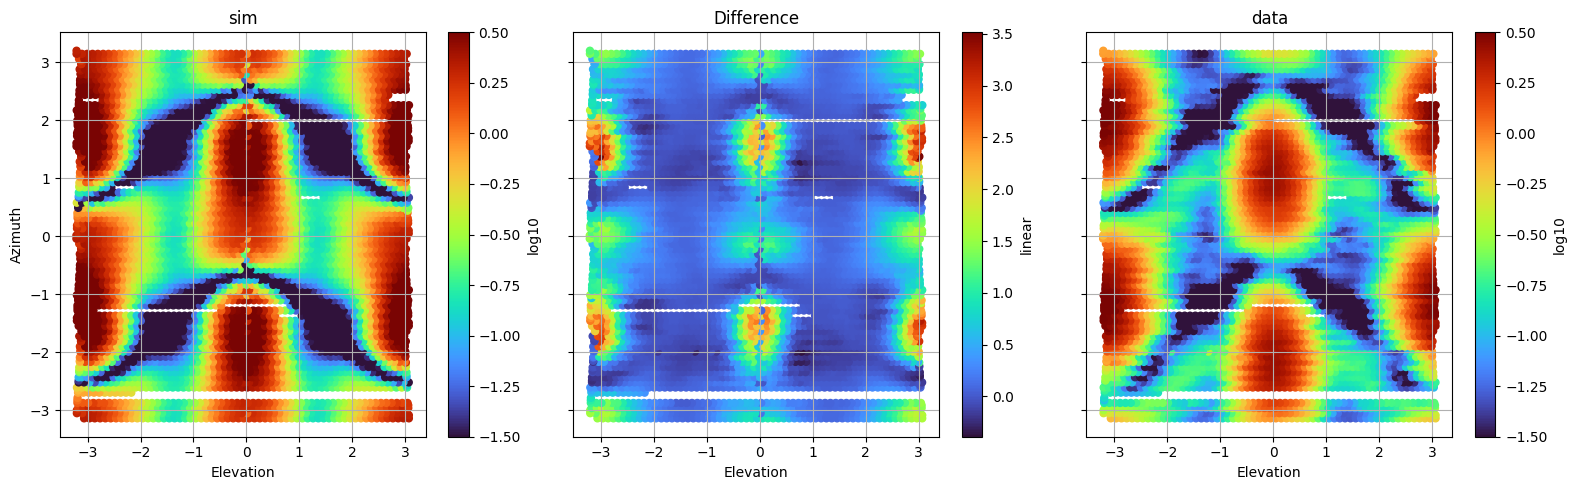

In [14]:
vmin = -1.5
# vmin = -7
# vmax = 1
vmax = .5
rot_norm = rot * norm[:,ch]
# sim_data = P_pred * P_pred_norm
sim_data = sim_p_rot * sim_norm_rot
diff =(sim_data) - (rot_norm)
# diff = np.log10(sim_p_rot) - np.log10(rot)
# diff = sim_data - rot_norm
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

sc1 = axes[0].scatter(el_inds, az_inds, c=jnp.log10(sim_data), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[0].set_title('sim')
axes[0].set_xlabel('Elevation'); axes[0].set_ylabel('Azimuth'); axes[0].grid(True)
fig.colorbar(sc1, ax=axes[0], label='log10')

sc2 = axes[1].scatter(el_inds, az_inds, c=diff, s=25, cmap='turbo')#, vmin=vmin, vmax=vmax)
axes[1].set_title('Difference')
axes[1].set_xlabel('Elevation'); axes[1].grid(True)
fig.colorbar(sc2, ax=axes[1], label='linear')

sc3 = axes[2].scatter(el_inds, az_inds, c=jnp.log10(rot_norm), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[2].set_title('data')
axes[2].set_xlabel('Elevation'); axes[2].grid(True)
fig.colorbar(sc3, ax=axes[2], label='log10')

plt.tight_layout()

In [15]:
# used_pix = hit_pxs
used_pix = unique_hits

In [129]:
# XXX trying stuff
# --- helpers to invert your bounded maps ---
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

# def init_params_from_px(alpha0, delta0, th0, ph0,
#                         L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                         Smin=0.027, Smax=4.25, eps=1e-8):
#     # capacities
#     c_th, c_ph = U_th - L_th, U_ph - L_ph
#     # feasible extra-sum interval
#     u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
#     u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))

#     # target extra-sum and split implied by th0, ph0
#     u0 = th0 + ph0 - (L_th + L_ph)
#     # clip u0 into feasible range
#     u0 = jnp.clip(u0, u_min, u_max)

#     # split s0 from th0 = L_th + u0*s0
#     s0 = jnp.where(u0 > eps, (th0 - L_th) / (u0 + eps), 0.5)

#     # feasible s-interval at this u0 (to honor individual uppers)
#     s_lo0 = jnp.where(u0 > eps, jnp.maximum(0.0, (u0 - c_ph) / (u0 + eps)), 0.0)
#     s_hi0 = jnp.where(u0 > eps, jnp.minimum(1.0,  c_th      / (u0 + eps)), 1.0)
#     s0 = jnp.clip(s0, s_lo0, s_hi0)

#     # map u0, s0 to raw space that your constrain() uses
#     u_unit  = (u0 - u_min) / (u_max - u_min + eps)
#     s_unit  = jnp.where((s_hi0 - s_lo0) > eps, (s0 - s_lo0) / (s_hi0 - s_lo0 + eps), 0.5)
#     u_raw   = inv_sigmoid(u_unit)
#     mix_raw = inv_sigmoid(s_unit)

#     # angles (your model uses sin/cos(alpha); for your synthetic data alpha=0, delta=0)
#     alpha_raw = inv_sigmoid((alpha0 % (2*jnp.pi)) / (2*jnp.pi))
#     delta_raw = inv_sigmoid((delta0 % (2*jnp.pi)) / (2*jnp.pi))

#     return [alpha_raw, delta_raw, u_raw, mix_raw]
# XXX trying stuff
    
def bounded(x, lo, hi):
    return lo + (hi - lo) * jnn.sigmoid(x)

# def constrain(params_raw):
#     alpha_raw, delta_raw, th_raw, ph_raw = params_raw
#     # eps = 1e-6
#     alpha = bounded(alpha_raw, 0, 2*jnp.pi)
#     delta = bounded(delta_raw, 0, 2*jnp.pi)

#     # Nonnegative px arrays (softplus)
#     # th_px = jnn.softplus(th_raw) + eps
#     # ph_px = jnn.softplus(ph_raw) + eps
#     th_px = bounded(th_raw, 0, 4)
#     ph_px = bounded(ph_raw, 0, 4.1)
#     return alpha, delta, th_px, ph_px

def make_bounds_from_maps(th_seed, ph_seed, pad=0.05, eps=1e-8):
    s = th_seed + ph_seed
    L_th = float(max(eps, th_seed.min() * (1 - pad)))
    U_th = float(th_seed.max() * (1 + pad))
    L_ph = float(max(eps, ph_seed.min() * (1 - pad)))
    U_ph = float(ph_seed.max() * (1 + pad))
    Smin = float(max(eps, s.min() * (1 - pad)))
    Smax = float(s.max() * (1 + pad))
    return L_th, U_th, L_ph, U_ph, Smin, Smax

def constrain(params_raw,
              L_th=jnp.min(m_th), U_th=jnp.max(m_th),    # lower/upper bounds for th_px
              L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),    # lower/upper bounds for ph_px
              Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi),    # bounds for per-pixel sum th_px + ph_px
              eps=1e-8):
# def constrain(params_raw,
#                 L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                 Smin=0.027, Smax=4.25, eps=1e-8):
    """
    All bounds can be scalars or arrays broadcastable to (num_hit_pixels,).
    Returns alpha, delta, th_px, ph_px with ALL constraints satisfied.
    """
    alpha_raw, delta_raw, u_raw, mix_raw = params_raw

    # angles (example: radians; change to degrees if your simulator expects them)
    alpha = bounded(alpha_raw, 0.0, 2*jnp.pi)
    delta = bounded(delta_raw, 0.0, 2*jnp.pi)

    # capacities beyond lower bounds
    c_th = U_th - L_th               # >= 0
    c_ph = U_ph - L_ph               # >= 0

    # feasible extra-sum range beyond lower bounds
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    # (If u_max < u_min anywhere, your constraints are inconsistent there.)

    # choose u in [u_min, u_max]
    u = bounded(u_raw, u_min, u_max)

    # for this u, s must live in [s_lo, s_hi] to honor individual uppers:
    #   th = L_th + u*s <= U_th  -> s <= c_th / u
    #   ph = L_ph + u*(1-s) <= U_ph -> s >= 1 - c_ph / u  -> s >= (u - c_ph)/u
    s_lo = jnp.where(u > eps, jnp.maximum(0.0, (u - c_ph) / (u + eps)), 0.0)
    s_hi = jnp.where(u > eps, jnp.minimum(1.0,  c_th      / (u + eps)), 1.0)
    s_rng = jnp.maximum(0.0, s_hi - s_lo)  # 0 if we're exactly capacity-limited

    # pick s inside that feasible interval
    s_unit = jnn.sigmoid(mix_raw)          # in (0,1)
    s = s_lo + s_rng * s_unit              # in [s_lo, s_hi]

    # split u
    th_px = L_th + u * s
    ph_px = L_ph + u * (1.0 - s)
    # Now:  th_px ∈ [L_th, U_th], ph_px ∈ [L_ph, U_ph], and (th_px+ph_px) ∈ [Smin, Smax]
    return alpha, delta, th_px, ph_px

def fit_affine(y, m, eps=1e-8):
    y = y.ravel(); m = m.ravel()
    ym, mm = jnp.mean(y), jnp.mean(m)
    yc, mc = y - ym, m - mm
    a = jnp.vdot(yc, mc) / (jnp.vdot(mc, mc) + eps)
    b = ym - a * mm
    return a.real, b.real

# def loss_fnc(params):
#     m = model(params)
#     a, b = fit_affine(rot, m)
#     resid = rot - (a*m + b)
#     return jnp.mean(resid**2) / (jnp.var(rot) + 1e-12)   # NRMSE^2
# def loss_fnc(params):
#     m = model(params)
#     a, b = fit_affine(sim_p_rot, m)
#     resid = sim_p_rot - (a*m + b)
#     return jnp.mean(resid**2) / (jnp.var(sim_p_rot) + 1e-12)   # NRMSE^2


def model(params):
    alpha, delta, th_px, ph_px = constrain(params)
    
    th_map = jnp.full_like(m_th , healpy.UNSEEN) 
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN)
    th_map = th_map.at[used_pix].set(th_px)
    ph_map = ph_map.at[used_pix].set(ph_px)
    
    txe1 = jnp.sin(alpha)**2
    txe2 = jnp.cos(alpha)**2
    
    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=[0,0,-1])
    sim_p, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=(delta), K=1.0, C0=0.0)
    return sim_p

def loss_fnc(params):
    # alpha, delta, th_px, ph_px = params
    y = model(params)
    norm = 1/jnp.mean(y, axis=None)
    y_norm = y*norm
    return jnp.mean((sim_p_rot*(1/jnp.mean(sim_p_rot, axis=None)) - y_norm)**2)
    # y = model(params)
    # norm = 1/jnp.mean(y, axis=None)
    # y_norm = y*norm
    # return jnp.mean((rot*(1/jnp.mean(rot, axis=None)) - y_norm)**2)
    # return jnp.mean((jnp.log10(rot) - jnp.log10(y))**2)
# XXX adding crazy stuff

# --- init raw params from your current px (same tuple structure everywhere) ---
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

# def init_params_from_px(alpha0, delta0, th0, ph0,
#                         L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                         Smin=0.027, Smax=4.25, eps=1e-8):
def init_params_from_px(alpha0, delta0, th0, ph0,
                        L_th=jnp.min(m_th), U_th=jnp.max(m_th), L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),
                        Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi), eps=1e-8):
    c_th, c_ph = U_th - L_th, U_ph - L_ph
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    u0 = jnp.clip(th0 + ph0 - (L_th + L_ph), u_min, u_max)
    s0 = jnp.where(u0 > eps, (th0 - L_th) / (u0 + eps), 0.5)
    s_lo0 = jnp.where(u0 > eps, jnp.maximum(0.0, (u0 - c_ph)/(u0 + eps)), 0.0)
    s_hi0 = jnp.where(u0 > eps, jnp.minimum(1.0,    c_th/(u0 + eps)), 1.0)
    s0 = jnp.clip(s0, s_lo0, s_hi0)
    u_unit  = (u0 - u_min) / (u_max - u_min + eps)
    s_unit  = jnp.where((s_hi0 - s_lo0) > eps, (s0 - s_lo0)/(s_hi0 - s_lo0 + eps), 0.5)
    u_raw   = inv_sigmoid(u_unit).astype(jnp.float32)
    mix_raw = inv_sigmoid(s_unit).astype(jnp.float32)
    alpha_raw = inv_sigmoid(((alpha0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    delta_raw = inv_sigmoid(((delta0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    return (alpha_raw, delta_raw, u_raw, mix_raw)  # TUPLE, keep it a tuple.

# --- params & one optimizer (multi_transform) ---
# alpha0 = jnp.array(jnp.pi/2, dtype=jnp.float32)
# alpha0 = jnp.array(0.8349674, dtype=jnp.float32)
alpha0 = jnp.array(0.0, dtype=jnp.float32)
delta0 = jnp.array(0.0, dtype=jnp.float32)
# th0 = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
th0 = jnp.zeros_like(used_pix, dtype=jnp.float32) * 3
ph0 = jnp.zeros_like(used_pix, dtype=jnp.float32) * 3

# L_th, U_th, L_ph, U_ph, Smin, Smax = make_bounds_from_maps(m_th, m_phi, pad=0.0)

# init raws from seeds using THESE bounds
# params = init_params_from_px(
#     alpha0=alpha0, delta0=delta0, th0=th0, ph0=ph0,
#     L_th=L_th, U_th=U_th, L_ph=L_ph, U_ph=U_ph, Smin=Smin, Smax=Smax
# )

params = init_params_from_px(alpha0, delta0, th0, ph0)

tx = optax.multi_transform(
    {
      "angles": optax.chain(optax.clip_by_global_norm(0.5), optax.adam(1e-4)),
      "px":     optax.chain(optax.clip_by_global_norm(0.5), optax.adam(1e0)),
    },
    # labels PyTree MUST match params structure:
    param_labels=("angles","angles","px","px"),
)
opt_state = tx.init(params)  # <-- init AFTER defining tx, and only once

# --- px-only step (angles frozen), uses the SAME tx/opt_state ---
@jax.jit
def train_step_px_only(p, s):
    a_raw, d_raw, u_raw, m_raw = p
    def loss_ud(u, m):
        return loss_fnc((a_raw, d_raw, u, m))
    loss, (g_u, g_m) = jax.value_and_grad(loss_ud, argnums=(0,1))(u_raw, m_raw)
    grads = (jnp.zeros_like(a_raw), jnp.zeros_like(d_raw), g_u, g_m)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    # re-pin angles exactly:
    p = (a_raw, d_raw, p[2], p[3])
    return p, s, loss

# --- joint step (same tx) ---
@jax.jit
def train_step_joint(p, s):
    loss, grads = jax.value_and_grad(loss_fnc)(p)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    return p, s, loss

# ---------- run ----------
# (optional) a few px-only warmup steps
for _ in range(2000):
    params, opt_state, loss = train_step_px_only(params, opt_state)
    if _ % 100 ==0:
        print(loss)

# joint fine-tune
# for step in range(1000):
#     params, opt_state, loss = train_step_joint(params, opt_state)
#     if step % 100 == 0:
#         print(f"joint step {step:04d}  loss={float(loss):.6e}")

# alpha, delta, th_px, ph_px = params
# XXX adding crazy stuff


# @jax.jit
# def train_step(params, opt_state):
#     loss, grads = jax.value_and_grad(loss_fnc)(params)
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     params = optax.apply_updates(params, updates)
#     return params, opt_state, loss


# alpha0 = 0.0
# delta0 = 0.0
# th0 = jnp.asarray(m_th[used_pix],  dtype=jnp.float64)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float64)

# params = init_params_from_px(alpha0, delta0, th0, ph0)  # <-- raw params consistent with constrain()
# optimizer = optax.adam(1e-3)  # suggest 1e-3 here; 1e-1 often too hot with sigmoids
# opt_state = optimizer.init(params)



# # learning_rate = 1e-1
# # optimizer = optax.adam(learning_rate)

# # alpha = 0.0
# # delta = 0.0
# # th_px = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# # ph_px = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
# # # th_px = jnp.ones_like(used_pix, dtype=jnp.float32)
# # # ph_px = jnp.ones_like(used_pix, dtype=jnp.float32)
# # params = [alpha, delta, th_px, ph_px]
# # opt_state = optimizer.init(params)

# for epoch in range(10000):
#     params, opt_state, loss = train_step(params, opt_state)
#     if epoch % 1000 == 0:
#         print(f"epoch {epoch:02d}  loss={loss:.6f}")
        

alpha, delta, th_px, ph_px = constrain(params)
print(alpha, delta)

2.573249561918575
0.18221636167316949
0.1618345550479783
0.16331489363416896
0.16190649762999162
0.16052437413784287
0.16000575373919534
0.16630205117099484
0.16427703797942075
0.16751848053047383
0.1673331216271002
0.16344762150885508
0.16313588988601668
0.16294211715422086
0.16281636542269026
0.1629480145740147
0.16281028389799793
0.16311273866116185
0.16221566193432796
0.16229405197705754
6.283184e-06 6.283184e-06


In [455]:
@jax.jit
def step_angles_only(p, s):
    a_raw, d_raw, u_raw, m_raw = p
    def L(a, d): return loss_fnc((a, d, u_raw, m_raw))
    loss, (ga, gd) = jax.value_and_grad(L, argnums=(0,1))(a_raw, d_raw)
    grads = (ga, gd, jnp.zeros_like(u_raw), jnp.zeros_like(m_raw))
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    return p, s, loss
# Pixels-only step you already have (train_step_px_only)
# Joint step you already have (train_step_joint)

# alpha0 = jnp.array(0.8349674, dtype=jnp.float32)
# alpha0 = jnp.array(0.0, dtype=jnp.float32)
alpha0 = jnp.array(jnp.pi/2, dtype=jnp.float32)
delta0 = jnp.array(jnp.pi/6, dtype=jnp.float32)
# th0 = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
th0 = jnp.ones_like(used_pix, dtype=jnp.float32)
ph0 = jnp.ones_like(used_pix, dtype=jnp.float32)

L_th, U_th, L_ph, U_ph, Smin, Smax = make_bounds_from_maps(m_th, m_phi)

# init raws from seeds using THESE bounds
params = init_params_from_px(
    alpha0=alpha0, delta0=delta0, th0=th0, ph0=ph0,
    L_th=L_th, U_th=U_th, L_ph=L_ph, U_ph=U_ph, Smin=Smin, Smax=Smax
)

# params = init_params_from_px(alpha0, delta0, th0, ph0)

tx = optax.multi_transform(
  {
    "angles": optax.chain(optax.clip_by_global_norm(0.5), optax.adam(2e-3)),  # ↑
    "px":     optax.chain(optax.clip_by_global_norm(0.5),
                          optax.adam(8e-4),
                          optax.scale_by_schedule(optax.cosine_decay_schedule(1.0, decay_steps=800))),
  },
  param_labels=("angles","angles","px","px"),
)

opt_state = tx.init(params)  # <-- init AFTER defining tx, and only once
# Schedule per frequency:
for _ in range(50):   # let angles actually move
    params, opt_state, _ = step_angles_only(params, opt_state)
for _ in range(150):  # pixels catch up (your px-only step)
    params, opt_state, _ = train_step_px_only(params, opt_state)
for _ in range(400):  # joint fine-tune
    params, opt_state, _ = train_step_joint(params, opt_state)

alpha, delta, th_px, ph_px = constrain(params)
print(alpha, delta)

KeyboardInterrupt: 

In [414]:
loss, g = jax.value_and_grad(loss_fnc)(params)
print("‖∇alpha‖", float(jnp.linalg.norm(g[0])), "‖∇delta‖", float(jnp.linalg.norm(g[1])))
print("‖∇u_raw‖", float(jnp.linalg.norm(g[2])), "‖∇mix_raw‖", float(jnp.linalg.norm(g[3])))


‖∇alpha‖ 0.07350975275039673 ‖∇delta‖ 0.01014619879424572
‖∇u_raw‖ 0.0015800291439518332 ‖∇mix_raw‖ 0.002537030028179288


In [248]:
import jax, jax.numpy as jnp, jax.nn as jnn
import optax

# ---------- helpers ----------
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

def init_params_from_px(alpha0, delta0, th0, ph0,
                        L_th=1e-8, U_th=4.0,
                        L_ph=1e-9, U_ph=4.1,
                        Smin=0.027, Smax=4.25, eps=1e-8):
    # capacities & feasible u-range
    c_th, c_ph = U_th - L_th, U_ph - L_ph
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))

    u0 = th0 + ph0 - (L_th + L_ph)
    u0 = jnp.clip(u0, u_min, u_max)

    s0 = jnp.where(u0 > eps, (th0 - L_th) / (u0 + eps), 0.5)
    s_lo0 = jnp.where(u0 > eps, jnp.maximum(0.0, (u0 - c_ph)/(u0 + eps)), 0.0)
    s_hi0 = jnp.where(u0 > eps, jnp.minimum(1.0,    c_th/(u0 + eps)), 1.0)
    s0 = jnp.clip(s0, s_lo0, s_hi0)

    u_unit  = (u0 - u_min) / (u_max - u_min + eps)
    s_unit  = jnp.where((s_hi0 - s_lo0) > eps, (s0 - s_lo0)/(s_hi0 - s_lo0 + eps), 0.5)
    u_raw   = inv_sigmoid(u_unit).astype(jnp.float32)
    mix_raw = inv_sigmoid(s_unit).astype(jnp.float32)

    alpha_raw = inv_sigmoid(((alpha0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    delta_raw = inv_sigmoid(((delta0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    # IMPORTANT: return a TUPLE, and keep it a tuple forever
    return (alpha_raw, delta_raw, u_raw, mix_raw)

# ---------- init (use your current maps for a clean synthetic test) ----------
alpha0 = jnp.array(0.0, dtype=jnp.float32)
delta0 = jnp.array(0.0, dtype=jnp.float32)
th0 = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)

params = init_params_from_px(alpha0, delta0, th0, ph0)   # tuple!
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

# ---------- px-only training step (angles frozen), preserving the same PyTree ----------
@jax.jit
def train_step_px_only(params, opt_state):
    alpha_raw_f, delta_raw_f, u_raw, mix_raw = params

    def loss_with_frozen_angles(u_raw_, mix_raw_):
        p = (alpha_raw_f, delta_raw_f, u_raw_, mix_raw_)  # keep angles fixed in-graph
        return loss_fnc(p)

    # get grads w.r.t (u_raw, mix_raw) only
    loss, (g_u, g_m) = jax.value_and_grad(loss_with_frozen_angles, argnums=(0,1))(u_raw, mix_raw)

    # assemble a grads tuple matching params' structure: zeros for angles
    g0 = jnp.zeros_like(alpha_raw_f); g1 = jnp.zeros_like(delta_raw_f)
    grads = (g0, g1, g_u, g_m)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    # keep angles exactly frozen (in case optimizer adds tiny noise)
    params = (alpha_raw_f, delta_raw_f, params[2], params[3])
    return params, opt_state, loss

# ---------- run px-only optimization ----------
for step in range(1000):
    params, opt_state, loss = train_step_px_only(params, opt_state)
    if step % 100 == 0:
        print(f"px-only step {step:04d}  loss={float(loss):.6e}")

# get constrained pixels and compare to your synthetic truth
alpha_c, delta_c, th_hat, ph_hat = constrain(params)
print("th MSE:", float(jnp.mean((th_hat - th0)**2)),
      "ph MSE:", float(jnp.mean((ph_hat - ph0)**2)))


px-only step 0000  loss=3.132061e-10
px-only step 0100  loss=1.587241e-12
px-only step 0200  loss=1.888117e-13
px-only step 0300  loss=1.422311e-13
px-only step 0400  loss=1.516761e-13
px-only step 0500  loss=2.166829e-13
px-only step 0600  loss=2.061246e-13
px-only step 0700  loss=3.276818e-12
px-only step 0800  loss=9.677779e-13
px-only step 0900  loss=5.230506e-13
th MSE: 2.6432578348334346e-10 ph MSE: 6.720930478820719e-10


In [249]:

# group-specific optax
tx = optax.multi_transform(
    {
      "angles": optax.chain(optax.clip_by_global_norm(1.0), optax.adam(3e-4)),
      "px":     optax.chain(optax.clip_by_global_norm(1.0), optax.adam(3e-3)),
    },
    param_labels=("angles","angles","px","px"),  # matches (alpha, delta, u_raw, mix_raw)
)

opt_state = tx.init(params)  # params = tuple from your px-only success

@jax.jit
def train_step_joint(p, s):
    loss, grads = jax.value_and_grad(loss_fnc)(p)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    return p, s, loss

# optional: a few more px-only steps (small number) to stabilize
for _ in range(200):  # you already did 1000; this is just a touch-up
    params, opt_state, _ = train_step_joint(params, opt_state)  # fine if you skip—px are already good

# joint fine-tune
for step in range(1000):
    params, opt_state, loss = train_step_joint(params, opt_state)
    if step % 100 == 0:
        print(f"joint step {step:04d}  loss={float(loss):.6e}")


joint step 0000  loss=1.052107e-13
joint step 0100  loss=8.728632e-14
joint step 0200  loss=9.410802e-14
joint step 0300  loss=1.491335e-13
joint step 0400  loss=1.232313e-13
joint step 0500  loss=2.326523e-13
joint step 0600  loss=1.112922e-12
joint step 0700  loss=2.505823e-10
joint step 0800  loss=6.382329e-11
joint step 0900  loss=1.149144e-10


In [250]:
alpha_c, delta_c, th_hat, ph_hat = constrain(params)
print("alpha(rad)=", float(alpha_c), "delta(rad)=", float(delta_c))
print("px ranges: th[%.3g, %.3g] ph[%.3g, %.3g]" %
      (float(th_hat.min()), float(th_hat.max()),
       float(ph_hat.min()), float(ph_hat.max())))


alpha(rad)= 6.283291895670118e-06 delta(rad)= 6.283184120547958e-06
px ranges: th[2.63e-07, 3.98] ph[2.26e-07, 4.05]


0.23715938602944642


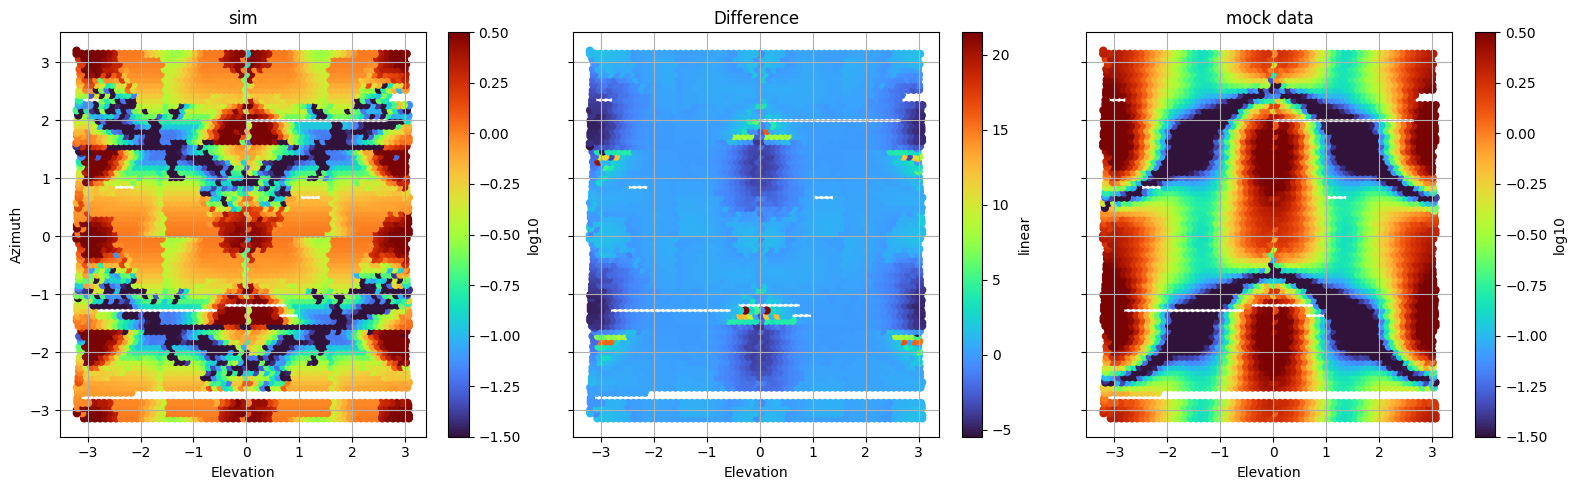

In [184]:
sim_p = model(params)
sim_norm = 1/jnp.mean(sim_p, axis=None)

# data_comp = rot
data_comp = sim_p_rot

vmin = -1.5
# vmin = -7
# vmax = 1
vmax = .5
# data_comp_norm = data_comp * norm[:,ch]
data_comp_norm = data_comp * sim_norm_rot
sim_data = sim_p * sim_norm # - .5+0.08329490672191896
diff = (sim_data) - (data_comp_norm)
print(jnp.median(diff))
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

sc1 = axes[0].scatter(el_inds, az_inds, c=jnp.log10(sim_data), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[0].set_title('sim')
axes[0].set_xlabel('Elevation'); axes[0].set_ylabel('Azimuth'); axes[0].grid(True)
fig.colorbar(sc1, ax=axes[0], label='log10')

sc2 = axes[1].scatter(el_inds, az_inds, c=diff, s=25, cmap='turbo')#, vmin=-0.02, vmax=0.02)#, vmin=vmin, vmax=vmax)
axes[1].set_title('Difference')
axes[1].set_xlabel('Elevation'); axes[1].grid(True)
fig.colorbar(sc2, ax=axes[1], label='linear')

sc3 = axes[2].scatter(el_inds, az_inds, c=jnp.log10(data_comp_norm), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[2].set_title('mock data')
axes[2].set_xlabel('Elevation'); axes[2].grid(True)
fig.colorbar(sc3, ax=axes[2], label='log10')

plt.tight_layout()

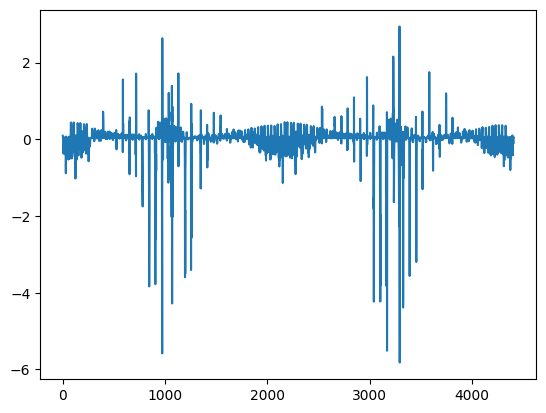

In [131]:
plt.figure()
plt.plot(diff)
plt.show()

-8.881784197001252e-16
0.0007872800796472033


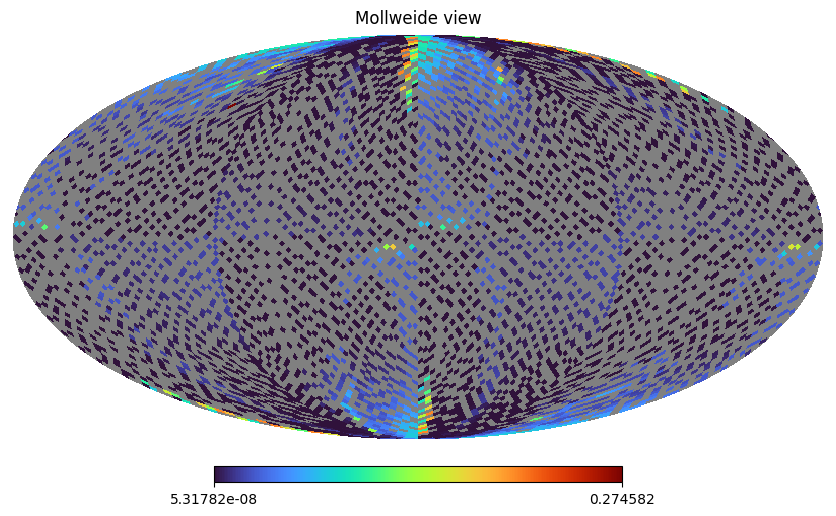

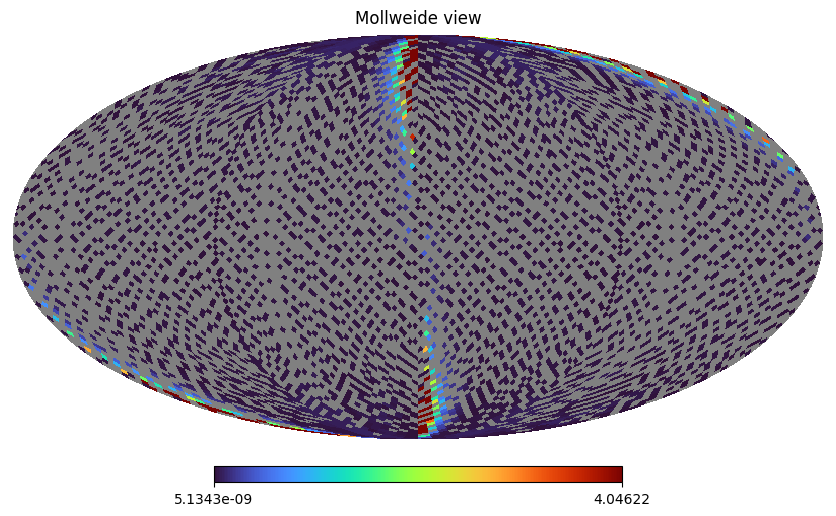

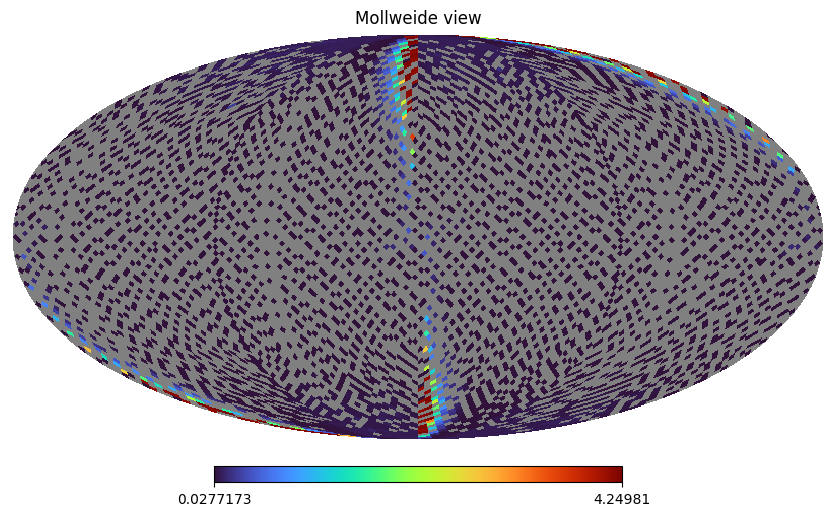

In [132]:
fit_th = jnp.full_like(m_th, healpy.UNSEEN)
fit_ph = jnp.full_like(m_phi, healpy.UNSEEN)
fit_total = jnp.full_like(m_phi, healpy.UNSEEN)
# fit_th = fit_th.at[unique_hits].set(th_px)
# fit_ph = fit_ph.at[unique_hits].set(ph_px)
fit_th = fit_th.at[used_pix].set(th_px)
fit_ph = fit_ph.at[used_pix].set(ph_px)
fit_total = fit_total.at[used_pix].set(fit_ph[used_pix] + fit_th[used_pix])
print(jnp.max(m_th[used_pix] + m_phi[used_pix]) - jnp.max(fit_total[used_pix]))
print(jnp.min(m_th[used_pix] + m_phi[used_pix]) - jnp.min(fit_total[used_pix]))

healpy.mollview(fit_th   , rot=(0, 0, 0), cmap='turbo')
healpy.mollview(fit_ph   , rot=(0, 0, 0), cmap='turbo')
healpy.mollview(fit_total, rot=(0, 0, 0), cmap='turbo')
# healpy.mollview( m_th)
# healpy.mollview(m_phi)

<Figure size 640x480 with 0 Axes>

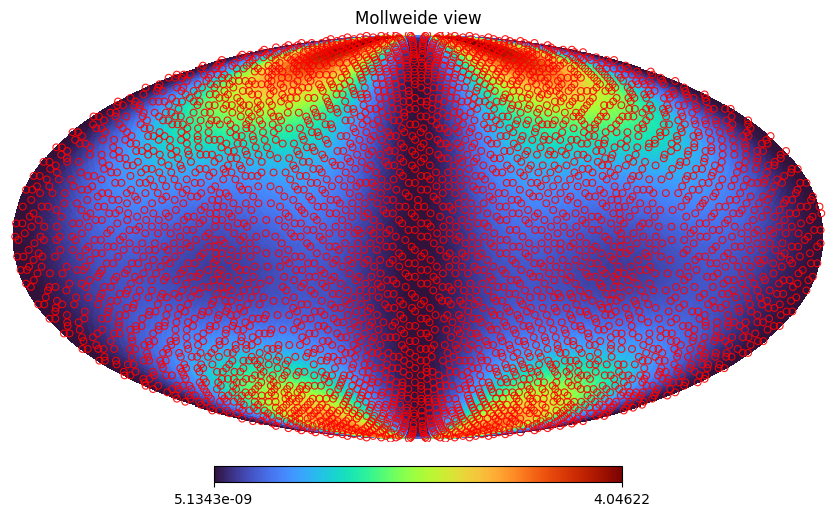

In [173]:
nest = False
plt.figure()
healpy.mollview(m_phi, nest=nest, cmap="turbo")
pix   = np.asarray(used_pix, dtype=np.int64)
upix, counts = np.unique(pix, return_counts=True)
theta, phi   = healpy.pix2ang(DEFAULT_NSIDE, upix, nest=nest)     # radians
# lon          = np.degrees(phi)                        # [0, 360)
# lat          = 90.0 - np.degrees(theta)               # [-90, 90]
lon, lat = healpy.pix2ang(DEFAULT_NSIDE, upix, nest=nest, lonlat=True)

sizes = 24  # e.g., 10 + 40*np.sqrt(counts / counts.max())
healpy.projscatter(
    lon, lat, lonlat=True,
    s=sizes, marker="o",
    facecolors="none", edgecolors="red", linewidths=0.8, alpha=0.9)

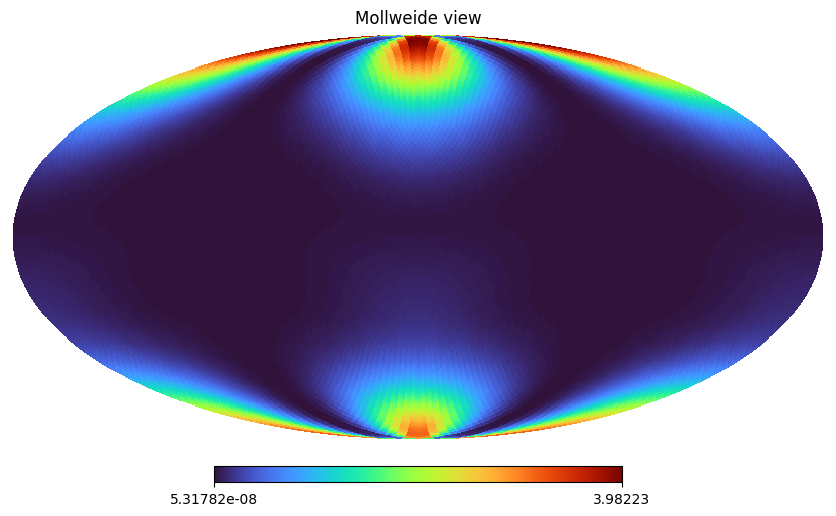

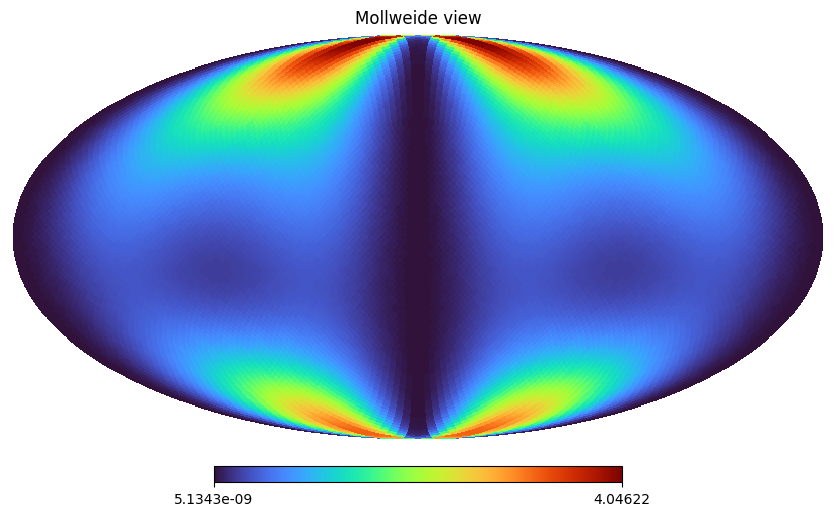

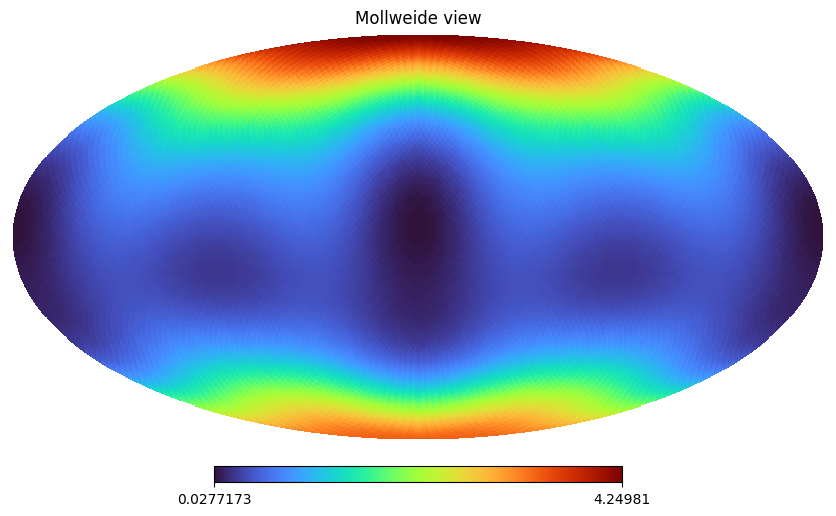

In [22]:

healpy.mollview( m_th, cmap='turbo')
healpy.mollview(m_phi, cmap='turbo')
healpy.mollview(m_phi+m_th, cmap='turbo')

In [16]:
scale_factor = jnp.sum(rot*norm[:, ch] * sim_data) / jnp.sum(sim_data**2)
print(scale_factor)

0.5723165006392869


<Figure size 1000x600 with 0 Axes>

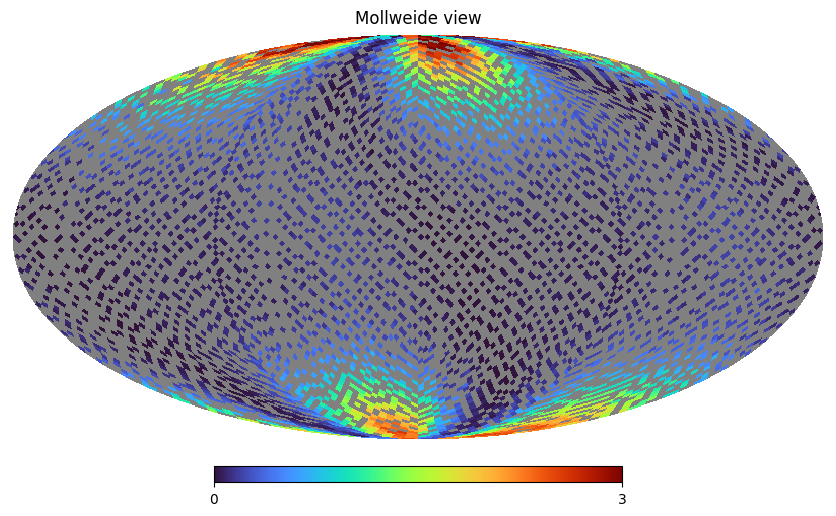

In [16]:
def beam_proj(px, pwr, save=False, freq=False, path=False, data=False, loss=False, vmin=0, vmax=3):
    if save:
        m = jnp.full_like(m_th, healpy.UNSEEN)
        m_dat = jnp.full_like(m_th, healpy.UNSEEN)
        m = m.at[px].set(pwr)
        m_dat = m_dat.at[px].set(data)
        diff = m - m_dat
        plt.ioff()
        fig = plt.figure(figsize=(12, 4))
        healpy.mollview(m, fig=fig.number, sub=(1, 3, 1), title=f"Sim at {freq}",
            cmap="turbo", cbar=True)
        healpy.mollview(diff, fig=fig.number, sub=(1, 3, 2), title=f"Diff at {freq}, loss of {loss}",
            cmap="turbo", cbar=True)
        healpy.mollview(m_dat, fig=fig.number, sub=(1, 3, 3), title=f"Data at {freq}",
            cmap="turbo", cbar=True)
        plt.tight_layout()
        fig.savefig(path + ".png", dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        m = jnp.full_like(m_th, healpy.UNSEEN)
        m = m.at[px].set(pwr)
        plt.figure(figsize=(10, 6))
        healpy.mollview(m, cmap='turbo', min=vmin, max=vmax)
        plt.show()

beam_proj(hit_pxs, rot*norm[:,ch])
# beam_proj(hit_pxs, scale_factor * sim_data)
# beam_proj(hit_pxs, scale_factor * sim_data - rot*norm[:,ch], vmin=None, vmax=None)

In [17]:
def beam_proj(px, pwr, save=False, freq=False, path=False, data=False, loss=False, vmin=0, vmax=3):
    if save:
        m = jnp.full_like(m_th, healpy.UNSEEN)
        m_dat = jnp.full_like(m_th, healpy.UNSEEN)
        m = m.at[px].set(pwr)
        # m = m.at[px].set(jnp.log10(pwr))
        m_dat = m_dat.at[px].set(data)
        # m_dat = m_dat.at[px].set(jnp.log10(data))
        diff = m - m_dat
        plt.ioff()
        fig = plt.figure(figsize=(12, 4))
        healpy.mollview(m, fig=fig.number, sub=(2, 3, 1), title=f"Sim at {freq}",
            cmap="turbo", cbar=True)
        healpy.mollview(diff, fig=fig.number, sub=(2, 3, 2), title=f"Diff at {freq}, loss of {loss}",
            cmap="turbo", cbar=True)
        healpy.mollview(m_dat, fig=fig.number, sub=(2, 3, 3), title=f"Data at {freq}",
            cmap="turbo", cbar=True)
        ax4 = fig.add_subplot(2, 3, 4)
        ax5 = fig.add_subplot(2, 3, 5, sharex=ax4, sharey=ax4)
        ax6 = fig.add_subplot(2, 3, 6, sharex=ax4, sharey=ax4)
        axes = [ax4, ax5, ax6]
        
        sc1 = axes[0].scatter(el_inds, az_inds, c=jnp.log10(pwr), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
        axes[0].set_title('sim')
        axes[0].set_xlabel('Elevation'); axes[0].set_ylabel('Azimuth'); axes[0].grid(True)
        fig.colorbar(sc1, ax=axes[0], label='log10')
        
        sc2 = axes[1].scatter(el_inds, az_inds, c=data-pwr, s=25, cmap='turbo')#, vmin=-1, vmax=1)#, vmin=vmin, vmax=vmax)
        axes[1].set_title('Difference')
        axes[1].set_xlabel('Elevation'); axes[1].grid(True)
        fig.colorbar(sc2, ax=axes[1], label='linear')
        
        sc3 = axes[2].scatter(el_inds, az_inds, c=jnp.log10(data), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
        axes[2].set_title('data')
        axes[2].set_xlabel('Elevation'); axes[2].grid(True)
        fig.colorbar(sc3, ax=axes[2], label='log10')
        plt.subplots_adjust(left=0.06, right=0.985, top=0.95, bottom=0.08, wspace=0.28, hspace=0.38)

        # plt.tight_layout()
        fig.savefig(path + ".png", dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        m = jnp.full_like(m_th, healpy.UNSEEN)
        m = m.at[px].set(pwr)
        plt.figure(figsize=(10, 6))
        healpy.mollview(m, cmap='turbo', min=vmin, max=vmax)
        plt.show()

# beam_proj(hit_pxs, rot*norm[:,ch])
# beam_proj(hit_pxs, scale_factor * sim_data)
# beam_proj(hit_pxs, scale_factor * sim_data - rot*norm[:,ch], vmin=None, vmax=None)

In [18]:
alpha_angle = jnp.linspace(0, 360, 1024, endpoint=False)# * -1

In [73]:
# txe1 = 0.0#.3 # .4
# txe2 = 1.0#.7 # .6 looks close actually, when plotted over time
# txe1 = 0.7#.3 # .4
# txe2 = 0.3#.7 # .6 looks close actually, when plotted over time
# ones_th = jnp.zeros_like(m_th) * 10  
# ones_ph = jnp.zeros_like(m_phi)* 10
# ones_th = ones_th.at[hit_pxs].set(1)
# ones_ph = ones_ph.at[hit_pxs].set(1)
rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_phi)
# rx_true = RotatingAntenna(beam_th=ones_th, beam_phi=ones_ph)
el_correction = -jnp.deg2rad(0.0)
az_correction = jnp.deg2rad(0)

az_inds = np.deg2rad(fitter.az_deg[fitter.inds]) + az_correction#+ np.pi
el_inds = np.deg2rad(fitter.el_deg[fitter.inds]) + el_correction


rx_true._theta_flip_to_data = False   # <- enable the convention used by your (az, el) scatter

coord = jnp.array([-0.0, 0.0, -1])
# tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-30)

# sim_p, hit_pxs = simulate_powers_vmap(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2)
# sim_p, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(180), K=0.2730307444904443, C0=0.5957045841041818)
# sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)
# sim_norm_rot = 1 / np.mean(sim_p_rot, axis=0)

ress = jnp.zeros_like(alpha_angle)

for i,j in enumerate(alpha_angle):
    txe1 = jnp.sin(jnp.deg2rad(j))**2
    txe2 = jnp.cos(jnp.deg2rad(j))**2
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
    sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)
    sim_norm_rot = 1 / jnp.mean(sim_p_rot, axis=0)
    sim_data = sim_p_rot * sim_norm_rot
    scale_factor = jnp.sum(rot*norm[:, ch] * sim_data) / jnp.sum(sim_data**2)
    res = jnp.mean((scale_factor*sim_data - rot*norm[:,ch])**2)
    ress = ress.at[i].add(res)

ress.shape

(1024,)

In [451]:
jnp.where(ress == jnp.amin(ress))
ress[jnp.isclose(ress, jnp.min(ress))][0]

Array(0.26431317, dtype=float64)

0.0


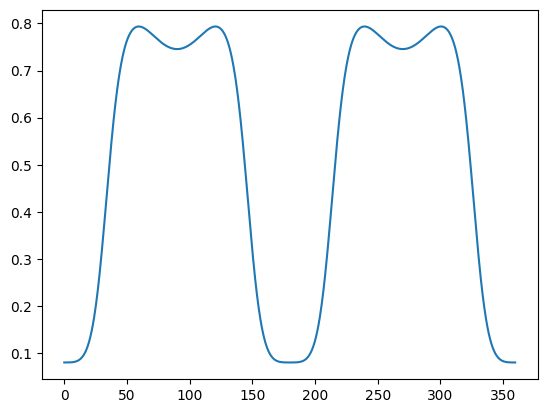

In [20]:
# print(alpha_angle[jnp.argmin(ress)])
print(alpha_angle[jnp.isclose(ress, jnp.min(ress))][0])#jnp.argmin(ress)])
plt.figure()
plt.plot(alpha_angle, ress)
# plt.plot(ress)
# plt.axvline(16.875)
plt.show()

0.0


<Figure size 1000x600 with 0 Axes>

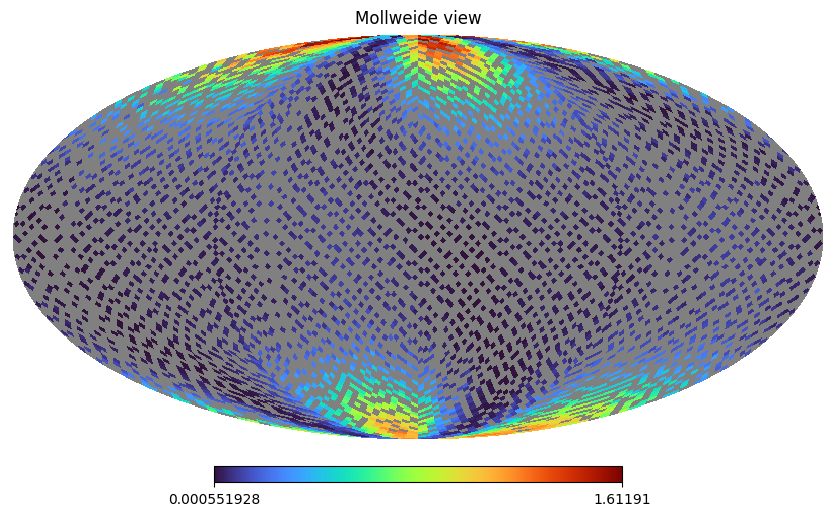

<Figure size 1000x600 with 0 Axes>

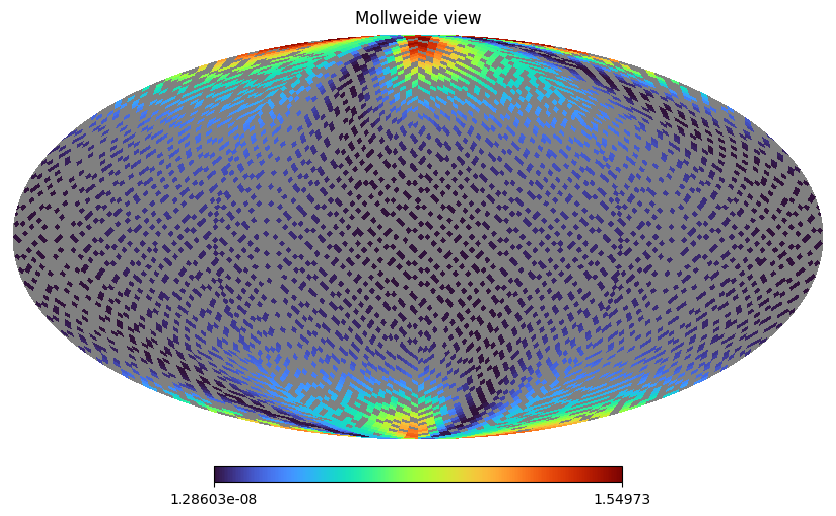

<Figure size 1000x600 with 0 Axes>

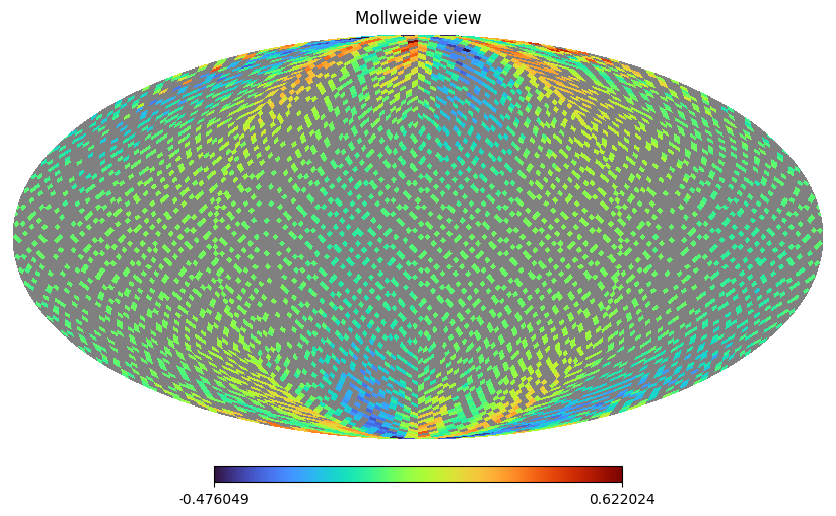

In [75]:
# tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=alpha_angle[jnp.argmin(ress)])
txe1 = jnp.sin(alpha_angle[jnp.argmin(ress)])**2
txe2 = jnp.cos(alpha_angle[jnp.argmin(ress)])**2
tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)

sim_norm_rot = 1 / np.mean(sim_p_rot, axis=0)
sim_data = sim_p_rot * sim_norm_rot
scale_factor = jnp.sum(rot*norm[:, ch] * sim_data) / jnp.sum(sim_data**2)

print(alpha_angle[jnp.argmin(ress)])

beam_proj(hit_pxs, rot*norm[:,ch])
beam_proj(hit_pxs, scale_factor * sim_data)
beam_proj(hit_pxs, scale_factor * sim_data - rot*norm[:,ch], vmin=None, vmax=None)

In [24]:
best_alphas = jnp.zeros(51)
loss_alphas = jnp.zeros_like(best_alphas)
for chan in range(best_alphas.shape[0] - 1):
    ress = jnp.zeros_like(alpha_angle)
    rot = reduced[:, chan+13][sl][val][fitter.inds] #* norm[:, ch]
    m_th = beam_maps_th[chan]
    m_phi = beam_maps_ph[chan]
    rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_phi)
    for i,j in enumerate(alpha_angle):
        txe1 = jnp.sin(jnp.deg2rad(j))**2
        txe2 = jnp.cos(jnp.deg2rad(j))**2
        tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
        sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(0), K=1.0, C0=0.0)
        sim_norm_rot = 1 / jnp.mean(sim_p_rot, axis=0)
        sim_data = sim_p_rot * sim_norm_rot
        scale_factor = jnp.sum(rot*norm[:, chan+13] * sim_data) / jnp.sum(sim_data**2)
        res = jnp.mean((scale_factor*sim_data - rot*norm[:,chan+13])**2)
        ress = ress.at[i].set(res)
    first_angle = alpha_angle[jnp.isclose(ress, jnp.min(ress))][0]
    best_loss = ress[jnp.isclose(ress, jnp.min(ress))][0]
# ress[jnp.isclose(ress, jnp.min(ress))][0]
    best_alphas = best_alphas.at[chan].set(first_angle)
    loss_alphas = loss_alphas.at[chan].set(best_loss)
    print(chan)

best_alphas.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


(51,)

In [20]:
# XXX Goes hard for most channels, but i think i need a more robust version for all channels
EPS = 1e-12
best_alphas = jnp.zeros(51)

def make_grid_deg(lo, hi, step):
    lo, hi, step = float(lo), float(hi), float(step)
    if step <= 0: raise ValueError("step must be > 0")
    if hi < lo: return jnp.array([lo], dtype=jnp.float32)
    n = int(jnp.floor((hi - lo) / step)) + 1
    n = max(1, n)
    return jnp.linspace(lo, lo + step*(n-1), n, dtype=jnp.float32)

def alpha_to_E(alpha_rad, square=True):
    s, c = jnp.sin(alpha_rad), jnp.cos(alpha_rad)
    return (s*s, c*c) if square else (s, c)

def loss_scale_factor_exact(sim, y, axis=0):
    sim_n = sim * (1.0 / (jnp.mean(sim, axis=axis) + EPS))
    s = jnp.sum(y * sim_n) / (jnp.sum(sim_n**2) + EPS)
    r = y - s * sim_n
    return jnp.mean(r*r)

def pick_first_min_1d(grid_deg, losses, rel_tol=1e-4):
    Lmin = jnp.min(losses)
    thresh = Lmin * (1.0 + rel_tol)
    idxs = jnp.arange(losses.shape[0])
    big  = losses.shape[0] + 1
    masked = jnp.where(losses <= thresh, idxs, big)
    i = jnp.argmin(masked)
    return grid_deg[i], losses[i]
def sim_loss_alpha(alpha_deg, fixed_delta_deg, rx_true, az_inds, el_inds, y,
                   tx_orient_deg=-32.0, heading_top=jnp.array([0,0,-1], dtype=jnp.float32)):
    a_rad = jnp.deg2rad(alpha_deg)
    d_rad = jnp.deg2rad(fixed_delta_deg)
    E1, E2 = alpha_to_E(a_rad, square=True)
    tx_true = TransmitterAntenna(E1=E1, E2=E2, heading_top=heading_top, alpha=tx_orient_deg)  # <-- IMPORTANT
    sim, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true,
                                        az=az_inds, el=el_inds,
                                        E1=E1, E2=E2, delta_rx=d_rad, K=1.0, C0=0.0)
    return loss_scale_factor_exact(sim, y, axis=0)

def sim_loss_delta(delta_deg, fixed_alpha_deg, rx_true, az_inds, el_inds, y,
                   tx_orient_deg=-32.0, heading_top=jnp.array([0,0,-1], dtype=jnp.float32)):
    a_rad = jnp.deg2rad(fixed_alpha_deg)
    d_rad = jnp.deg2rad(delta_deg)
    E1, E2 = alpha_to_E(a_rad, square=True)
    tx_true = TransmitterAntenna(E1=E1, E2=E2, heading_top=heading_top, alpha=tx_orient_deg)  # <-- IMPORTANT
    sim, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true,
                                        az=az_inds, el=el_inds,
                                        E1=E1, E2=E2, delta_rx=d_rad, K=1.0, C0=0.0)
    return loss_scale_factor_exact(sim, y, axis=0)
def sim_loss_alpha(alpha_deg, fixed_delta_deg, rx_true, az_inds, el_inds, y,
                   tx_orient_deg=-32.0, heading_top=jnp.array([0,0,-1], dtype=jnp.float32)):
    a_rad = jnp.deg2rad(alpha_deg)
    d_rad = jnp.deg2rad(fixed_delta_deg)
    E1, E2 = alpha_to_E(a_rad, square=True)
    tx_true = TransmitterAntenna(E1=E1, E2=E2, heading_top=heading_top, alpha=tx_orient_deg)  # <-- IMPORTANT
    sim, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true,
                                        az=az_inds, el=el_inds,
                                        E1=E1, E2=E2, delta_rx=d_rad, K=1.0, C0=0.0)
    return loss_scale_factor_exact(sim, y, axis=0)

def sim_loss_delta(delta_deg, fixed_alpha_deg, rx_true, az_inds, el_inds, y,
                   tx_orient_deg=-32.0, heading_top=jnp.array([0,0,-1], dtype=jnp.float32)):
    a_rad = jnp.deg2rad(fixed_alpha_deg)
    d_rad = jnp.deg2rad(delta_deg)
    E1, E2 = alpha_to_E(a_rad, square=True)
    tx_true = TransmitterAntenna(E1=E1, E2=E2, heading_top=heading_top, alpha=tx_orient_deg)  # <-- IMPORTANT
    sim, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true,
                                        az=az_inds, el=el_inds,
                                        E1=E1, E2=E2, delta_rx=d_rad, K=1.0, C0=0.0)
    return loss_scale_factor_exact(sim, y, axis=0)
def search_alpha_1d(rx_true, az_inds, el_inds, y,
                    alpha_range=(0,180),  # 180° period with sin^2/cos^2; use (0,360) if you prefer
                    coarse_step=6, fine_half_window=6, fine_step=1,
                    fixed_delta_deg=0.0, rel_tol=1e-4,
                    tx_orient_deg=-32.0, heading_top=jnp.array([0,0,-1], dtype=jnp.float32)):
    Acoarse = make_grid_deg(alpha_range[0], alpha_range[1], coarse_step)
    vm = jax.vmap(lambda a: sim_loss_alpha(a, fixed_delta_deg, rx_true, az_inds, el_inds, y,
                                           tx_orient_deg, heading_top))
    Lc = vm(Acoarse)
    a_c, _ = pick_first_min_1d(Acoarse, Lc, rel_tol=rel_tol)

    Afine = make_grid_deg(max(alpha_range[0], a_c - fine_half_window),
                          min(alpha_range[1], a_c + fine_half_window), fine_step)
    Lf = vm(Afine)
    a_f, Lbest = pick_first_min_1d(Afine, Lf, rel_tol=rel_tol)
    return a_f, Lbest

def search_delta_1d(rx_true, az_inds, el_inds, y,
                    delta_range=(0,360),
                    coarse_step=12, fine_half_window=6, fine_step=1,
                    fixed_alpha_deg=0.0, rel_tol=1e-4,
                    tx_orient_deg=-32.0, heading_top=jnp.array([0,0,-1], dtype=jnp.float32)):
    Dcoarse = make_grid_deg(delta_range[0], delta_range[1], coarse_step)
    vm = jax.vmap(lambda d: sim_loss_delta(d, fixed_alpha_deg, rx_true, az_inds, el_inds, y,
                                           tx_orient_deg, heading_top))
    Lc = vm(Dcoarse)
    d_c, _ = pick_first_min_1d(Dcoarse, Lc, rel_tol=rel_tol)

    Dfine = make_grid_deg(max(delta_range[0], d_c - fine_half_window),
                          min(delta_range[1], d_c + fine_half_window), fine_step)
    Lf = vm(Dfine)
    d_f, Lbest = pick_first_min_1d(Dfine, Lf, rel_tol=rel_tol)
    return d_f, Lbest
# preallocated outputs you already had
num_ch = best_alphas.shape[0] - 1  # keep the -1 if you intend to skip last channel

best_alphas = jnp.zeros(best_alphas.shape[0], dtype=jnp.float32)
best_deltas = jnp.zeros_like(best_alphas)
best_losses = jnp.zeros_like(best_alphas)

coord = jnp.array([0.0, 0.0, -1.0], dtype=jnp.float32)  # your heading_top
tx_orient_deg = -32.0  # the physical orientation you mentioned

for ch in range(num_ch):
    y = reduced[:, ch+13][sl][val][fitter.inds] * norm[:, ch+13]

    m_th = beam_maps_th[ch]
    m_ph = beam_maps_ph[ch]
    rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_ph)

    # alpha first
    a_deg, _ = search_alpha_1d(rx_true, az_inds, el_inds, y,
                               alpha_range=(0,180),   # or (0,360) if you really want full range
                               coarse_step=6, fine_half_window=6, fine_step=1,
                               fixed_delta_deg=0.0, rel_tol=1e-4,
                               tx_orient_deg=tx_orient_deg, heading_top=coord)

    # delta given alpha
    d_deg, L = search_delta_1d(rx_true, az_inds, el_inds, y,
                               delta_range=(0,360),
                               coarse_step=12, fine_half_window=6, fine_step=1,
                               fixed_alpha_deg=a_deg, rel_tol=1e-4,
                               tx_orient_deg=tx_orient_deg, heading_top=coord)

    best_alphas = best_alphas.at[ch].set(a_deg)
    best_deltas = best_deltas.at[ch].set(d_deg)
    best_losses = best_losses.at[ch].set(L)


In [20]:
EPS = 1e-12
best_alphas = jnp.zeros(51)

def make_grid_deg(lo, hi, step):
    lo, hi, step = float(lo), float(hi), float(step)
    if step <= 0: raise ValueError("step must be > 0")
    if hi < lo: return jnp.array([lo], dtype=jnp.float32)
    n = int(jnp.floor((hi - lo) / step)) + 1
    n = max(1, n)
    return jnp.linspace(lo, lo + step*(n-1), n, dtype=jnp.float32)

def alpha_to_E(alpha_rad, square=True):
    s, c = jnp.sin(alpha_rad), jnp.cos(alpha_rad)
    return (s*s, c*c) if square else (s, c)

def loss_scale_factor_exact(sim, y, axis=0):
    # sim_n = sim / mean(sim, axis=axis)
    sim_n = sim * (1.0 / (jnp.mean(sim, axis=axis) + EPS))
    s = jnp.sum(y * sim_n) / (jnp.sum(sim_n**2) + EPS)
    r = y - s * sim_n
    return jnp.mean(r*r)

def pick_first_min_lex(alpha_deg, delta_deg, losses, rel_tol=1e-4):
    """
    Among all entries with loss <= min*(1+rel_tol), pick the earliest in α (0→360),
    breaking ties by δ (0→360).
    """
    Na, Nd = losses.shape
    minL = jnp.min(losses)
    thresh = minL * (1.0 + rel_tol)
    mask = losses <= thresh

    ai = jnp.arange(Na); di = jnp.arange(Nd)
    AI, DI = jnp.meshgrid(ai, di, indexing="ij")
    key = AI * (Nd + 1) + DI
    big = (Na + 1) * (Nd + 1)
    key_masked = jnp.where(mask, key, big)

    flat_idx = jnp.argmin(key_masked.ravel())
    a_i = flat_idx // Nd
    d_i = flat_idx % Nd
    return alpha_deg[a_i], delta_deg[d_i], losses[a_i, d_i]
def sim_loss_pair(alpha_deg, delta_deg, rx_true, az_inds, el_inds, y,
                  tx_orient_deg=-32.0,
                  heading_top=jnp.array([0,0,-1], dtype=jnp.float32)):
    a_rad = jnp.deg2rad(alpha_deg)
    d_rad = jnp.deg2rad(delta_deg)
    E1, E2 = alpha_to_E(a_rad, square=True)

    tx_true = TransmitterAntenna(E1=E1, E2=E2, heading_top=heading_top, alpha=tx_orient_deg)
    sim, _ = simulate_powers_vmap_phase(
        rx=rx_true, tx=tx_true, az=az_inds, el=el_inds,
        E1=E1, E2=E2, delta_rx=d_rad, K=1.0, C0=0.0
    )
    return loss_scale_factor_exact(sim, y, axis=0)
def search_alpha_delta_coarse_to_fine(rx_true, az_inds, el_inds, y,
                                      alpha_range=(0, 180),   # use (0,360) if you prefer
                                      delta_range=(0, 360),
                                      coarse_a_step=6, coarse_d_step=12,
                                      fine_half_window=6, fine_step=1,
                                      rel_tol=1e-4,
                                      tx_orient_deg=-32.0,
                                      heading_top=jnp.array([0,0,-1], dtype=jnp.float32)):
    # --- coarse grid ---
    alpha_c = make_grid_deg(alpha_range[0], alpha_range[1], coarse_a_step)
    delta_c = make_grid_deg(delta_range[0], delta_range[1], coarse_d_step)

    # losses over [Na, Nd] via nested vmap
    Lc = jax.vmap(
            lambda a: jax.vmap(
                lambda d: sim_loss_pair(a, d, rx_true, az_inds, el_inds, y,
                                        tx_orient_deg, heading_top)
            )(delta_c)
        )(alpha_c)  # shape [Na, Nd]

    a_c, d_c, _ = pick_first_min_lex(alpha_c, delta_c, Lc, rel_tol=rel_tol)

    # --- fine grid around the coarse best ---
    a_lo = max(alpha_range[0], a_c - fine_half_window)
    a_hi = min(alpha_range[1], a_c + fine_half_window)
    d_lo = max(delta_range[0], d_c - fine_half_window)
    d_hi = min(delta_range[1], d_c + fine_half_window)

    alpha_f = make_grid_deg(a_lo, a_hi, fine_step)
    delta_f = make_grid_deg(d_lo, d_hi, fine_step)

    Lf = jax.vmap(
            lambda a: jax.vmap(
                lambda d: sim_loss_pair(a, d, rx_true, az_inds, el_inds, y,
                                        tx_orient_deg, heading_top)
            )(delta_f)
        )(alpha_f)  # shape [Naf, Ndf]

    a_f, d_f, Lbest = pick_first_min_lex(alpha_f, delta_f, Lf, rel_tol=rel_tol)
    return a_f, d_f, Lbest
num_ch = best_alphas.shape[0] - 1  # keep the -1 if you intentionally skip the last channel
best_alphas = jnp.zeros(best_alphas.shape[0], dtype=jnp.float32)
best_deltas = jnp.zeros_like(best_alphas)
best_losses = jnp.zeros_like(best_alphas)

coord = jnp.array([0.0, 0.0, -1.0], dtype=jnp.float32)
tx_orient_deg = -32.0

for ch in range(num_ch):
    y = reduced[:, ch+13][sl][val][fitter.inds] * norm[:, ch+13]

    m_th = beam_maps_th[ch]
    m_ph = beam_maps_ph[ch]
    rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_ph)

    a_deg, d_deg, L = search_alpha_delta_coarse_to_fine(
        rx_true, az_inds, el_inds, y,
        alpha_range=(0, 180),       # or (0, 360) if you prefer; tie-break still applies
        delta_range=(0, 360),
        coarse_a_step=6, coarse_d_step=6,
        fine_half_window=6, fine_step=1,
        rel_tol=1e-4,
        tx_orient_deg=tx_orient_deg,
        heading_top=coord
    )

    best_alphas = best_alphas.at[ch].set(a_deg)
    best_deltas = best_deltas.at[ch].set(d_deg)
    best_losses = best_losses.at[ch].set(L)


In [20]:
beam_maps_th.shape[0], chs.shape, best_alphas.shape

(52, (63,), (51,))

In [278]:
# reduced[:, 63]
freqs[chs].shape

(63,)

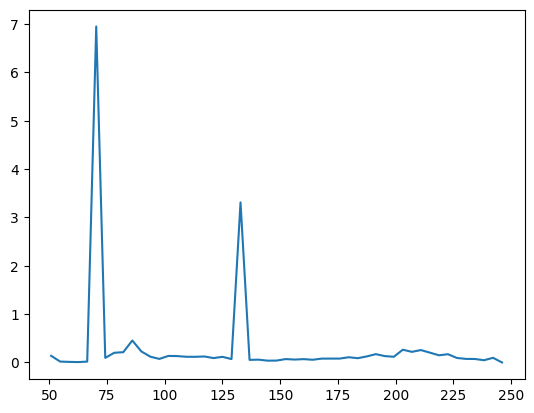

In [21]:
plt.figure()
# plt.plot(freqs[::16][13:], best_alphas)
# plt.plot(freqs[::16][13:], best_deltas)
plt.plot(freqs[::16][13:], best_losses)
# plt.plot(freqs[::16][13:], best_alphas)
# plt.plot(freqs[::16][13:], loss_alphas*10)
# plt.plot(best_alphas)
# plt.axhline(25)
# plt.ylim(0, .5)
plt.show()

175.78125 0.0 0.0 0.080266066


<Figure size 1000x600 with 0 Axes>

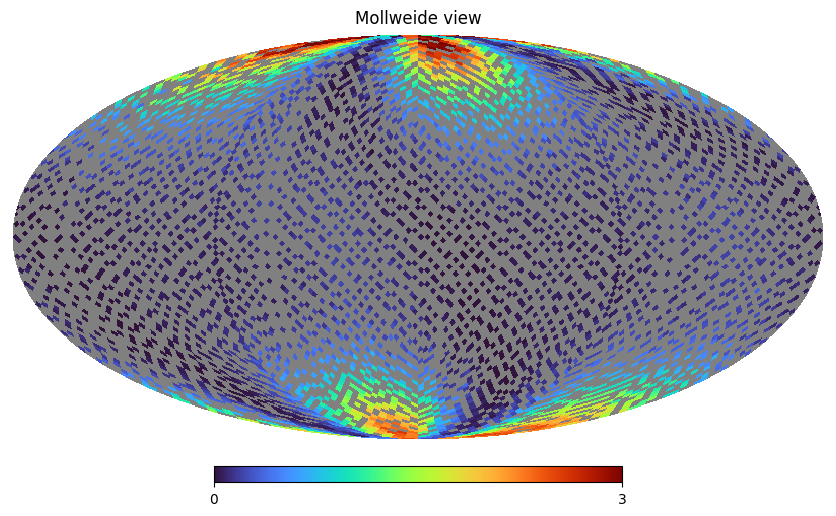

<Figure size 1000x600 with 0 Axes>

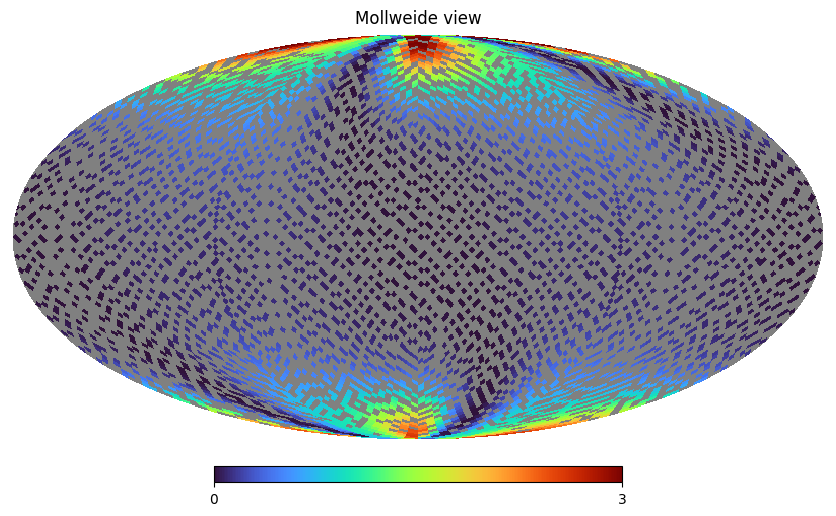

In [21]:
test_ch = 44 # 18 is weird, has a loss of about 7, but has all 0 almost everywhere # 34 has the same issue with loss=3, something horrible happened at these channels
rot = reduced[:, test_ch][sl][val][fitter.inds] #* norm[:, ch]
m_th = beam_maps_th[test_ch-13]
m_phi = beam_maps_ph[test_ch-13]
rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_phi)

test_alpha = best_alphas[test_ch-13] + 0
test_delta = best_deltas[test_ch-13] + 0
# tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=alpha_angle[jnp.argmin(ress)])
# txe1 = jnp.sin(jnp.deg2rad(best_alphas[test_ch-13]))**2
# txe2 = jnp.cos(jnp.deg2rad(best_alphas[test_ch-13]))**2
txe1 = jnp.sin(jnp.deg2rad(test_alpha))**2
txe2 = jnp.cos(jnp.deg2rad(test_alpha))**2
coord = [0,0,-1]

tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
# sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(70), K=1.0, C0=0.0)
sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0)

test_data = rot * norm[:, test_ch]

sim_norm_rot = 1 / jnp.mean(sim_p_rot, axis=0)
sim_data = sim_p_rot * sim_norm_rot
scale_factor = jnp.sum(test_data * sim_data) / jnp.sum(sim_data**2)
# test_data = sim_data * scale_factor
# print(freqs[chs][test_ch], best_alphas[test_ch-13])
print(freqs[chs][test_ch], test_alpha, test_delta, best_losses[test_ch-13])
beam_proj(hit_pxs, rot*norm[:,test_ch])
beam_proj(hit_pxs, scale_factor * sim_data)
# beam_proj(hit_pxs, (scale_factor * sim_data) - (rot*norm[:,test_ch]), vmin=None, vmax=None)

In [83]:
### code to make the images
for i in range(13, chs.shape[0]):
    rot = reduced[:, i][sl][val][fitter.inds] #* norm[:, ch]
    m_th = beam_maps_th[i-13]
    m_phi = beam_maps_ph[i-13]
    rx_true = RotatingAntenna(beam_th=m_th, beam_phi=m_phi)
    
    test_alpha = best_alphas[i-13] + 0
    test_delta = best_deltas[i-13] + 0
    # tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=alpha_angle[jnp.argmin(ress)])
    # txe1 = jnp.sin(jnp.deg2rad(best_alphas[i-13]))**2
    # txe2 = jnp.cos(jnp.deg2rad(best_alphas[i-13]))**2
    txe1 = jnp.sin(jnp.deg2rad(test_alpha))**2
    txe2 = jnp.cos(jnp.deg2rad(test_alpha))**2
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
    # sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(70), K=1.0, C0=0.0)
    sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0)
    
    sim_norm_rot = 1 / jnp.mean(sim_p_rot, axis=0)
    sim_data = sim_p_rot * sim_norm_rot
    data = rot*norm[:,i]
    scale_factor = jnp.sum(data * sim_data) / jnp.sum(sim_data**2)
    freq_num = freqs[chs][i]
    y = scale_factor*sim_data
    loss_calc = jnp.mean((data-y)**2)
    beam_proj(hit_pxs, y, data=data, save=True, path=f'moll_proj/maps_at_{freq_num}', freq=freq_num, loss=loss_calc, vmin=-1.5, vmax=.5)
print('done')
    
# beam_proj()
# beam_proj(hit_pxs, scale_factor * sim_data, data=rot*norm[:,ch], save=True, path='moll_proj/test', freq=freqs[chs][i], vmin=None, vmax=None)
# beam_proj(hit_pxs, scale_factor * sim_data - rot*norm[:,ch], vmin=None, vmax=None)

done


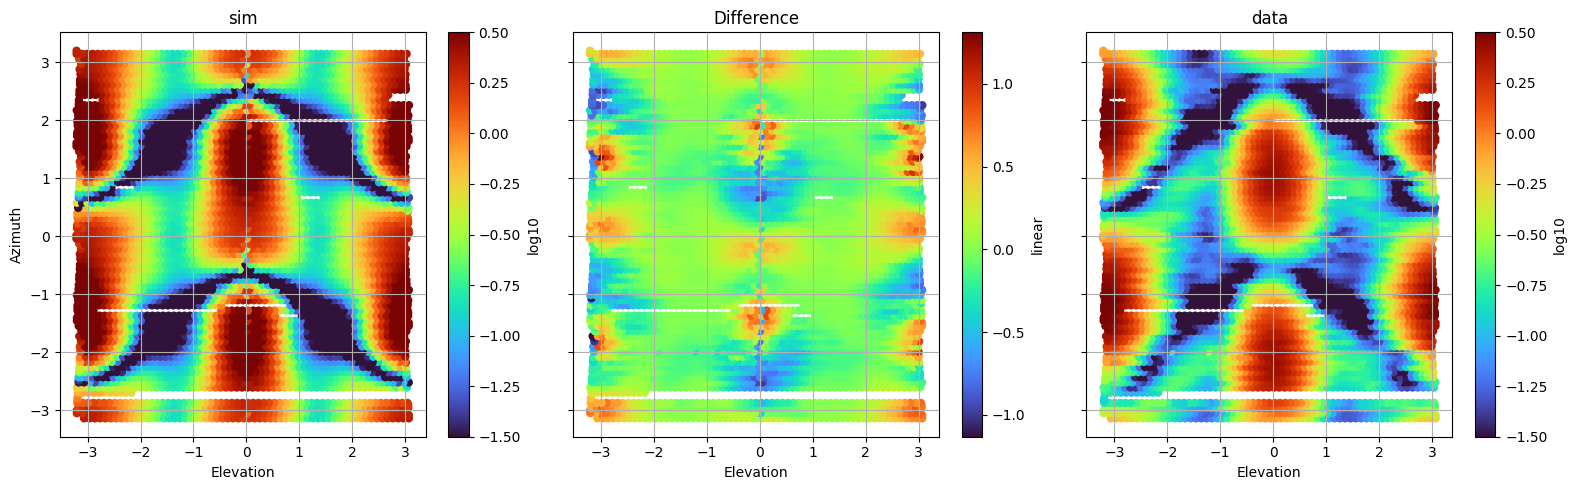

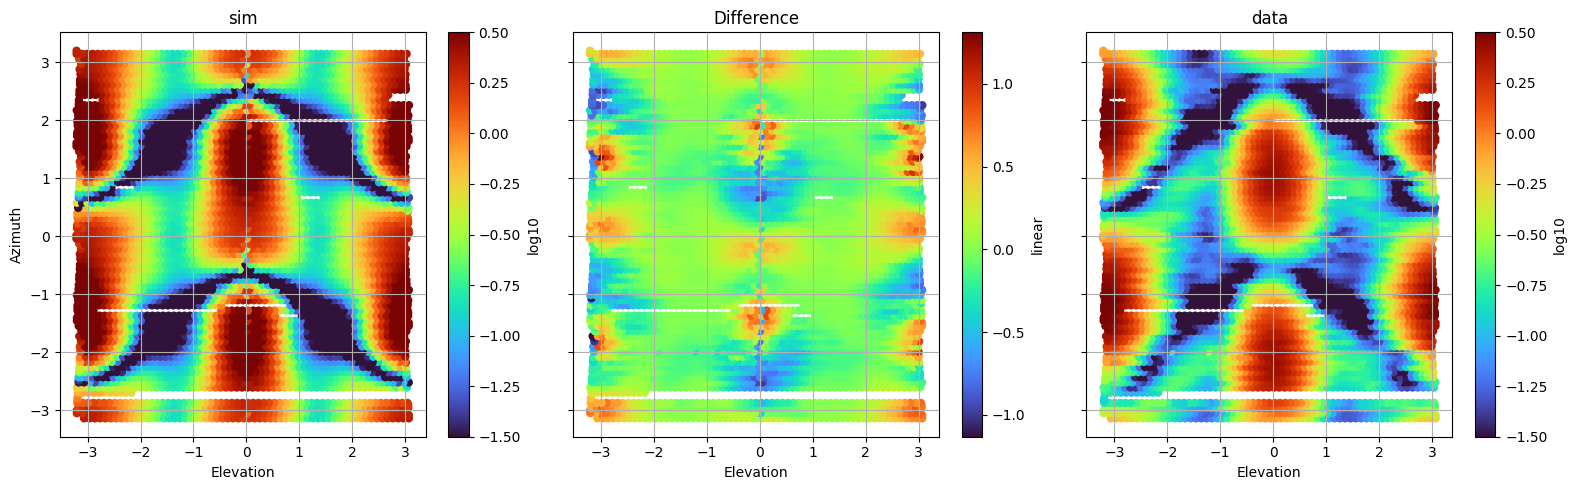

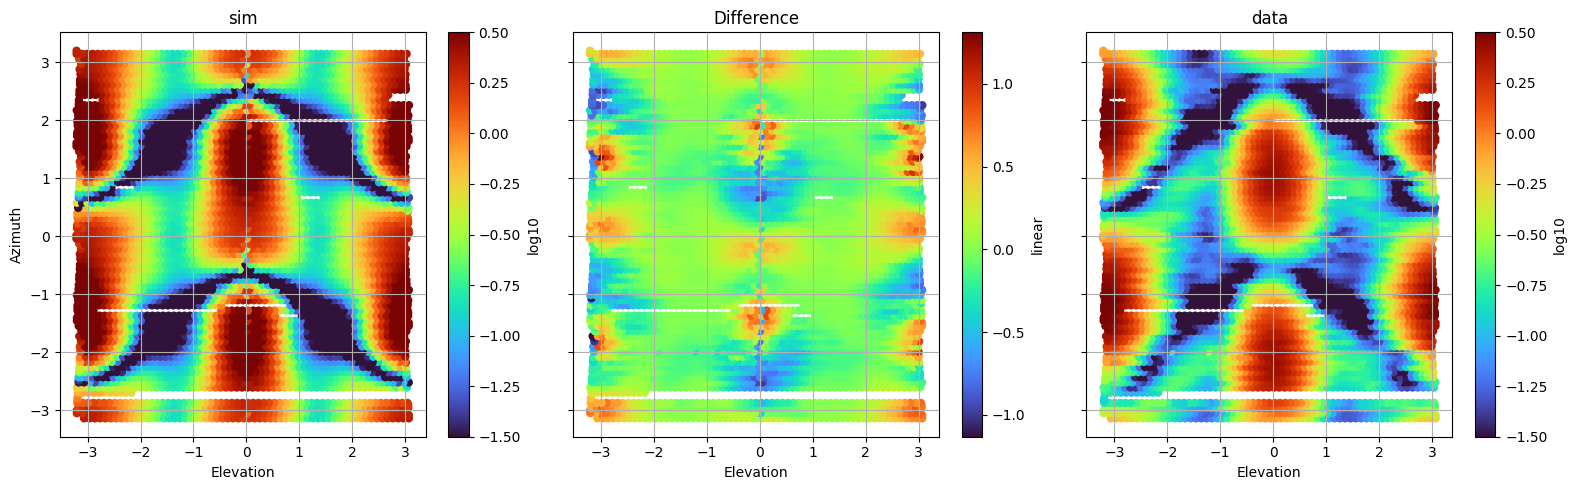

In [81]:

vmin = -1.5
# vmin = -7
# vmax = 1
vmax = .5
rot_norm = rot * norm[:,test_ch]
# sim_data = P_pred * P_pred_norm
# sim_data = sim_p_rot * sim_norm_rot
diff =(sim_data*scale_factor) - (rot_norm)
# diff = np.log10(sim_p_rot) - np.log10(rot)
# diff = sim_data - rot_norm
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

sc1 = axes[0].scatter(el_inds, az_inds, c=jnp.log10(sim_data), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[0].set_title('sim')
axes[0].set_xlabel('Elevation'); axes[0].set_ylabel('Azimuth'); axes[0].grid(True)
fig.colorbar(sc1, ax=axes[0], label='log10')

sc2 = axes[1].scatter(el_inds, az_inds, c=diff, s=25, cmap='turbo')#, vmin=-1, vmax=1)#, vmin=vmin, vmax=vmax)
axes[1].set_title('Difference')
axes[1].set_xlabel('Elevation'); axes[1].grid(True)
fig.colorbar(sc2, ax=axes[1], label='linear')

sc3 = axes[2].scatter(el_inds, az_inds, c=jnp.log10(rot_norm), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[2].set_title('data')
axes[2].set_xlabel('Elevation'); axes[2].grid(True)
fig.colorbar(sc3, ax=axes[2], label='log10')

plt.tight_layout()
plt.show()

In [171]:
# XXX Goes hard!

CAP = 4.3

def constrain(params, cap=CAP):
    th, ph = params
    t = jax.nn.softplus(th)
    p = jax.nn.softplus(ph)
    s = t + p
    scale = jnp.minimum(1.0, cap / (s + 1e-12))
    ts = t*scale
    ps = p*scale
    return (ts, ps)
    # return jax.tree_util.tree_map(jax.nn.softplus, params)
    # return jax.nn.softplus(params)

def smooth_penalty(x, nbr_idx, nbr_mask):
    """
    x: (N,) values on used_pix
    nbr_idx: (N, K) neighbor indices into x, with -1 where absent
    nbr_mask: (N, K) boolean, True where neighbor is valid
    """
    N, K = nbr_idx.shape
    # Gather neighbor values; for invalid neighbors, just reuse x_i so diff=0 after masking
    safe_idx = jnp.where(nbr_mask, nbr_idx, jnp.zeros_like(nbr_idx))
    x_nbr = x[safe_idx]                                   # (N, K)
    x_i = x[:, None]                                      # (N, 1)

    diffsq = (x_i - x_nbr) ** 2                           # (N, K)
    diffsq = jnp.where(nbr_mask, diffsq, 0.0)
    # Normalize by number of valid edges to keep scale stable
    denom = jnp.maximum(jnp.sum(nbr_mask, axis=1, keepdims=True), 1)
    per_node = jnp.sum(diffsq, axis=1) / denom.squeeze(-1)
    return jnp.mean(per_node)


def model(params):
    # th_px, ph_px = constrain(params)
    th_px, ph_px = params
    
    th_map = jnp.full_like(m_th , healpy.UNSEEN) 
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN)
    th_map = th_map.at[used_pix].set(th_px)
    ph_map = ph_map.at[used_pix].set(ph_px)
    test_alpha = best_alphas[test_ch-13] + 0
    test_delta = best_deltas[test_ch-13] + 0
    
    txe1 = jnp.sin(jnp.deg2rad(test_alpha))**2
    txe2 = jnp.cos(jnp.deg2rad(test_alpha))**2
    
    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
    sim_p, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0)
    return sim_p

def loss_fnc(params):
    # alpha, delta, th_px, ph_px = params
    y = model(params)
    norm = 1/jnp.mean(y, axis=None)
    y_norm = y*norm
    test_data = sim_data
    scale = jnp.sum(test_data * y_norm) / jnp.sum(y_norm**2)
    # data = rot * norm[:,test_ch]
    # data = rot * norm[:, test_ch]
    loss_val = jnp.mean((test_data - y_norm*scale)**2)
    # th_pos, ph_pos = constrain(params)     # reuse your constrain()
    th_pos, ph_pos = params

    th_smooth = smooth_penalty(th_pos, nbr_idx, nbr_mask)
    ph_smooth = smooth_penalty(ph_pos, nbr_idx, nbr_mask)

    return loss_val + LAMBDA_TH*th_smooth + LAMBDA_PH*ph_smooth
    # return loss_val
    
@jax.jit
def train_step(params, opt_state):
    # Define loss on *raw* params via positive transform
    def loss_on_raw(raw):
        params_pos = constrain(raw)
        return loss_fnc(params_pos)

    loss_val, grads = jax.value_and_grad(loss_on_raw)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val


key_t = jax.random.PRNGKey(35)
key_p = jax.random.PRNGKey(26)

# Spherical Harmonic additions ---- 

# Build a map from pixel id -> local index in used_pix (or -1 if not used)
nside = healpy.npix2nside(int(jnp.size(m_th)))
Nall  = healpy.nside2npix(nside)
idx_of = -jnp.ones((Nall,), dtype=jnp.int32)
idx_of = idx_of.at[used_pix].set(jnp.arange(used_pix.shape[0], dtype=jnp.int32))

# For each used pixel, list its 8 HEALPix neighbors (some may be -1 at borders)
nbr_pix = jnp.asarray(healpy.get_all_neighbours(nside, used_pix))  # shape (8, N)
nbr_pix = nbr_pix.T                                                # (N, 8)

# Convert neighbor pixel ids -> local indices in [0..N-1], keep -1 if neighbor not in used set
nbr_idx = idx_of[nbr_pix]                                          # (N, 8), -1 means ignore
nbr_mask = (nbr_idx >= 0)                                          # (N, 8), boolean
LAMBDA_TH = 1e-5          # tune
LAMBDA_PH = 1e-5 

def softplus_inv(x):
    # stable inverse of softplus: log(exp(x) - 1)
    return jnp.log(jnp.expm1(x))

def raw_from_feasible(th, ph, cap, eps=1e-9):
    # ensure strictly positive so inverse exists
    th = jnp.maximum(th, eps)
    ph = jnp.maximum(ph, eps)
    s  = th + ph
    # ensure strictly inside cap to avoid immediate scaling
    shrink = jnp.where(s >= cap, (cap - 1e-6) / (s + 1e-12), 1.0)
    th_in = th * shrink
    ph_in = ph * shrink
    return (softplus_inv(th_in), softplus_inv(ph_in))

# Spherical Harmonic additions ----
rand_min = 0
rand_max = 4
# th0 = jax.random.uniform(key_t, (used_pix.shape[0], ), minval=rand_min, maxval=rand_max)
# ph0 = jax.random.uniform(key_p, (used_pix.shape[0], ), minval=rand_min, maxval=rand_max)
# th0 = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
th0 = jnp.ones_like(used_pix, dtype=jnp.float32) + 0
ph0 = jnp.ones_like(used_pix, dtype=jnp.float32) + 0
# params = (th0, ph0)
params = raw_from_feasible(th0, ph0, cap=CAP)
optimizer = optax.adam(learning_rate=1e-2)
opt_state = optimizer.init(params)

length = 10000
loss_arr = jnp.full((length), 0, dtype=jnp.float32)

for step in range(10000):
    params, opt_state, loss_val = train_step(params, opt_state)
    loss_arr = loss_arr.at[step].set(loss_val)
    if step % 100 == 0:
        print(loss_val)

0.6928044002320393
0.08863220466538753
0.019616543023954856
0.00821928823231368
0.004454175125675709
0.0027016650137137877
0.0017426846161573645
0.0011723106513281973
0.0008160692004018348
0.0005857523652961169
0.00043246762453715595
0.00032765325608179543
0.00025406867341655476
0.0002010595838530753
0.0001619124341775806
0.00013232259836925886
0.00010947965368685764
9.151459518649816e-05
7.715443293979476e-05
6.552285417653885e-05
5.599345275276633e-05
4.811165208585168e-05
4.154059392183784e-05
3.602506013473882e-05
3.1367603291571084e-05
2.7415029125498665e-05
2.404475477201882e-05
2.11601076262999e-05
1.8680337433488094e-05
1.65432372161129e-05
1.4695354650854395e-05
1.309418699569174e-05
1.1701060575497665e-05
1.0488409350238544e-05
9.429794754309453e-06
8.503145225251908e-06
7.691659081673018e-06
6.981099935794871e-06
6.35341327638821e-06
5.801471351339568e-06
5.31662108444372e-06
4.886134975317446e-06
4.506896099140211e-06
4.171011240606842e-06
3.872669864395531e-06
3.6101598099

In [183]:
# ===== Option A: expand parameter domain by 1 ring and smooth there =====
import jax, jax.numpy as jnp, optax, healpy
from functools import partial

# ---------------- config ----------------
CAP = 4.3
LAMBDA_TH = 1e-3      # start a bit stronger, you can decay later
LAMBDA_PH = 1e-3
LR = 1e-3

# ---------------- constraints ----------------
def constrain(params, cap=CAP):
    th_raw, ph_raw = params
    u = jax.nn.softplus(th_raw)
    v = jax.nn.softplus(ph_raw)
    s = u + v
    scale = jnp.where(s > cap, cap / (s + 1e-12), 1.0)  # exactly 1 when inside
    return (u * scale, v * scale)

def softplus_inv(x):
    return jnp.log(jnp.expm1(jnp.maximum(x, 1e-12)))    # stable inverse

# ---------------- build expanded pixel set ----------------
nside = healpy.npix2nside(int(m_th.size))
# neighbors of used_pix (shape (8, N_used))
nbrs_used = jnp.asarray(healpy.get_all_neighbours(nside, used_pix)).T  # (N_used, 8)
# combine and unique
used_plus = jnp.unique(jnp.concatenate([used_pix, nbrs_used.reshape(-1)], axis=0))
# remove -1 (healpy returns -1 for off-sphere sometimes)
used_plus = used_plus[used_plus >= 0]

# maps: global pixid -> local index in used_plus / used_pix
Nall  = healpy.nside2npix(nside)
used_plus = jnp.arange(Nall, dtype=jnp.int32)   # Nall = 12 * nside**2
idx_of_plus = -jnp.ones((Nall,), dtype=jnp.int32).at[used_plus].set(jnp.arange(used_plus.size, dtype=jnp.int32))
idx_of_used = -jnp.ones((Nall,), dtype=jnp.int32).at[used_pix].set(jnp.arange(used_pix.size, dtype=jnp.int32))

# gather map from used_pix local indices to used_plus local indices
map_used_to_plus = idx_of_plus[used_pix]  # (N_used,)

# ---------------- neighbors over the expanded set (for smoothing) ----------------
nbr_pix_plus = jnp.asarray(healpy.get_all_neighbours(nside, used_plus)).T  # (N_plus, 8)
nbr_idx_plus = idx_of_plus[nbr_pix_plus]                                   # (N_plus, 8), -1 where absent
nbr_mask_plus = (nbr_idx_plus >= 0)

# ---------------- smoothness penalty over used_plus ----------------
def smooth_penalty(x, nbr_idx, nbr_mask):
    safe_idx = jnp.where(nbr_mask, nbr_idx, jnp.zeros_like(nbr_idx))
    x_nbr = x[safe_idx]                      # (N, K)
    diffsq = (x[:, None] - x_nbr) ** 2
    diffsq = jnp.where(nbr_mask, diffsq, 0.0)
    denom = jnp.maximum(jnp.sum(nbr_mask, axis=1, keepdims=True), 1)
    return jnp.mean(jnp.sum(diffsq, axis=1) / denom.squeeze(-1))

# ---------------- model: consume *constrained* params on used_plus ----------------
def model(params_pos):
    th_plus, ph_plus = params_pos                     # shapes: (N_plus,), (N_plus,)

    # restrict to the original used set for the simulator
    th_px = th_plus[map_used_to_plus]                 # (N_used,)
    ph_px = ph_plus[map_used_to_plus]

    # scatter only used pixels into full-sky maps
    th_map = jnp.full_like(m_th, healpy.UNSEEN).at[used_pix].set(th_px)
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN).at[used_pix].set(ph_px)

    test_alpha = best_alphas[test_ch - 13]
    test_delta = best_deltas[test_ch - 13]

    txe1 = jnp.sin(jnp.deg2rad(test_alpha)) ** 2
    txe2 = jnp.cos(jnp.deg2rad(test_alpha)) ** 2

    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)

    sim_p, _ = simulate_powers_vmap_phase(
        rx=rx_true, tx=tx_true, az=az_inds, el=el_inds,
        E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0
    )
    return sim_p

# ---------------- loss over used_plus (data on used; smoothness on plus) ----------------
def loss_fnc(params_pos):
    y = model(params_pos)
    y_norm = y * (1.0 / jnp.mean(y))
    data = sim_data
    scale = jnp.sum(data * y_norm) / jnp.sum(y_norm ** 2)
    data_loss = jnp.mean((data - y_norm * scale) ** 2)

    th_plus, ph_plus = params_pos
    th_s = smooth_penalty(th_plus, nbr_idx_plus, nbr_mask_plus)
    ph_s = smooth_penalty(ph_plus, nbr_idx_plus, nbr_mask_plus)
    return data_loss + LAMBDA_TH * th_s + LAMBDA_PH * ph_s

# ---------------- training step (constrain once) ----------------
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(LR))

@jax.jit
def train_step(params_raw, opt_state):
    def loss_on_raw(raw):
        return loss_fnc(constrain(raw, CAP))
    loss_val, grads = jax.value_and_grad(loss_on_raw)(params_raw)
    updates, opt_state = optimizer.update(grads, opt_state, params_raw)
    params_raw = optax.apply_updates(params_raw, updates)
    return params_raw, opt_state, loss_val

# ---------------- init on used_plus ----------------
# From truth (good for sanity) — or replace with your random/feasible init.
th_true_plus = jnp.asarray(m_th[used_plus], dtype=jnp.float32)
ph_true_plus = jnp.asarray(m_phi[used_plus], dtype=jnp.float32)
params_raw = (softplus_inv(th_true_plus), softplus_inv(ph_true_plus))  # inside cap already per your description
opt_state = optimizer.init(params_raw)

# If you prefer random feasible start on used_plus:
# def sample_feasible_init(key, cap, n):
#     k1, k2 = jax.random.split(key)
#     T = cap * jax.nn.sigmoid(jax.random.normal(k1, (n,)) * 0.2 + jnp.log(0.3/0.7))
#     f = jax.nn.sigmoid(jax.random.normal(k2, (n,)))
#     th, ph = T * f, T * (1 - f)
#     return (softplus_inv(th), softplus_inv(ph))
# params_raw = sample_feasible_init(jax.random.PRNGKey(0), CAP, used_plus.size)
# opt_state = optimizer.init(params_raw)

# ---------------- loop ----------------
num_steps = 10000
for step in range(num_steps):
    params_raw, opt_state, loss_val = train_step(params_raw, opt_state)
    if step % 500 == 0:
        thp, php = constrain(params_raw, CAP)
        on_edge = float(jnp.mean((thp + php > 0.99 * CAP)))
        print(f"{step:05d}  loss={float(loss_val):.3e}  on_edge={on_edge:.2%}")

# final constrained params on used_plus:
th_plus_final, ph_plus_final = constrain(params_raw, CAP)
# if you need values on the original used set:
th_used_final = th_plus_final[map_used_to_plus]
ph_used_final = ph_plus_final[map_used_to_plus]


00000  loss=3.896e-01  on_edge=0.00%
00500  loss=1.671e-01  on_edge=0.00%
01000  loss=8.391e-02  on_edge=0.13%
01500  loss=4.559e-02  on_edge=0.14%
02000  loss=2.314e-02  on_edge=0.11%
02500  loss=1.214e-02  on_edge=0.08%
03000  loss=7.460e-03  on_edge=0.06%
03500  loss=5.417e-03  on_edge=0.04%
04000  loss=4.446e-03  on_edge=0.04%
04500  loss=3.899e-03  on_edge=0.04%
05000  loss=3.496e-03  on_edge=0.02%
05500  loss=3.160e-03  on_edge=0.02%
06000  loss=2.858e-03  on_edge=0.02%
06500  loss=2.582e-03  on_edge=0.02%
07000  loss=2.336e-03  on_edge=0.02%
07500  loss=2.128e-03  on_edge=0.02%
08000  loss=1.964e-03  on_edge=0.02%
08500  loss=1.845e-03  on_edge=0.02%
09000  loss=1.766e-03  on_edge=0.02%
09500  loss=1.718e-03  on_edge=0.02%


In [36]:
# XXX Best before taking a break
# ===== Option B (fixed): SH inpainting inside the loss — one cell ============
import numpy as np
import jax, jax.numpy as jnp, optax, healpy
from scipy import special as scispec  # <-- use SciPy's spherical harmonics

# ---------------- config -----------------------------------------------------
CAP        = 4.3
LR         = 1e-2
LAMBDA_TH  = 1e-7
LAMBDA_PH  = 1e-7
LMAX       = 4          # try 8..16
LAM_SH     = 1e-5       # ridge on SH coefficients

# ---------------- constraints ------------------------------------------------
def constrain(params, cap=CAP):
    th_raw, ph_raw = params
    u = jax.nn.softplus(th_raw)
    v = jax.nn.softplus(ph_raw)
    s = u + v
    scale = jnp.where(s > cap, cap / (s + 1e-12), 1.0)
    return (u * scale, v * scale)

def softplus_inv(x):
    return jnp.log(jnp.expm1(jnp.maximum(x, 1e-12)))

# ---------------- neighbors on used_pix -------------------------------------
nside = healpy.npix2nside(int(m_th.size))
Nall  = healpy.nside2npix(nside)
idx_of = -jnp.ones((Nall,), dtype=jnp.int32).at[used_pix].set(jnp.arange(used_pix.size, dtype=jnp.int32))
nbr_pix  = jnp.asarray(healpy.get_all_neighbours(nside, used_pix)).T   # (N_used, 8)
nbr_idx  = idx_of[nbr_pix]                                             # (N_used, 8)
nbr_mask = (nbr_idx >= 0)

# ---------------- real SH design matrices (precompute with SciPy) -----------
def real_sh_design(theta, phi, lmax):
    """
    Build real spherical harmonics up to lmax.
    SciPy: sph_harm(m, l, phi, theta) with phi=azimuth, theta=polar.
    For m>0: [sqrt(2)*Re(Y_lm), sqrt(2)*Im(Y_lm)], m=0: Re(Y_l0).
    Returns shape [N, M] where M=(lmax+1)^2 in a consistent real ordering.
    """
    N = len(theta)
    cols = []
    for l in range(lmax + 1):
        # m = 0
        Y_l0 = scispec.sph_harm(0, l, phi, theta)     # complex
        cols.append(np.real(Y_l0)[:, None])
        # m > 0: cos/sin parts
        for m in range(1, l + 1):
            Y_lm = scispec.sph_harm(m, l, phi, theta) # complex
            cols.append((np.sqrt(2.0) * np.real(Y_lm))[:, None])  # "cos"
            cols.append((np.sqrt(2.0) * np.imag(Y_lm))[:, None])  # "sin"
    Y = np.concatenate(cols, axis=1)  # [N, M]
    return Y.astype(np.float64)

theta_full, phi_full = healpy.pix2ang(nside, np.arange(Nall))
theta_used, phi_used = healpy.pix2ang(nside, np.asarray(used_pix))

Y_used_np = real_sh_design(theta_used, phi_used, LMAX)   # [N_used, M]
Y_full_np = real_sh_design(theta_full, phi_full, LMAX)   # [N_all,  M]

Y_used = jnp.asarray(Y_used_np, dtype=jnp.float32)
Y_full = jnp.asarray(Y_full_np, dtype=jnp.float32)
M = Y_used.shape[1]
A_used = (Y_used.T @ Y_used) + LAM_SH * jnp.eye(M, dtype=Y_used.dtype)  # constant

# ---------------- smoothing with SH prior for missing neighbors -------------
def smooth_penalty_with_prior(x_used, nbr_idx, nbr_mask, prior_full, used_pix):
    prior_used = prior_full[used_pix]
    safe_idx = jnp.where(nbr_mask, nbr_idx, 0)
    x_nbr = x_used[safe_idx]
    x_nbr = jnp.where(nbr_mask, x_nbr, prior_used[:, None])
    diffsq = (x_used[:, None] - x_nbr) ** 2
    denom  = jnp.maximum(jnp.sum(nbr_mask, axis=1, keepdims=True), 1)
    return jnp.mean(jnp.sum(diffsq, axis=1) / denom.squeeze(-1))

# ---------------- model (expects constrained params on used_pix) ------------
def model(params_pos):
    th_px, ph_px = params_pos
    th_map = jnp.full_like(m_th, healpy.UNSEEN).at[used_pix].set(th_px)
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN).at[used_pix].set(ph_px)

    test_alpha = best_alphas[test_ch-13]
    test_delta = best_deltas[test_ch-13]
    txe1 = jnp.sin(jnp.deg2rad(test_alpha))**2
    txe2 = jnp.cos(jnp.deg2rad(test_alpha))**2

    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)

    sim_p, _ = simulate_powers_vmap_phase(
        rx=rx_true, tx=tx_true, az=az_inds, el=el_inds,
        E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0
    )
    return sim_p

# ---------------- loss: data on used_pix; SH inpainting for smoothing -------
def loss_fnc(params_pos):
    th_pos, ph_pos = params_pos

    # Data term
    y = model((th_pos, ph_pos))
    y_norm = y * (1.0 / jnp.mean(y))
    data = sim_data
    scale = jnp.sum(data * y_norm) / jnp.sum(y_norm**2)
    data_loss = jnp.mean((data - y_norm * scale) ** 2)

    # SH fit (ridge) on used pixels -> full-sky priors
    b_th = Y_used.T @ th_pos
    b_ph = Y_used.T @ ph_pos
    a_th = jax.scipy.linalg.solve(A_used, b_th, assume_a='pos')  # PD solve
    a_ph = jax.scipy.linalg.solve(A_used, b_ph, assume_a='pos')
    th_prior_full = Y_full @ a_th
    ph_prior_full = Y_full @ a_ph

    # Smoothness with prior for missing neighbors
    th_s = smooth_penalty_with_prior(th_pos, nbr_idx, nbr_mask, th_prior_full, used_pix)
    ph_s = smooth_penalty_with_prior(ph_pos, nbr_idx, nbr_mask, ph_prior_full, used_pix)

    return data_loss + LAMBDA_TH * th_s + LAMBDA_PH * ph_s

# ---------------- training step (constrain once) -----------------------------
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(LR))

@jax.jit
def train_step(params_raw, opt_state):
    def loss_on_raw(raw):
        return loss_fnc(constrain(raw, CAP))
    loss_val, grads = jax.value_and_grad(loss_on_raw)(params_raw)
    updates, opt_state = optimizer.update(grads, opt_state, params_raw)
    params_raw = optax.apply_updates(params_raw, updates)
    return params_raw, opt_state, loss_val

# ---------------- init (truth-based; or swap for random feasible) -----------
key_t = jax.random.PRNGKey(35)
key_p = jax.random.PRNGKey(26)
rand_min = 0
rand_max = 4
# th_true = jax.random.uniform(key_t, (used_pix.shape[0], ), minval=rand_min, maxval=rand_max)
# ph_true = jax.random.uniform(key_p, (used_pix.shape[0], ), minval=rand_min, maxval=rand_max)
th_true = jnp.ones_like(used_pix, dtype=jnp.float32) + 0
ph_true = jnp.ones_like(used_pix, dtype=jnp.float32) + 0
# th_true = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph_true = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
params_raw = (softplus_inv(th_true), softplus_inv(ph_true))
opt_state  = optimizer.init(params_raw)

# ---------------- loop -------------------------------------------------------
num_steps = 10000

loss_arr = jnp.zeros((num_steps,))
for step in range(num_steps):
    params_raw, opt_state, loss_val = train_step(params_raw, opt_state)
    loss_arr = loss_arr.at[step].set(loss_val)
    if step % 500 == 0:
        thp, php = constrain(params_raw, CAP)
        on_edge = float(jnp.mean((thp + php > 0.99 * CAP)))
        print(f"{step:05d}  loss={float(loss_val):.3e}  on_edge={on_edge:.2%}")

# final constrained params on used pixels:
th_final, ph_final = constrain(params_raw, CAP)


00000  loss=2.179e+00  on_edge=0.00%
00500  loss=1.181e-01  on_edge=2.51%
01000  loss=9.342e-02  on_edge=5.09%
01500  loss=8.721e-02  on_edge=5.09%
02000  loss=8.446e-02  on_edge=5.09%
02500  loss=8.294e-02  on_edge=5.09%
03000  loss=8.200e-02  on_edge=5.09%
03500  loss=8.137e-02  on_edge=5.09%
04000  loss=8.094e-02  on_edge=5.09%
04500  loss=8.062e-02  on_edge=5.04%
05000  loss=8.039e-02  on_edge=5.04%
05500  loss=8.022e-02  on_edge=5.01%
06000  loss=8.008e-02  on_edge=5.01%
06500  loss=7.998e-02  on_edge=5.01%
07000  loss=7.990e-02  on_edge=5.01%
07500  loss=7.984e-02  on_edge=5.01%
08000  loss=7.979e-02  on_edge=5.01%
08500  loss=7.975e-02  on_edge=5.01%
09000  loss=7.972e-02  on_edge=5.01%
09500  loss=7.970e-02  on_edge=5.01%


In [21]:
# ===== Antenna gain solver with per-map max caps + priors ====================
import numpy as np
import jax, jax.numpy as jnp, optax, healpy
from scipy import special as scispec  # SciPy's spherical harmonics

# ---------------- config -----------------------------------------------------
LR          = 1e-2
LAMBDA_TH   = 1e-3       # neighbor smoothing weight (theta)
LAMBDA_PH   = 1e-3       # neighbor smoothing weight (phi)
LMAX        = 2         # SH max degree for inpainting prior
LAM_SH      = 1e-5       # ridge on SH coefficients
LAMBDA_MAX  = 1e-3       # strength of "use-the-max" prior per map
CAP_SUM     = 4.3        # optional soft cap on th+ph per pixel (same as old CAP)
LAMBDA_SUM  = 1.0        # set >0 to enable soft sum cap penalty

# Per-map physical maxima (you can tweak margins if you want)
GTH_MAX = float(m_th[used_pix].max())  # maybe *1.05 for a small margin
GPH_MAX = float(m_phi[used_pix].max())

print("GTH_MAX:", GTH_MAX, "GPH_MAX:", GPH_MAX)

# ---------------- helpers ----------------------------------------------------
def sigmoid_inv(x, maxval):
    """Inverse of x = maxval * sigmoid(raw) with clipping for numerical safety."""
    eps = 1e-6
    x_norm = jnp.clip(x / maxval, eps, 1.0 - eps)
    return jnp.log(x_norm / (1.0 - x_norm))

# Constrain raw parameters into per-map [0, G*_MAX] box
def constrain(params_raw, gth_max=GTH_MAX, gph_max=GPH_MAX):
    th_raw, ph_raw = params_raw
    th = gth_max * jax.nn.sigmoid(th_raw)  # 0 .. GTH_MAX
    ph = gph_max * jax.nn.sigmoid(ph_raw)  # 0 .. GPH_MAX
    return th, ph

# ---------------- neighbors on used_pix -------------------------------------
nside = healpy.npix2nside(int(m_th.size))
Nall  = healpy.nside2npix(nside)
idx_of = -jnp.ones((Nall,), dtype=jnp.int32).at[used_pix].set(
    jnp.arange(used_pix.size, dtype=jnp.int32)
)
nbr_pix  = jnp.asarray(healpy.get_all_neighbours(nside, used_pix)).T   # (N_used, 8)
nbr_idx  = idx_of[nbr_pix]                                            # (N_used, 8)
nbr_mask = (nbr_idx >= 0)

# ---------------- real SH design matrices (precompute with SciPy) ----------
def real_sh_design(theta, phi, lmax):
    """
    Build real spherical harmonics up to lmax.
    SciPy: sph_harm(m, l, phi, theta) with phi=azimuth, theta=polar.
    For m>0: [sqrt(2)*Re(Y_lm), sqrt(2)*Im(Y_lm)], m=0: Re(Y_l0).
    Returns shape [N, M] where M=(lmax+1)^2 in a consistent real ordering.
    """
    N = len(theta)
    cols = []
    for l in range(lmax + 1):
        # m = 0
        Y_l0 = scispec.sph_harm(0, l, phi, theta)  # complex
        cols.append(np.real(Y_l0)[:, None])
        # m > 0: cos/sin parts
        for m in range(1, l + 1):
            Y_lm = scispec.sph_harm(m, l, phi, theta)
            cols.append((np.sqrt(2.0) * np.real(Y_lm))[:, None])  # "cos"
            cols.append((np.sqrt(2.0) * np.imag(Y_lm))[:, None])  # "sin"
    Y = np.concatenate(cols, axis=1)  # [N, M]
    return Y.astype(np.float64)

theta_full, phi_full = healpy.pix2ang(nside, np.arange(Nall))
theta_used, phi_used = healpy.pix2ang(nside, np.asarray(used_pix))

Y_used_np = real_sh_design(theta_used, phi_used, LMAX)   # [N_used, M]
Y_full_np = real_sh_design(theta_full, phi_full, LMAX)   # [N_all,  M]

Y_used = jnp.asarray(Y_used_np, dtype=jnp.float32)
Y_full = jnp.asarray(Y_full_np, dtype=jnp.float32)
M = Y_used.shape[1]
A_used = (Y_used.T @ Y_used) + LAM_SH * jnp.eye(M, dtype=Y_used.dtype)  # constant PD

# ---------------- smoothing with SH prior for missing neighbors -------------
def smooth_penalty_with_prior(x_used, nbr_idx, nbr_mask, prior_full, used_pix):
    prior_used = prior_full[used_pix]
    safe_idx = jnp.where(nbr_mask, nbr_idx, 0)
    x_nbr = x_used[safe_idx]
    x_nbr = jnp.where(nbr_mask, x_nbr, prior_used[:, None])
    diffsq = (x_used[:, None] - x_nbr) ** 2
    denom  = jnp.maximum(jnp.sum(nbr_mask, axis=1, keepdims=True), 1)
    return jnp.mean(jnp.sum(diffsq, axis=1) / denom.squeeze(-1))

# ---------------- forward model (expects constrained params on used_pix) ----
def model(params_pos):
    th_px, ph_px = params_pos
    th_map = jnp.full_like(m_th, healpy.UNSEEN).at[used_pix].set(th_px)
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN).at[used_pix].set(ph_px)

    test_alpha = best_alphas[test_ch - 13]
    test_delta = best_deltas[test_ch - 13]
    txe1 = jnp.sin(jnp.deg2rad(test_alpha))**2
    txe2 = jnp.cos(jnp.deg2rad(test_alpha))**2

    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)

    sim_p, _ = simulate_powers_vmap_phase(
        rx=rx_true, tx=tx_true, az=az_inds, el=el_inds,
        E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0
    )
    return sim_p

# ---------------- loss: data + SH smoothing + max priors (+ optional sum) ---
def loss_fnc(params_pos):
    th_pos, ph_pos = params_pos

    # --- Data term with free global scale (for unknown system loss) ---
    y = model((th_pos, ph_pos))                # predicted power
    y_norm = y * (1.0 / jnp.mean(y))          # normalize by mean
    data = sim_data                           # measured power
    scale = jnp.sum(data * y_norm) / jnp.sum(y_norm**2)
    data_loss = jnp.mean((data - y_norm * scale) ** 2)

    # --- SH fit (ridge) on used pixels -> full-sky priors ---
    b_th = Y_used.T @ th_pos
    b_ph = Y_used.T @ ph_pos
    a_th = jax.scipy.linalg.solve(A_used, b_th, assume_a='pos')  # PD solve
    a_ph = jax.scipy.linalg.solve(A_used, b_ph, assume_a='pos')
    th_prior_full = Y_full @ a_th
    ph_prior_full = Y_full @ a_ph

    # --- Smoothness with prior for missing neighbors ---
    th_s = smooth_penalty_with_prior(th_pos, nbr_idx, nbr_mask, th_prior_full, used_pix)
    ph_s = smooth_penalty_with_prior(ph_pos, nbr_idx, nbr_mask, ph_prior_full, used_pix)
    smooth_loss = LAMBDA_TH * th_s + LAMBDA_PH * ph_s

    # --- "Use-the-max" priors (encourage reaching per-map physical max) -----
    th_max = jnp.max(th_pos)
    ph_max = jnp.max(ph_pos)

    # Option A: penalize deviation from target max (both above & below)
    max_loss = LAMBDA_MAX * (
        (th_max - GTH_MAX) ** 2 +
        (ph_max - GPH_MAX) ** 2
    )

    # Option B (more forgiving): only penalize if below target max
    # max_loss = LAMBDA_MAX * (
    #     jnp.maximum(0.0, GTH_MAX - th_max) ** 2 +
    #     jnp.maximum(0.0, GPH_MAX - ph_max) ** 2
    # )

    # --- Optional soft per-pixel sum cap on th+ph ---------------------------
    sum_loss = 0.0
    if LAMBDA_SUM > 0.0:
        sum_pix = th_pos + ph_pos
        sum_violation = jnp.maximum(0.0, sum_pix - CAP_SUM)
        sum_loss = LAMBDA_SUM * jnp.mean(sum_violation ** 2)

    return data_loss + smooth_loss + max_loss + sum_loss

# ---------------- optimizer --------------------------------------------------
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(LR),
)

@jax.jit
def train_step(params_raw, opt_state):
    def loss_on_raw(raw):
        return loss_fnc(constrain(raw, GTH_MAX, GPH_MAX))
    loss_val, grads = jax.value_and_grad(loss_on_raw)(params_raw)
    updates, opt_state = optimizer.update(grads, opt_state, params_raw)
    params_raw = optax.apply_updates(params_raw, updates)
    return params_raw, opt_state, loss_val

# ---------------- init (HFSS-based or random) -------------------------------
# HFSS-based init (recommended in synthetic phase)
# th_true = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph_true = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
th_true = jnp.ones_like(used_pix, dtype=jnp.float32) + 0
ph_true = jnp.ones_like(used_pix, dtype=jnp.float32) + 0

th_raw0 = sigmoid_inv(th_true, GTH_MAX)
ph_raw0 = sigmoid_inv(ph_true, GPH_MAX)
params_raw = (th_raw0, ph_raw0)

# If you want random init instead, comment the block above and use:
# key_t = jax.random.PRNGKey(35)
# key_p = jax.random.PRNGKey(26)
# th_raw0 = jax.random.normal(key_t, (used_pix.shape[0],))
# ph_raw0 = jax.random.normal(key_p, (used_pix.shape[0],))
# params_raw = (th_raw0, ph_raw0)

opt_state  = optimizer.init(params_raw)

# ---------------- training loop ---------------------------------------------
num_steps = 10000
loss_arr = jnp.zeros((num_steps,))

for step in range(num_steps):
    params_raw, opt_state, loss_val = train_step(params_raw, opt_state)
    loss_arr = loss_arr.at[step].set(loss_val)
    if step % 500 == 0:
        thp, php = constrain(params_raw, GTH_MAX, GPH_MAX)
        th_max = float(thp.max())
        ph_max = float(php.max())
        print(
            f"{step:05d}  loss={float(loss_val):.3e}  "
            f"th_max={th_max:.3f}/{GTH_MAX:.3f}  ph_max={ph_max:.3f}/{GPH_MAX:.3f}"
        )

# final constrained params on used pixels:
th_final, ph_final = constrain(params_raw, GTH_MAX, GPH_MAX)


GTH_MAX: 3.9822313793103445 GPH_MAX: 4.046224814814814
00000  loss=7.110e-01  th_max=1.008/3.982  ph_max=1.008/4.046
00500  loss=5.311e-03  th_max=2.913/3.982  ph_max=3.576/4.046
01000  loss=3.098e-03  th_max=3.108/3.982  ph_max=3.761/4.046
01500  loss=2.777e-03  th_max=3.163/3.982  ph_max=3.823/4.046
02000  loss=2.659e-03  th_max=3.211/3.982  ph_max=3.853/4.046
02500  loss=2.589e-03  th_max=3.257/3.982  ph_max=3.871/4.046
03000  loss=2.541e-03  th_max=3.299/3.982  ph_max=3.882/4.046
03500  loss=2.507e-03  th_max=3.337/3.982  ph_max=3.889/4.046
04000  loss=2.484e-03  th_max=3.369/3.982  ph_max=3.895/4.046
04500  loss=2.467e-03  th_max=3.394/3.982  ph_max=3.899/4.046
05000  loss=2.456e-03  th_max=3.411/3.982  ph_max=3.901/4.046
05500  loss=2.447e-03  th_max=3.422/3.982  ph_max=3.903/4.046
06000  loss=2.440e-03  th_max=3.429/3.982  ph_max=3.904/4.046
06500  loss=2.435e-03  th_max=3.432/3.982  ph_max=3.904/4.046
07000  loss=2.431e-03  th_max=3.434/3.982  ph_max=3.904/4.046
07500  loss=2.4

In [56]:
### trying to constrain by rotating one map by 90 degrees, goes kinda hard!

import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import optax
import healpy
from scipy import special as scispec  # SciPy spherical harmonics (precompute only)

# -------------------------------------------------------------------
# config
# -------------------------------------------------------------------
CAP        = 4.3
LR         = 1e-2
LAMBDA_TH  = 1e-8          # neighbor smoothness (theta)
LAMBDA_PH  = 1e-8          # neighbor smoothness (phi)
LAMBDA_ROT = 1e-2          # SH rotation similarity prior
LMAX       = 4            # SH bandlimit
LAM_SH     = 1e-5          # ridge on SH coefficients

DELTA_PHI_ROT = jnp.pi / 2.0  # 90° rotation in azimuth


# -------------------------------------------------------------------
# constraints
# -------------------------------------------------------------------
def constrain(params, cap=CAP):
    """
    params: (th_raw, ph_raw) on used_pix
    Enforce positivity and per-pixel cap on th+ph.
    """
    th_raw, ph_raw = params
    u = jax.nn.softplus(th_raw)
    v = jax.nn.softplus(ph_raw)
    s = u + v
    scale = jnp.where(s > cap, cap / (s + 1e-12), 1.0)
    return (u * scale, v * scale)


def softplus_inv(x):
    return jnp.log(jnp.expm1(jnp.maximum(x, 1e-12)))


# -------------------------------------------------------------------
# real SH design matrices (SciPy precompute, JAX consume)
# -------------------------------------------------------------------
def real_sh_design(theta, phi, lmax):
    """
    Build real spherical harmonics up to lmax.

    SciPy: sph_harm(m, l, phi, theta) with phi=azimuth, theta=polar.
    For m>0: [sqrt(2)*Re(Y_lm), sqrt(2)*Im(Y_lm)], m=0: Re(Y_l0).
    Returns shape [N, M] where M=(lmax+1)^2 in a consistent real ordering.
    """
    N = len(theta)
    cols = []
    for l in range(lmax + 1):
        # m = 0
        Y_l0 = scispec.sph_harm(0, l, phi, theta)  # complex
        cols.append(np.real(Y_l0)[:, None])
        # m > 0: cos/sin parts
        for m in range(1, l + 1):
            Y_lm = scispec.sph_harm(m, l, phi, theta)  # complex
            cols.append((np.sqrt(2.0) * np.real(Y_lm))[:, None])  # "cos"
            cols.append((np.sqrt(2.0) * np.imag(Y_lm))[:, None])  # "sin"
    Y = np.concatenate(cols, axis=1)  # [N, M]
    return Y.astype(np.float64)


# -------------------------------------------------------------------
# geometry on HEALPix grid (assumes m_th, m_phi, used_pix pre-exist)
# -------------------------------------------------------------------
nside = healpy.npix2nside(int(m_th.size))
Nall  = healpy.nside2npix(nside)

# map full-sky pixel index -> used_pix index (or -1)
idx_of = -jnp.ones((Nall,), dtype=jnp.int32).at[used_pix].set(
    jnp.arange(used_pix.size, dtype=jnp.int32)
)

# neighbor indices (8 neighbors per used pixel)
nbr_pix  = jnp.asarray(healpy.get_all_neighbours(nside, np.asarray(used_pix))).T  # (N_used, 8)
nbr_idx  = idx_of[nbr_pix]                                                        # (N_used, 8)
nbr_mask = (nbr_idx >= 0)


# -------------------------------------------------------------------
# SH design matrices on used pix and full sky
# -------------------------------------------------------------------
theta_full, phi_full = healpy.pix2ang(nside, np.arange(Nall))
theta_used, phi_used = healpy.pix2ang(nside, np.asarray(used_pix))

Y_used_np = real_sh_design(theta_used, phi_used, LMAX)  # [N_used, M]
Y_full_np = real_sh_design(theta_full, phi_full, LMAX)  # [N_all,  M]

Y_used = jnp.asarray(Y_used_np, dtype=jnp.float32)
Y_full = jnp.asarray(Y_full_np, dtype=jnp.float32)

M = Y_used.shape[1]
A_used = (Y_used.T @ Y_used) + LAM_SH * jnp.eye(M, dtype=Y_used.dtype)  # [M,M], PD


# -------------------------------------------------------------------
# SH-domain azimuth rotation for real SH coefficients
# -------------------------------------------------------------------
def rotate_real_sh_coeffs_phi(a, delta_phi, lmax=LMAX):
    """
    Rotate real SH coefficient vector 'a' by delta_phi in azimuth (phi).

    'a' is in the same ordering as real_sh_design:
        for each l:
          m = 0: one coefficient
          m = 1..l: cos(mφ) and sin(mφ) coefficients (in that order)

    A rotation φ -> φ + delta_phi corresponds to a linear transform on
    the (cos, sin) coefficients for each m>0:

        [A']   [ cos(mΔ)  sin(mΔ)] [A]
        [B'] = [-sin(mΔ)  cos(mΔ)] [B]

    where A,B are the cos/sin coefficients.
    """
    coeffs = []
    idx = 0
    for l in range(lmax + 1):
        # m = 0: unchanged
        coeffs.append(a[idx])
        idx += 1

        # m = 1..l: cos/sin pairs
        for m in range(1, l + 1):
            A = a[idx]     # cos coefficient
            B = a[idx + 1] # sin coefficient
            angle = m * delta_phi
            c = jnp.cos(angle)
            s = jnp.sin(angle)

            A_new = c * A + s * B
            B_new = -s * A + c * B

            coeffs.append(A_new)
            coeffs.append(B_new)
            idx += 2

    return jnp.stack(coeffs, axis=0)  # shape [M]


# -------------------------------------------------------------------
# smoothing with SH prior for missing neighbors
# -------------------------------------------------------------------
def smooth_penalty_with_prior(x_used, nbr_idx, nbr_mask, prior_full, used_pix):
    """
    Neighbor-based smoothness, with SH prior used for neighbors that are missing.
    """
    prior_used = prior_full[used_pix]
    safe_idx = jnp.where(nbr_mask, nbr_idx, 0)
    x_nbr = x_used[safe_idx]
    x_nbr = jnp.where(nbr_mask, x_nbr, prior_used[:, None])
    diffsq = (x_used[:, None] - x_nbr) ** 2
    denom  = jnp.maximum(jnp.sum(nbr_mask, axis=1, keepdims=True), 1)
    return jnp.mean(jnp.sum(diffsq, axis=1) / denom.squeeze(-1))


# -------------------------------------------------------------------
# model (expects constrained params on used_pix)
# -------------------------------------------------------------------
def model(params_pos):
    th_px, ph_px = params_pos

    th_map = jnp.full_like(m_th, healpy.UNSEEN).at[used_pix].set(th_px)
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN).at[used_pix].set(ph_px)

    test_alpha = best_alphas[test_ch - 13]
    test_delta = best_deltas[test_ch - 13]
    txe1 = jnp.sin(jnp.deg2rad(test_alpha))**2
    txe2 = jnp.cos(jnp.deg2rad(test_alpha))**2

    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)

    sim_p, _ = simulate_powers_vmap_phase(
        rx=rx_true, tx=tx_true, az=az_inds, el=el_inds,
        E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0
    )
    return sim_p


# -------------------------------------------------------------------
# loss function: data + neighbor smoothness + SH rotation prior
# -------------------------------------------------------------------
def loss_fnc(params_pos):
    th_pos, ph_pos = params_pos

    # ----- data term (with unknown system loss -> scale factor) -----
    y = model((th_pos, ph_pos))              # predicted powers
    y_norm = y * (1.0 / jnp.mean(y))         # normalize to kill absolute scale
    data = sim_data                          # measured powers
    scale = jnp.sum(data * y_norm) / (jnp.sum(y_norm**2) + 1e-12)
    data_loss = jnp.mean((data - y_norm * scale) ** 2)

    # ----- SH fit (ridge) on used pixels -> full-sky priors -----
    b_th = Y_used.T @ th_pos
    b_ph = Y_used.T @ ph_pos

    a_th = jsp.linalg.solve(A_used, b_th, assume_a='pos')  # [M]
    a_ph = jsp.linalg.solve(A_used, b_ph, assume_a='pos')  # [M]

    th_prior_full = Y_full @ a_th  # [Nall]
    ph_prior_full = Y_full @ a_ph  # [Nall]

    # ----- neighbor smoothness, using SH prior for missing neighbors -----
    th_s = smooth_penalty_with_prior(th_pos, nbr_idx, nbr_mask, th_prior_full, used_pix)
    ph_s = smooth_penalty_with_prior(ph_pos, nbr_idx, nbr_mask, ph_prior_full, used_pix)

    # ----- SH rotation similarity prior (shape, not absolute amplitude) -----
    # Rotate theta coefficients in phi by +90°:
    a_th_rot = rotate_real_sh_coeffs_phi(a_th, DELTA_PHI_ROT, lmax=LMAX)
    th_rot_full = Y_full @ a_th_rot  # rotated theta (full-sky)

    # Allow a relative scale between rotated theta and phi:
    num = jnp.sum(ph_prior_full * th_rot_full)
    den = jnp.sum(th_rot_full**2) + 1e-12
    s_rot = num / den

    rot_resid = ph_prior_full - s_rot * th_rot_full
    rot_loss = jnp.mean(rot_resid**2)

    # total loss
    return (
        data_loss
        + LAMBDA_TH * th_s
        + LAMBDA_PH * ph_s
        + LAMBDA_ROT * rot_loss
    )


# -------------------------------------------------------------------
# optimizer and training step
# -------------------------------------------------------------------
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(LR)
)

@jax.jit
def train_step(params_raw, opt_state):
    def loss_on_raw(raw):
        return loss_fnc(constrain(raw, CAP))
    loss_val, grads = jax.value_and_grad(loss_on_raw)(params_raw)
    updates, opt_state = optimizer.update(grads, opt_state, params_raw)
    params_raw = optax.apply_updates(params_raw, updates)
    return params_raw, opt_state, loss_val


# -------------------------------------------------------------------
# init (here: flat maps of 1; adapt as needed)
# -------------------------------------------------------------------
key_t = jax.random.PRNGKey(35)
key_p = jax.random.PRNGKey(26)

# example: start from ones on used_pix
th_init = jnp.ones((used_pix.shape[0],), dtype=jnp.float32)
ph_init = jnp.ones((used_pix.shape[0],), dtype=jnp.float32)
# th_true = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph_true = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)

params_raw = (softplus_inv(th_init), softplus_inv(ph_init))
opt_state  = optimizer.init(params_raw)

# -------------------------------------------------------------------
# training loop
# -------------------------------------------------------------------
num_steps = 10000
loss_arr = jnp.zeros((num_steps,))

for step in range(num_steps):
    params_raw, opt_state, loss_val = train_step(params_raw, opt_state)
    loss_arr = loss_arr.at[step].set(loss_val)

    if step % 500 == 0:
        thp, php = constrain(params_raw, CAP)
        on_edge = float(jnp.mean((thp + php > 0.99 * CAP)))
        print(f"{step:05d}  loss={float(loss_val):.3e}  on_edge={on_edge:.2%}")

# final constrained params on used pixels:
th_final, ph_final = constrain(params_raw, CAP)


00000  loss=6.928e-01  on_edge=0.00%
00500  loss=2.916e-03  on_edge=0.26%
01000  loss=4.889e-04  on_edge=1.67%
01500  loss=1.508e-04  on_edge=2.58%
02000  loss=6.203e-05  on_edge=3.13%
02500  loss=2.900e-05  on_edge=3.45%
03000  loss=1.473e-05  on_edge=3.65%
03500  loss=8.012e-06  on_edge=3.78%
04000  loss=4.642e-06  on_edge=3.81%
04500  loss=2.880e-06  on_edge=3.84%
05000  loss=1.932e-06  on_edge=3.76%
05500  loss=1.415e-06  on_edge=3.65%
06000  loss=1.121e-06  on_edge=3.55%
06500  loss=9.654e-07  on_edge=3.34%
07000  loss=8.638e-07  on_edge=3.16%
07500  loss=8.063e-07  on_edge=2.90%
08000  loss=7.660e-07  on_edge=2.74%
08500  loss=7.429e-07  on_edge=2.53%
09000  loss=7.206e-07  on_edge=2.40%
09500  loss=7.072e-07  on_edge=2.24%


In [62]:
### same as last, but now adding min and max map values

import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import optax
import healpy
from scipy import special as scispec  # SciPy spherical harmonics (precompute only)

# -------------------------------------------------------------------
# config
# -------------------------------------------------------------------
# CAP        = 4.3
CAP        = jnp.max(m_th + m_phi)
LR         = 1e-2
LAMBDA_TH  = 1e-8          # neighbor smoothness (theta)
LAMBDA_PH  = 1e-8          # neighbor smoothness (phi)
LAMBDA_ROT = 1e-2          # SH rotation similarity prior
LMAX       = 8            # SH bandlimit
LAM_SH     = 1e-5          # ridge on SH coefficients

# known global min/max for the beam power gains (you should set these)
TH_MIN_TRUE = jnp.min(m_th)
TH_MAX_TRUE = jnp.max(m_th)
PH_MIN_TRUE = jnp.min(m_phi)
PH_MAX_TRUE = jnp.max(m_phi)

LAMBDA_MINMAX = 1e-3       # strength of min/max constraint

# rotation: −90° in azimuth (to roughly match mollview rot=(90,0,0))
DELTA_PHI_ROT = -jnp.pi / 2.0


# -------------------------------------------------------------------
# constraints
# -------------------------------------------------------------------
def constrain(params, cap=CAP):
    """
    params: (th_raw, ph_raw) on used_pix
    Enforce positivity and per-pixel cap on th+ph.
    """
    th_raw, ph_raw = params
    u = jax.nn.softplus(th_raw)
    v = jax.nn.softplus(ph_raw)
    s = u + v
    scale = jnp.where(s > cap, cap / (s + 1e-12), 1.0)
    return (u * scale, v * scale)


def softplus_inv(x):
    return jnp.log(jnp.expm1(jnp.maximum(x, 1e-12)))


# -------------------------------------------------------------------
# real SH design matrices (SciPy precompute, JAX consume)
# -------------------------------------------------------------------
def real_sh_design(theta, phi, lmax):
    """
    Build real spherical harmonics up to lmax.

    SciPy: sph_harm(m, l, phi, theta) with phi=azimuth, theta=polar.
    For m>0: [sqrt(2)*Re(Y_lm), sqrt(2)*Im(Y_lm)], m=0: Re(Y_l0).
    Returns shape [N, M] where M=(lmax+1)^2 in a consistent real ordering.
    """
    N = len(theta)
    cols = []
    for l in range(lmax + 1):
        # m = 0
        Y_l0 = scispec.sph_harm(0, l, phi, theta)  # complex
        cols.append(np.real(Y_l0)[:, None])
        # m > 0: cos/sin parts
        for m in range(1, l + 1):
            Y_lm = scispec.sph_harm(m, l, phi, theta)  # complex
            cols.append((np.sqrt(2.0) * np.real(Y_lm))[:, None])  # "cos"
            cols.append((np.sqrt(2.0) * np.imag(Y_lm))[:, None])  # "sin"
    Y = np.concatenate(cols, axis=1)  # [N, M]
    return Y.astype(np.float64)


# -------------------------------------------------------------------
# geometry on HEALPix grid (assumes m_th, m_phi, used_pix pre-exist)
# -------------------------------------------------------------------
nside = healpy.npix2nside(int(m_th.size))
Nall  = healpy.nside2npix(nside)

# map full-sky pixel index -> used_pix index (or -1)
idx_of = -jnp.ones((Nall,), dtype=jnp.int32).at[used_pix].set(
    jnp.arange(used_pix.size, dtype=jnp.int32)
)

# neighbor indices (8 neighbors per used pixel)
nbr_pix  = jnp.asarray(healpy.get_all_neighbours(nside, np.asarray(used_pix))).T  # (N_used, 8)
nbr_idx  = idx_of[nbr_pix]                                                        # (N_used, 8)
nbr_mask = (nbr_idx >= 0)


# -------------------------------------------------------------------
# SH design matrices on used pix and full sky
# -------------------------------------------------------------------
theta_full, phi_full = healpy.pix2ang(nside, np.arange(Nall))
theta_used, phi_used = healpy.pix2ang(nside, np.asarray(used_pix))

Y_used_np = real_sh_design(theta_used, phi_used, LMAX)  # [N_used, M]
Y_full_np = real_sh_design(theta_full, phi_full, LMAX)  # [N_all,  M]

Y_used = jnp.asarray(Y_used_np, dtype=jnp.float32)
Y_full = jnp.asarray(Y_full_np, dtype=jnp.float32)

M = Y_used.shape[1]
A_used = (Y_used.T @ Y_used) + LAM_SH * jnp.eye(M, dtype=Y_used.dtype)  # [M,M], PD


# -------------------------------------------------------------------
# SH-domain azimuth rotation for real SH coefficients
# -------------------------------------------------------------------
def rotate_real_sh_coeffs_phi(a, delta_phi, lmax=LMAX):
    """
    Rotate real SH coefficient vector 'a' by delta_phi in azimuth (phi).

    'a' is in the same ordering as real_sh_design:
        for each l:
          m = 0: one coefficient
          m = 1..l: cos(mφ) and sin(mφ) coefficients (in that order)

    A rotation φ -> φ + delta_phi corresponds to a linear transform on
    the (cos, sin) coefficients for each m>0:

        [A']   [ cos(mΔ)  sin(mΔ)] [A]
        [B'] = [-sin(mΔ)  cos(mΔ)] [B]

    where A,B are the cos/sin coefficients.
    """
    coeffs = []
    idx = 0
    for l in range(lmax + 1):
        # m = 0: unchanged
        coeffs.append(a[idx])
        idx += 1

        # m = 1..l: cos/sin pairs
        for m in range(1, l + 1):
            A = a[idx]     # cos coefficient
            B = a[idx + 1] # sin coefficient
            angle = m * delta_phi
            c = jnp.cos(angle)
            s = jnp.sin(angle)

            A_new = c * A + s * B
            B_new = -s * A + c * B

            coeffs.append(A_new)
            coeffs.append(B_new)
            idx += 2

    return jnp.stack(coeffs, axis=0)  # shape [M]


# -------------------------------------------------------------------
# smoothing with SH prior for missing neighbors
# -------------------------------------------------------------------
def smooth_penalty_with_prior(x_used, nbr_idx, nbr_mask, prior_full, used_pix):
    """
    Neighbor-based smoothness, with SH prior used for neighbors that are missing.
    """
    prior_used = prior_full[used_pix]
    safe_idx = jnp.where(nbr_mask, nbr_idx, 0)
    x_nbr = x_used[safe_idx]
    x_nbr = jnp.where(nbr_mask, x_nbr, prior_used[:, None])
    diffsq = (x_used[:, None] - x_nbr) ** 2
    denom  = jnp.maximum(jnp.sum(nbr_mask, axis=1, keepdims=True), 1)
    return jnp.mean(jnp.sum(diffsq, axis=1) / denom.squeeze(-1))


# -------------------------------------------------------------------
# model (expects constrained params on used_pix)
# -------------------------------------------------------------------
def model(params_pos):
    th_px, ph_px = params_pos

    th_map = jnp.full_like(m_th, healpy.UNSEEN).at[used_pix].set(th_px)
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN).at[used_pix].set(ph_px)

    test_alpha = best_alphas[test_ch - 13]
    test_delta = best_deltas[test_ch - 13]
    txe1 = jnp.sin(jnp.deg2rad(test_alpha))**2
    txe2 = jnp.cos(jnp.deg2rad(test_alpha))**2

    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)

    sim_p, _ = simulate_powers_vmap_phase(
        rx=rx_true, tx=tx_true, az=az_inds, el=el_inds,
        E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0
    )
    return sim_p


# -------------------------------------------------------------------
# loss function: data + neighbor smoothness + SH rotation + min/max
# -------------------------------------------------------------------
def loss_fnc(params_pos):
    th_pos, ph_pos = params_pos

    # ----- data term (with unknown system loss -> scale factor) -----
    y = model((th_pos, ph_pos))              # predicted powers
    y_norm = y * (1.0 / jnp.mean(y))         # normalize to kill absolute scale
    data = sim_data                          # measured powers
    scale = jnp.sum(data * y_norm) / (jnp.sum(y_norm**2) + 1e-12)
    data_loss = jnp.mean((data - y_norm * scale) ** 2)

    # ----- SH fit (ridge) on used pixels -> full-sky priors -----
    b_th = Y_used.T @ th_pos
    b_ph = Y_used.T @ ph_pos

    a_th = jsp.linalg.solve(A_used, b_th, assume_a='pos')  # [M]
    a_ph = jsp.linalg.solve(A_used, b_ph, assume_a='pos')  # [M]

    th_prior_full = Y_full @ a_th  # [Nall]
    ph_prior_full = Y_full @ a_ph  # [Nall]

    # ----- neighbor smoothness, using SH prior for missing neighbors -----
    th_s = smooth_penalty_with_prior(th_pos, nbr_idx, nbr_mask, th_prior_full, used_pix)
    ph_s = smooth_penalty_with_prior(ph_pos, nbr_idx, nbr_mask, ph_prior_full, used_pix)

    # ----- SH rotation similarity prior (shape, not absolute amplitude) -----
    # Rotate theta coefficients in phi by -90°:
    a_th_rot = rotate_real_sh_coeffs_phi(a_th, DELTA_PHI_ROT, lmax=LMAX)
    th_rot_full = Y_full @ a_th_rot  # rotated theta (full-sky)

    # Allow a relative scale between rotated theta and phi:
    num = jnp.sum(ph_prior_full * th_rot_full)
    den = jnp.sum(th_rot_full**2) + 1e-12
    s_rot = num / den

    rot_resid = ph_prior_full - s_rot * th_rot_full
    rot_loss = jnp.mean(rot_resid**2)

    # ----- global min/max constraints on the beam maps -----
    th_min = jnp.min(th_prior_full)
    th_max = jnp.max(th_prior_full)
    ph_min = jnp.min(ph_prior_full)
    ph_max = jnp.max(ph_prior_full)

    minmax_loss = (
        (th_min - TH_MIN_TRUE) ** 2 +
        (th_max - TH_MAX_TRUE) ** 2 +
        (ph_min - PH_MIN_TRUE) ** 2 +
        (ph_max - PH_MAX_TRUE) ** 2
    ) / 4.0

    # total loss
    return (
        data_loss
        + LAMBDA_TH * th_s
        + LAMBDA_PH * ph_s
        + LAMBDA_ROT * rot_loss
        + LAMBDA_MINMAX * minmax_loss
    )


# -------------------------------------------------------------------
# optimizer and training step
# -------------------------------------------------------------------
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(LR)
)

@jax.jit
def train_step(params_raw, opt_state):
    def loss_on_raw(raw):
        return loss_fnc(constrain(raw, CAP))
    loss_val, grads = jax.value_and_grad(loss_on_raw)(params_raw)
    updates, opt_state = optimizer.update(grads, opt_state, params_raw)
    params_raw = optax.apply_updates(params_raw, updates)
    return params_raw, opt_state, loss_val


# -------------------------------------------------------------------
# init (here: flat maps of 1; adapt as needed)
# -------------------------------------------------------------------
key_t = jax.random.PRNGKey(35)
key_p = jax.random.PRNGKey(26)

th_init = jnp.ones((used_pix.shape[0],), dtype=jnp.float32)
ph_init = jnp.ones((used_pix.shape[0],), dtype=jnp.float32)

params_raw = (softplus_inv(th_init), softplus_inv(ph_init))
opt_state  = optimizer.init(params_raw)

# -------------------------------------------------------------------
# training loop
# -------------------------------------------------------------------
num_steps = 10000
loss_arr = jnp.zeros((num_steps,))

for step in range(num_steps):
    params_raw, opt_state, loss_val = train_step(params_raw, opt_state)
    loss_arr = loss_arr.at[step].set(loss_val)

    if step % 500 == 0:
        thp, php = constrain(params_raw, CAP)
        on_edge = float(jnp.mean((thp + php > 0.99 * CAP)))
        print(f"{step:05d}  loss={float(loss_val):.3e}  on_edge={on_edge:.2%}")

# final constrained params on used pixels:
th_final, ph_final = constrain(params_raw, CAP)


00000  loss=6.978e-01  on_edge=0.00%
00500  loss=4.774e-03  on_edge=1.28%
01000  loss=1.071e-03  on_edge=4.80%
01500  loss=5.236e-04  on_edge=6.03%
02000  loss=3.522e-04  on_edge=6.32%
02500  loss=2.761e-04  on_edge=6.68%
03000  loss=2.338e-04  on_edge=7.00%
03500  loss=2.060e-04  on_edge=7.26%
04000  loss=1.855e-04  on_edge=7.36%
04500  loss=1.704e-04  on_edge=7.47%
05000  loss=1.582e-04  on_edge=7.62%
05500  loss=1.477e-04  on_edge=7.73%
06000  loss=1.390e-04  on_edge=7.80%
06500  loss=1.314e-04  on_edge=8.09%
07000  loss=1.250e-04  on_edge=8.17%
07500  loss=1.192e-04  on_edge=8.25%
08000  loss=1.141e-04  on_edge=8.38%
08500  loss=1.081e-04  on_edge=8.61%
09000  loss=1.038e-04  on_edge=8.80%
09500  loss=9.991e-05  on_edge=8.95%


In [ ]:
rot=1e-4: 09500  loss=7.970e-02  on_edge=4.99%
rot=1e-1: 09500  loss=1.133e-06  on_edge=1.38%
rot=1e-2: 09500  loss=1.101e-06  on_edge=1.88%


In [22]:
### same as above, but reparameterize one of the maps

### best values: lmax=16, ldelta=2, lam_th_sh=1e-5, lam_delta=1e-6, lambdaminmax=1e-3
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import optax
import healpy
from scipy import special as scispec  # SciPy spherical harmonics (precompute only)

# -------------------------------------------------------------------
# config
# -------------------------------------------------------------------
# CAP        = 4.3
CAP        = jnp.max(m_th + m_phi)
LR         = 1e-3

# LMAX       = 16          # bandlimit for theta beam
# LDELTA     = 8           # max ℓ allowed for delta (residual); <= LMAX
LMAX       = 16          # bandlimit for theta beam
LDELTA     = 2           # max ℓ allowed for delta (residual); <= LMAX

LAM_TH_SH  = 1e-4        # ridge on theta SH coefficients
LAM_DELTA  = 1e-6        # ridge on delta SH coefficients (stronger -> smaller δ)

# known global min/max of power gain maps (set to your actual values)
TH_MIN_TRUE = jnp.min(m_th)
TH_MAX_TRUE = jnp.max(m_th)
PH_MIN_TRUE = jnp.min(m_phi)
PH_MAX_TRUE = jnp.max(m_phi)
# TH_MIN_TRUE = 0.0
# TH_MAX_TRUE = 3.5
# PH_MIN_TRUE = 0.0
# PH_MAX_TRUE = 3.5
LAMBDA_MINMAX = 1e-3

# rotation: −90° in azimuth (roughly like mollview rot=(90,0,0))
DELTA_PHI_ROT = -jnp.pi / 2.0


# -------------------------------------------------------------------
# real SH design matrices (SciPy precompute, JAX consume)
# -------------------------------------------------------------------
def real_sh_design(theta, phi, lmax):
    """
    Build real spherical harmonics up to lmax.

    SciPy: sph_harm(m, l, phi, theta) with phi=azimuth, theta=polar.
    For m>0: [sqrt(2)*Re(Y_lm), sqrt(2)*Im(Y_lm)], m=0: Re(Y_l0).
    Returns shape [N, M] where M=(lmax+1)^2 in a consistent real ordering.
    """
    N = len(theta)
    cols = []
    for l in range(lmax + 1):
        # m = 0
        Y_l0 = scispec.sph_harm(0, l, phi, theta)  # complex
        cols.append(np.real(Y_l0)[:, None])
        # m > 0: cos/sin parts
        for m in range(1, l + 1):
            Y_lm = scispec.sph_harm(m, l, phi, theta)  # complex
            cols.append((np.sqrt(2.0) * np.real(Y_lm))[:, None])  # "cos"
            cols.append((np.sqrt(2.0) * np.imag(Y_lm))[:, None])  # "sin"
    Y = np.concatenate(cols, axis=1)  # [N, M]
    return Y.astype(np.float64)


def coeff_ell_vector(lmax):
    """
    For the same ordering as real_sh_design, return an array ell_for_coeff[M]
    giving ℓ for each coefficient index.
    """
    ells = []
    for l in range(lmax + 1):
        # m=0 -> 1 coeff, m=1..l -> 2 coeffs each
        n_coeff_l = 1 + 2 * l
        ells.append(np.full((n_coeff_l,), l, dtype=np.int32))
    return np.concatenate(ells, axis=0)  # shape [M]


# -------------------------------------------------------------------
# geometry / SH design matrices
# -------------------------------------------------------------------
nside = healpy.npix2nside(int(m_th.size))
Nall  = healpy.nside2npix(nside)

theta_full, phi_full = healpy.pix2ang(nside, np.arange(Nall))

# Real SH basis for full sky up to LMAX
Y_full_np = real_sh_design(theta_full, phi_full, LMAX)  # [Nall, M]
Y_full    = jnp.asarray(Y_full_np, dtype=jnp.float32)
M         = Y_full.shape[1]

# For delta, use only ℓ <= LDELTA
ell_vec_np = coeff_ell_vector(LMAX)         # [M]
mask_delta_np = (ell_vec_np <= LDELTA)
mask_delta = jnp.asarray(mask_delta_np, dtype=bool)

Y_full_delta_np = Y_full_np[:, mask_delta_np]    # [Nall, M_delta]
Y_full_delta    = jnp.asarray(Y_full_delta_np, dtype=jnp.float32)
M_delta         = Y_full_delta.shape[1]

ell_vec        = jnp.asarray(ell_vec_np, dtype=jnp.float32)
ell_vec_delta  = ell_vec[mask_delta]

# ℓ-dependent weights for ridge (penalize high-ℓ more)
# Example: w_l = 1 + ℓ(ℓ+1)
ell_weights       = 1.0 + ell_vec * (ell_vec + 1.0)
ell_weights_delta = 1.0 + ell_vec_delta * (ell_vec_delta + 1.0)


# -------------------------------------------------------------------
# SH-domain azimuth rotation for real SH coefficients
# -------------------------------------------------------------------
def rotate_real_sh_coeffs_phi(a, delta_phi, lmax=LMAX):
    """
    Rotate real SH coefficient vector 'a' by delta_phi in azimuth (phi).

    Ordering of 'a' matches real_sh_design:
        for each l:
          m = 0: one coefficient
          m = 1..l: cos(mφ) and sin(mφ) coefficients (in that order)

    A rotation φ -> φ + delta_phi corresponds to:
        [A']   [ cos(mΔ)  sin(mΔ)] [A]
        [B'] = [-sin(mΔ)  cos(mΔ)] [B]
    for each m>0, where A,B are the cos/sin coefficients.
    """
    coeffs = []
    idx = 0
    for l in range(lmax + 1):
        # m = 0: unchanged
        coeffs.append(a[idx])
        idx += 1

        # m = 1..l: cos/sin pairs
        for m in range(1, l + 1):
            A = a[idx]     # cos coeff
            B = a[idx + 1] # sin coeff
            angle = m * delta_phi
            c = jnp.cos(angle)
            s = jnp.sin(angle)

            A_new = c * A + s * B
            B_new = -s * A + c * B

            coeffs.append(A_new)
            coeffs.append(B_new)
            idx += 2

    return jnp.stack(coeffs, axis=0)  # [M]


# -------------------------------------------------------------------
# build beams from SH coefficients (θ coeffs, δ coeffs)
# -------------------------------------------------------------------
def build_maps_from_params(params_raw):
    """
    params_raw: (a_th_raw[M], d_raw[M_delta])
      a_th_raw: SH coefficients for theta beam
      d_raw: SH coefficients for delta residual (phi frame, only ℓ<=LDELTA)

    Returns:
      th_full: [Nall] theta power gain map (positive, capped)
      ph_full: [Nall] phi power gain map (positive, capped)
    """
    a_th_raw, d_raw = params_raw

    # You can optionally scale or regularize raw coeffs here (e.g. small init).
    a_th = a_th_raw
    d    = d_raw

    # θ beam (linear SH combination)
    th_lin_full = Y_full @ a_th                    # [Nall]

    # rotated θ in SH space
    a_th_rot    = rotate_real_sh_coeffs_phi(a_th, DELTA_PHI_ROT, lmax=LMAX)
    th_rot_lin_full = Y_full @ a_th_rot            # [Nall]

    # δ residual (only ℓ<=LDELTA)
    delta_full = Y_full_delta @ d                  # [Nall]

    # φ beam linear combination: rotated θ + δ
    ph_lin_full = th_rot_lin_full + delta_full     # [Nall]

    # positivity via softplus
    th_pos = jax.nn.softplus(th_lin_full)
    ph_pos = jax.nn.softplus(ph_lin_full)

    # enforce per-pixel cap on th + ph <= CAP
    s = th_pos + ph_pos
    scale = jnp.where(s > CAP, CAP / (s + 1e-12), 1.0)
    th_full = th_pos * scale
    ph_full = ph_pos * scale

    return th_full, ph_full


# -------------------------------------------------------------------
# model: use full-sky maps directly
# -------------------------------------------------------------------
def model_full(th_full, ph_full):
    """
    Given full-sky theta/phi beam power gains, run the experiment simulator
    and return predicted powers for the measurement set.
    """
    test_alpha = best_alphas[test_ch - 13]
    test_delta = best_deltas[test_ch - 13]
    txe1 = jnp.sin(jnp.deg2rad(test_alpha))**2
    txe2 = jnp.cos(jnp.deg2rad(test_alpha))**2

    rx_true = RotatingAntenna(beam_th=th_full, beam_phi=ph_full)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)

    sim_p, _ = simulate_powers_vmap_phase(
        rx=rx_true, tx=tx_true, az=az_inds, el=el_inds,
        E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0
    )
    return sim_p  # shape matches sim_data


# -------------------------------------------------------------------
# loss function: data + SH priors + min/max constraints
# -------------------------------------------------------------------
def loss_fnc(params_raw):
    a_th_raw, d_raw = params_raw

    # build maps
    th_full, ph_full = build_maps_from_params(params_raw)

    # ----- data term (unknown total loss -> allow a global scale) -----
    y = model_full(th_full, ph_full)          # predicted powers
    y_norm = y / (jnp.mean(y) + 1e-12)        # normalize to remove absolute scale
    data = sim_data                           # measured powers

    scale = jnp.sum(data * y_norm) / (jnp.sum(y_norm**2) + 1e-12)
    data_loss = jnp.mean((data - scale * y_norm) ** 2)

    # ----- SH priors on coefficients -----
    # θ: ℓ-dependent ridge (smoothness prior)
    ridge_th = jnp.sum(ell_weights * (a_th_raw ** 2))

    # δ: stronger ridge, also ℓ-dependent (small, smooth residual)
    ridge_delta = jnp.sum(ell_weights_delta * (d_raw ** 2))

    sh_loss = LAM_TH_SH * ridge_th + LAM_DELTA * ridge_delta

    # ----- global min/max constraints on maps -----
    th_min = jnp.min(th_full)
    th_max = jnp.max(th_full)
    ph_min = jnp.min(ph_full)
    ph_max = jnp.max(ph_full)

    minmax_loss = (
        (th_min - TH_MIN_TRUE) ** 2 +
        (th_max - TH_MAX_TRUE) ** 2 +
        (ph_min - PH_MIN_TRUE) ** 2 +
        (ph_max - PH_MAX_TRUE) ** 2
    ) / 4.0

    # total loss
    return data_loss + sh_loss + LAMBDA_MINMAX * minmax_loss


# -------------------------------------------------------------------
# optimizer and training step
# -------------------------------------------------------------------
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(LR)
)

@jax.jit
def train_step(params_raw, opt_state):
    loss_val, grads = jax.value_and_grad(loss_fnc)(params_raw)
    updates, opt_state = optimizer.update(grads, opt_state, params_raw)
    params_raw = optax.apply_updates(params_raw, updates)
    return params_raw, opt_state, loss_val


# -------------------------------------------------------------------
# init: small random SH coefficients
# -------------------------------------------------------------------
# c0_th = 0.5 * (TH_MIN_TRUE + TH_MAX_TRUE)   # or just jnp.array(1.0)
c0_th = jnp.array(1.0)

# SH coeffs for theta: only l=0, m=0 non-zero
a_th_init = jnp.zeros((M,))
a_th_init = a_th_init.at[0].set(c0_th * jnp.sqrt(4.0 * jnp.pi))

# delta residual: start at zero (so phi = rotated theta)
d_init = jnp.zeros((M_delta,))

params_raw = (a_th_init, d_init)
opt_state  = optimizer.init(params_raw)


# -------------------------------------------------------------------
# training loop
# -------------------------------------------------------------------
num_steps = 10000
loss_arr = jnp.zeros((num_steps,))

for step in range(num_steps):
    params_raw, opt_state, loss_val = train_step(params_raw, opt_state)
    loss_arr = loss_arr.at[step].set(loss_val)

    if step % 500 == 0:
        th_full, ph_full = build_maps_from_params(params_raw)
        on_edge = float(jnp.mean((th_full + ph_full > 0.99 * CAP)))
        print(f"{step:05d}  loss={float(loss_val):.3e}  on_edge={on_edge:.2%}")

# final full-sky beams:
th_final, ph_final = build_maps_from_params(params_raw)


00000  loss=6.986e-01  on_edge=0.00%
00500  loss=1.757e-01  on_edge=0.20%
01000  loss=1.316e-01  on_edge=0.20%
01500  loss=1.170e-01  on_edge=0.20%
02000  loss=1.087e-01  on_edge=0.20%
02500  loss=1.025e-01  on_edge=0.20%
03000  loss=9.754e-02  on_edge=0.20%
03500  loss=9.345e-02  on_edge=0.20%
04000  loss=9.012e-02  on_edge=0.20%
04500  loss=8.741e-02  on_edge=0.20%
05000  loss=8.521e-02  on_edge=0.20%
05500  loss=8.338e-02  on_edge=0.20%
06000  loss=8.190e-02  on_edge=0.20%
06500  loss=8.068e-02  on_edge=0.20%
07000  loss=7.972e-02  on_edge=0.20%
07500  loss=7.899e-02  on_edge=0.20%
08000  loss=7.847e-02  on_edge=0.20%
08500  loss=7.812e-02  on_edge=0.20%
09000  loss=7.790e-02  on_edge=0.20%
09500  loss=7.777e-02  on_edge=0.20%


In [23]:
# 09500  loss=4.712e-02  on_edge=0.19%

def beam_diff(mth, mph, save=False, path=False, freq=False, comp=False, vmin=None, vmax=None):
    sim_sum = mth + mph
    m_sum = m_th + m_phi
    if comp:
        fsize = (12, 8)
        sub = (3, 3)
    else:
        fsize = (12, 6)
        sub = (2, 3)
    fig = plt.figure(figsize=fsize)
    healpy.mollview(mth, fig=fig.number,    sub= sub + (1,), title=f'Reconstructed Theta Beam', cmap='turbo', cbar=True)
    healpy.mollview(mph, fig=fig.number,    sub= sub + (2,), title=f'Reconstructed Phi Beam at {freq}', cmap='turbo', cbar=True)
    healpy.mollview(sim_sum, fig=fig.number, sub=sub + (3,), title=f'Reconstructed Total Gain Beam', cmap='turbo', cbar=True)
    
    healpy.mollview(m_th, fig=fig.number, sub= sub + (4,), title='', cmap='turbo', cbar=True)
    healpy.mollview(m_phi, fig=fig.number, sub=sub + (5,), title='Simulated', cmap='turbo', cbar=True)
    healpy.mollview(m_sum, fig=fig.number, sub=sub + (6,), title='', cmap='turbo', cbar=True)
    if comp:
        th_diff = (m_th - mth) / m_th 
        ph_diff = (m_phi - mph) / m_phi
        sum_diff = (m_sum - sim_sum) / m_sum
        healpy.mollview(th_diff, fig=fig.number, sub=sub + (7,), title= '', cmap='turbo', cbar=True)
        healpy.mollview(ph_diff, fig=fig.number, sub=sub + (8,), title= 'Percent Difference', cmap='turbo', cbar=True)
        healpy.mollview(sum_diff, fig=fig.number,sub=sub + (9,), title= '', cmap='turbo', cbar=True)
    
    if save:
        fig.savefig(path + '.png', dpi=300, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)

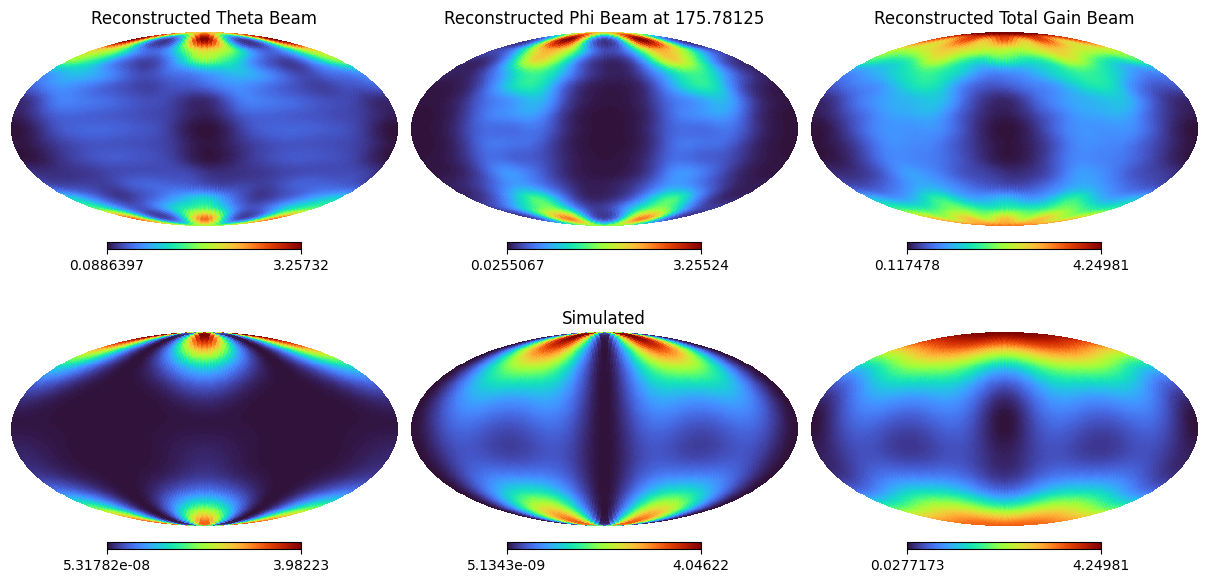

In [24]:
freq_num = freqs[chs][test_ch]
beam_diff(th_final, ph_final, freq=freq_num, comp=False)

5.31782e-08 3.9822313793103445 5.1342999999999995e-09 4.046224814814814


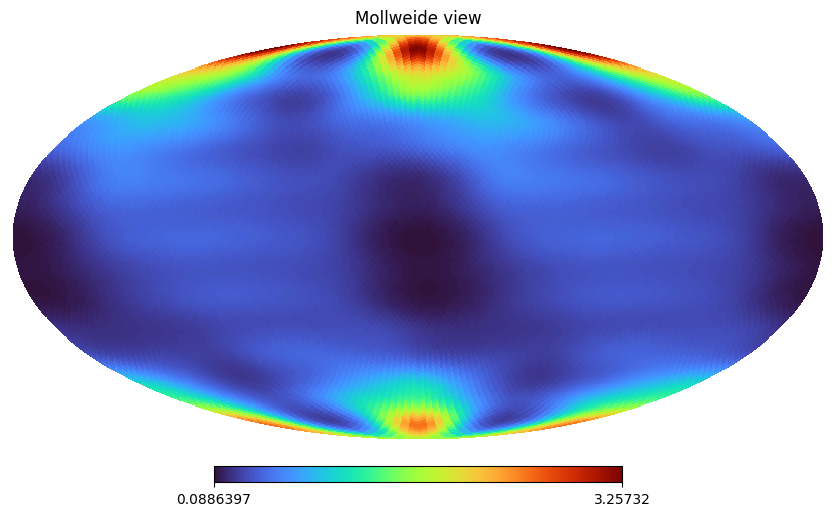

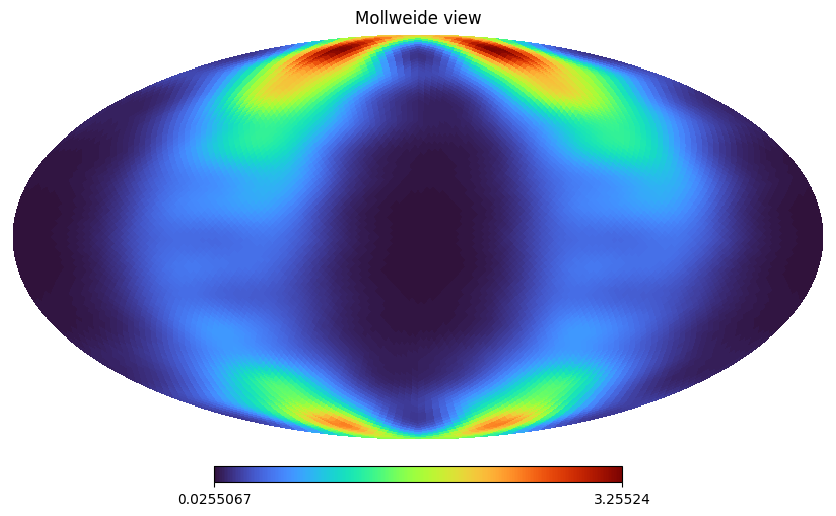

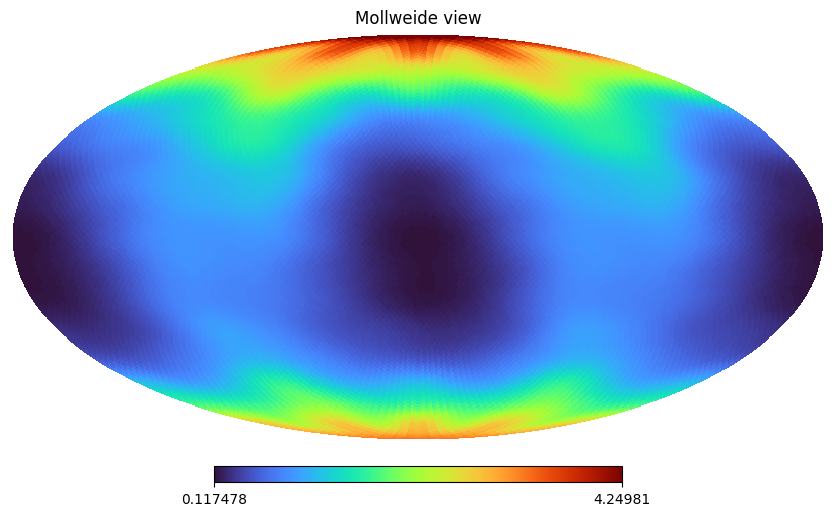

In [82]:
# rec_th = constrain(params)[0]
# rec_ph = constrain(params)[1]
# rec_th = (params)[0]
# rec_ph = (params)[1]
# rec_tot = rec_th + rec_ph
rec_tot = th_final + ph_final
print(TH_MIN_TRUE,
      TH_MAX_TRUE,
      PH_MIN_TRUE,
      PH_MAX_TRUE)


# beam_proj(used_pix, rec_th, vmin=None, vmax=None)
# beam_proj(used_pix, rec_ph, vmin=None, vmax=None)
# beam_proj(used_pix, rec_tot, vmin=None, vmax=None)
# beam_proj(used_pix, th_final, vmin=None, vmax=None)
# beam_proj(used_pix, ph_final, vmin=None, vmax=None)
# beam_proj(used_pix, rec_tot, vmin=None, vmax=None)
healpy.mollview(th_final, cmap='turbo')
healpy.mollview(ph_final, cmap='turbo')
healpy.mollview(ph_final + th_final, cmap='turbo')

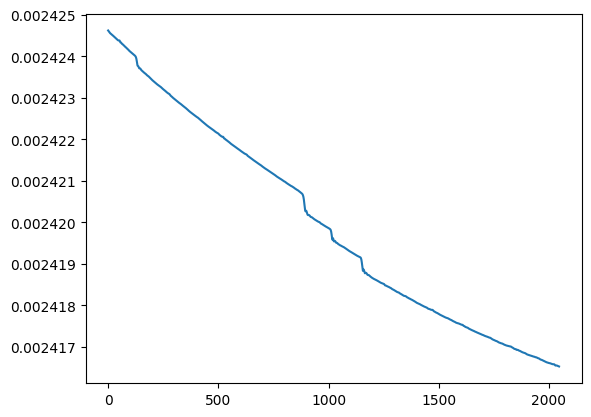

In [23]:
plt.figure()
plt.plot(loss_arr[-2048:-1])
# plt.plot(loss_arr)
plt.show()

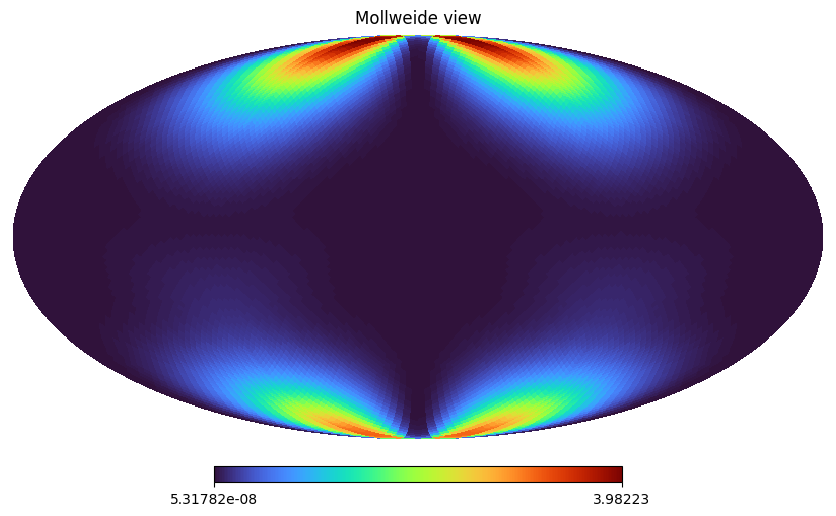

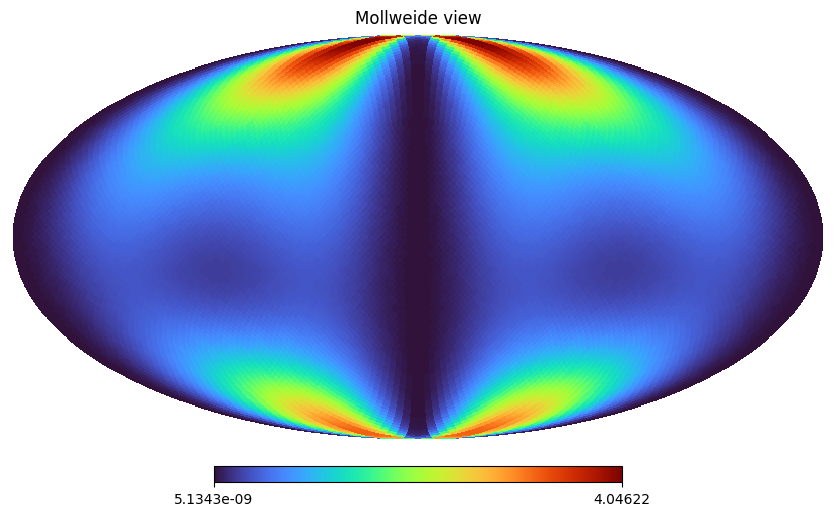

In [194]:
test_ch = 44
m_th = beam_maps_th[test_ch-13]
m_phi = beam_maps_ph[test_ch-13]

healpy.mollview(m_th, rot=(90, 0, 0), cmap='turbo')
healpy.mollview(m_phi, rot=(0, 0, 0), cmap='turbo')

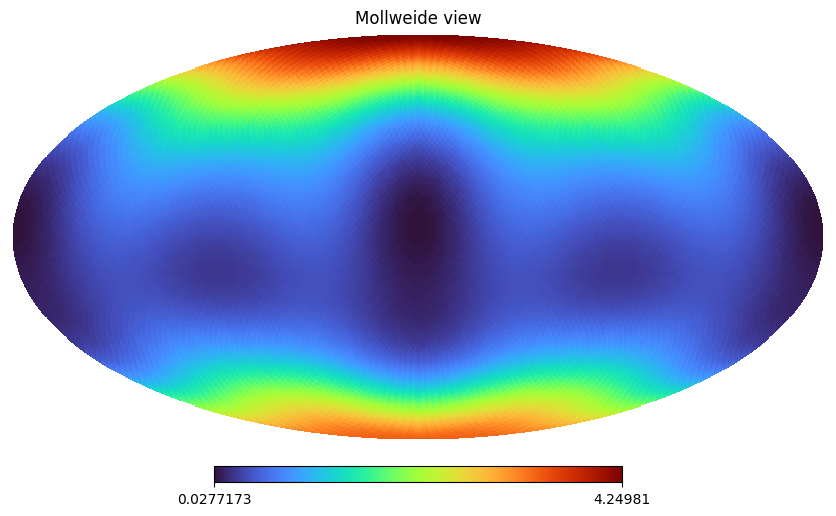

In [25]:
healpy.mollview(m_th + m_phi, cmap='turbo')

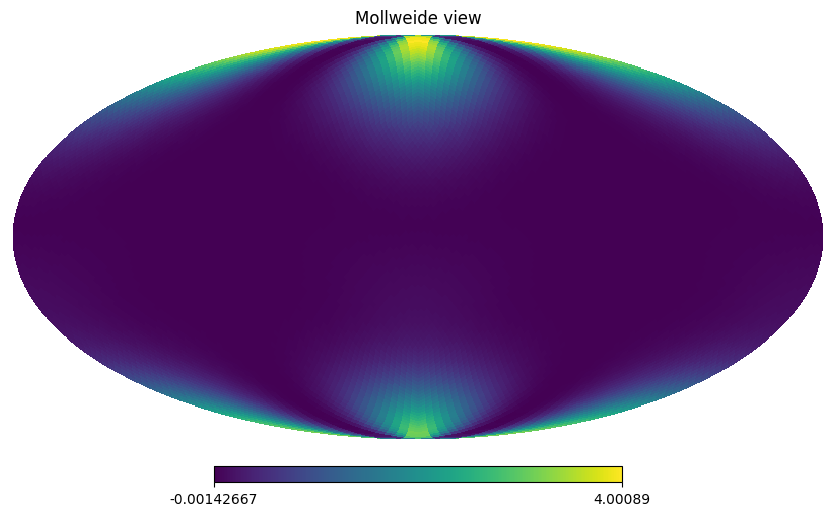

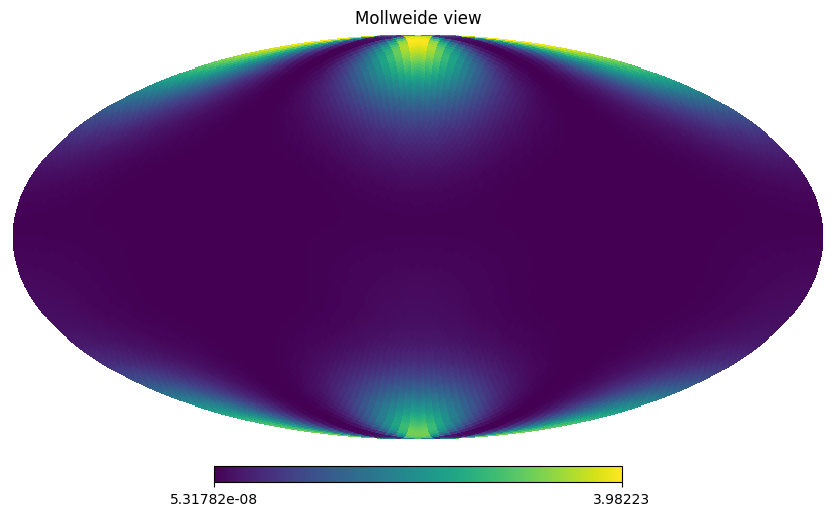

In [88]:
lmax = 3*DEFAULT_NSIDE - 1
alm_test = healpy.map2alm(m_th, lmax=lmax)

rec_alm = healpy.alm2map(alm_test, nside=DEFAULT_NSIDE, lmax=lmax)
healpy.mollview(rec_alm)
healpy.mollview(m_th)

-0.07133353825115503


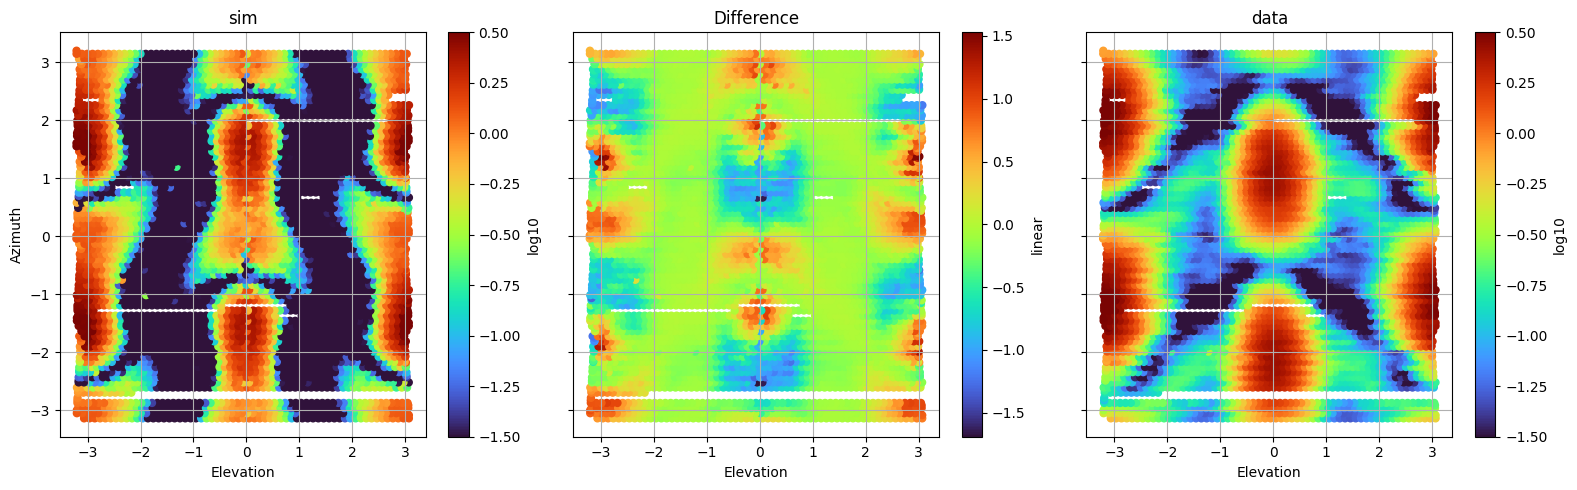

In [85]:

rec_th = jnp.full_like(m_th, healpy.UNSEEN)
rec_th = rec_th.at[hit_pxs].set(constrain(params)[0])
rec_ph = jnp.full_like(m_th, healpy.UNSEEN)
rec_ph = rec_ph.at[hit_pxs].set(constrain(params)[1])

rx_true = RotatingAntenna(beam_th=rec_th, beam_phi=rec_ph)

test_alpha = best_alphas[test_ch-13] + 0
test_delta = best_deltas[test_ch-13] + 0
# tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=alpha_angle[jnp.argmin(ress)])
# txe1 = jnp.sin(jnp.deg2rad(best_alphas[test_ch-13]))**2
# txe2 = jnp.cos(jnp.deg2rad(best_alphas[test_ch-13]))**2
txe1 = jnp.sin(jnp.deg2rad(test_alpha))**2
txe2 = jnp.cos(jnp.deg2rad(test_alpha))**2
tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=coord, alpha=-32)
# sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(70), K=1.0, C0=0.0)
sim_p_rot, hit_pxs = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=jnp.deg2rad(test_delta), K=1.0, C0=0.0)

test_data = rot * norm[:, test_ch]

sim_norm_rot = 1 / jnp.mean(sim_p_rot, axis=0)
sim_data = sim_p_rot * sim_norm_rot
scale_factor = jnp.sum(test_data * sim_data) / jnp.sum(sim_data**2)


vmin = -1.5
# vmin = -7
# vmax = 1
vmax = .5
# data_comp_norm = data_comp * norm[:,ch]
# data_comp_norm = data_comp * sim_norm_rot
# sim_data = sim_p * sim_norm # - .5+0.08329490672191896
diff = (sim_data*scale_factor) - (test_data)
print(jnp.median(diff))
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

sc1 = axes[0].scatter(el_inds, az_inds, c=jnp.log10(sim_data*scale_factor), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[0].set_title('sim')
axes[0].set_xlabel('Elevation'); axes[0].set_ylabel('Azimuth'); axes[0].grid(True)
fig.colorbar(sc1, ax=axes[0], label='log10')

sc2 = axes[1].scatter(el_inds, az_inds, c=diff, s=25, cmap='turbo')#, vmin=-0.02, vmax=0.02)#, vmin=vmin, vmax=vmax)
axes[1].set_title('Difference')
axes[1].set_xlabel('Elevation'); axes[1].grid(True)
fig.colorbar(sc2, ax=axes[1], label='linear')

sc3 = axes[2].scatter(el_inds, az_inds, c=jnp.log10(test_data), s=25, cmap='turbo', vmin=vmin, vmax=vmax)
axes[2].set_title('data')
axes[2].set_xlabel('Elevation'); axes[2].grid(True)
fig.colorbar(sc3, ax=axes[2], label='log10')

plt.tight_layout()

In [129]:
# XXX trying stuff
# --- helpers to invert your bounded maps ---
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

    
def bounded(x, lo, hi):
    return lo + (hi - lo) * jnn.sigmoid(x)

# def constrain(params_raw):
#     alpha_raw, delta_raw, th_raw, ph_raw = params_raw
#     # eps = 1e-6
#     alpha = bounded(alpha_raw, 0, 2*jnp.pi)
#     delta = bounded(delta_raw, 0, 2*jnp.pi)

#     # Nonnegative px arrays (softplus)
#     # th_px = jnn.softplus(th_raw) + eps
#     # ph_px = jnn.softplus(ph_raw) + eps
#     th_px = bounded(th_raw, 0, 4)
#     ph_px = bounded(ph_raw, 0, 4.1)
#     return alpha, delta, th_px, ph_px

def make_bounds_from_maps(th_seed, ph_seed, pad=0.05, eps=1e-8):
    s = th_seed + ph_seed
    L_th = float(max(eps, th_seed.min() * (1 - pad)))
    U_th = float(th_seed.max() * (1 + pad))
    L_ph = float(max(eps, ph_seed.min() * (1 - pad)))
    U_ph = float(ph_seed.max() * (1 + pad))
    Smin = float(max(eps, s.min() * (1 - pad)))
    Smax = float(s.max() * (1 + pad))
    return L_th, U_th, L_ph, U_ph, Smin, Smax

def constrain(params_raw,
              L_th=jnp.min(m_th), U_th=jnp.max(m_th),    # lower/upper bounds for th_px
              L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),    # lower/upper bounds for ph_px
              Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi),    # bounds for per-pixel sum th_px + ph_px
              eps=1e-8):
# def constrain(params_raw,
#                 L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                 Smin=0.027, Smax=4.25, eps=1e-8):
    """
    All bounds can be scalars or arrays broadcastable to (num_hit_pixels,).
    Returns alpha, delta, th_px, ph_px with ALL constraints satisfied.
    """
    alpha_raw, delta_raw, u_raw, mix_raw = params_raw

    # angles (example: radians; change to degrees if your simulator expects them)
    alpha = bounded(alpha_raw, 0.0, 2*jnp.pi)
    delta = bounded(delta_raw, 0.0, 2*jnp.pi)

    # capacities beyond lower bounds
    c_th = U_th - L_th               # >= 0
    c_ph = U_ph - L_ph               # >= 0

    # feasible extra-sum range beyond lower bounds
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    # (If u_max < u_min anywhere, your constraints are inconsistent there.)

    # choose u in [u_min, u_max]
    u = bounded(u_raw, u_min, u_max)

    # for this u, s must live in [s_lo, s_hi] to honor individual uppers:
    #   th = L_th + u*s <= U_th  -> s <= c_th / u
    #   ph = L_ph + u*(1-s) <= U_ph -> s >= 1 - c_ph / u  -> s >= (u - c_ph)/u
    s_lo = jnp.where(u > eps, jnp.maximum(0.0, (u - c_ph) / (u + eps)), 0.0)
    s_hi = jnp.where(u > eps, jnp.minimum(1.0,  c_th      / (u + eps)), 1.0)
    s_rng = jnp.maximum(0.0, s_hi - s_lo)  # 0 if we're exactly capacity-limited

    # pick s inside that feasible interval
    s_unit = jnn.sigmoid(mix_raw)          # in (0,1)
    s = s_lo + s_rng * s_unit              # in [s_lo, s_hi]

    # split u
    th_px = L_th + u * s
    ph_px = L_ph + u * (1.0 - s)
    # Now:  th_px ∈ [L_th, U_th], ph_px ∈ [L_ph, U_ph], and (th_px+ph_px) ∈ [Smin, Smax]
    return alpha, delta, th_px, ph_px

def fit_affine(y, m, eps=1e-8):
    y = y.ravel(); m = m.ravel()
    ym, mm = jnp.mean(y), jnp.mean(m)
    yc, mc = y - ym, m - mm
    a = jnp.vdot(yc, mc) / (jnp.vdot(mc, mc) + eps)
    b = ym - a * mm
    return a.real, b.real

# def loss_fnc(params):
#     m = model(params)
#     a, b = fit_affine(rot, m)
#     resid = rot - (a*m + b)
#     return jnp.mean(resid**2) / (jnp.var(rot) + 1e-12)   # NRMSE^2
# def loss_fnc(params):
#     m = model(params)
#     a, b = fit_affine(sim_p_rot, m)
#     resid = sim_p_rot - (a*m + b)
#     return jnp.mean(resid**2) / (jnp.var(sim_p_rot) + 1e-12)   # NRMSE^2


def model(params, alpha, delta):
    th_px, ph_px = constrain(params)
    
    th_map = jnp.full_like(m_th , healpy.UNSEEN) 
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN)
    th_map = th_map.at[used_pix].set(th_px)
    ph_map = ph_map.at[used_pix].set(ph_px)
    
    txe1 = jnp.sin(alpha)**2
    txe2 = jnp.cos(alpha)**2
    
    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=[0,0,-1])
    sim_p, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=(delta), K=1.0, C0=0.0)
    return sim_p

def loss_fnc(params):
    # alpha, delta, th_px, ph_px = params
    y = model(params)
    norm = 1/jnp.mean(y, axis=None)
    y_norm = y*norm
    return jnp.mean((sim_p_rot*(1/jnp.mean(sim_p_rot, axis=None)) - y_norm)**2)
    # y = model(params)
    # norm = 1/jnp.mean(y, axis=None)
    # y_norm = y*norm
    # return jnp.mean((rot*(1/jnp.mean(rot, axis=None)) - y_norm)**2)
    # return jnp.mean((jnp.log10(rot) - jnp.log10(y))**2)
# XXX adding crazy stuff

# --- init raw params from your current px (same tuple structure everywhere) ---
def inv_sigmoid(y):
    y = jnp.clip(y, 1e-6, 1-1e-6)
    return jnp.log(y) - jnp.log1p(-y)

# def init_params_from_px(alpha0, delta0, th0, ph0,
#                         L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                         Smin=0.027, Smax=4.25, eps=1e-8):
def init_params_from_px(alpha0, delta0, th0, ph0,
                        L_th=jnp.min(m_th), U_th=jnp.max(m_th), L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),
                        Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi), eps=1e-8):
    c_th, c_ph = U_th - L_th, U_ph - L_ph
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    u0 = jnp.clip(th0 + ph0 - (L_th + L_ph), u_min, u_max)
    s0 = jnp.where(u0 > eps, (th0 - L_th) / (u0 + eps), 0.5)
    s_lo0 = jnp.where(u0 > eps, jnp.maximum(0.0, (u0 - c_ph)/(u0 + eps)), 0.0)
    s_hi0 = jnp.where(u0 > eps, jnp.minimum(1.0,    c_th/(u0 + eps)), 1.0)
    s0 = jnp.clip(s0, s_lo0, s_hi0)
    u_unit  = (u0 - u_min) / (u_max - u_min + eps)
    s_unit  = jnp.where((s_hi0 - s_lo0) > eps, (s0 - s_lo0)/(s_hi0 - s_lo0 + eps), 0.5)
    u_raw   = inv_sigmoid(u_unit).astype(jnp.float32)
    mix_raw = inv_sigmoid(s_unit).astype(jnp.float32)
    alpha_raw = inv_sigmoid(((alpha0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    delta_raw = inv_sigmoid(((delta0 % (2*jnp.pi)) / (2*jnp.pi))).astype(jnp.float32)
    return (alpha_raw, delta_raw, u_raw, mix_raw)  # TUPLE, keep it a tuple.

# --- params & one optimizer (multi_transform) ---
# alpha0 = jnp.array(jnp.pi/2, dtype=jnp.float32)
# alpha0 = jnp.array(0.8349674, dtype=jnp.float32)
alpha0 = jnp.array(0.0, dtype=jnp.float32)
delta0 = jnp.array(0.0, dtype=jnp.float32)
# th0 = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
th0 = jnp.zeros_like(used_pix, dtype=jnp.float32) * 3
ph0 = jnp.zeros_like(used_pix, dtype=jnp.float32) * 3

# L_th, U_th, L_ph, U_ph, Smin, Smax = make_bounds_from_maps(m_th, m_phi, pad=0.0)

# init raws from seeds using THESE bounds
# params = init_params_from_px(
#     alpha0=alpha0, delta0=delta0, th0=th0, ph0=ph0,
#     L_th=L_th, U_th=U_th, L_ph=L_ph, U_ph=U_ph, Smin=Smin, Smax=Smax
# )

params = init_params_from_px(alpha0, delta0, th0, ph0)

tx = optax.multi_transform(
    {
      "angles": optax.chain(optax.clip_by_global_norm(0.5), optax.adam(1e-4)),
      "px":     optax.chain(optax.clip_by_global_norm(0.5), optax.adam(1e0)),
    },
    # labels PyTree MUST match params structure:
    param_labels=("angles","angles","px","px"),
)
opt_state = tx.init(params)  # <-- init AFTER defining tx, and only once

# --- px-only step (angles frozen), uses the SAME tx/opt_state ---
@jax.jit
def train_step_px_only(p, s):
    a_raw, d_raw, u_raw, m_raw = p
    def loss_ud(u, m):
        return loss_fnc((a_raw, d_raw, u, m))
    loss, (g_u, g_m) = jax.value_and_grad(loss_ud, argnums=(0,1))(u_raw, m_raw)
    grads = (jnp.zeros_like(a_raw), jnp.zeros_like(d_raw), g_u, g_m)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    # re-pin angles exactly:
    p = (a_raw, d_raw, p[2], p[3])
    return p, s, loss

# --- joint step (same tx) ---
@jax.jit
def train_step_joint(p, s):
    loss, grads = jax.value_and_grad(loss_fnc)(p)
    updates, s = tx.update(grads, s, p)
    p = optax.apply_updates(p, updates)
    return p, s, loss

# ---------- run ----------
# (optional) a few px-only warmup steps
for _ in range(2000):
    params, opt_state, loss = train_step_px_only(params, opt_state)
    if _ % 100 ==0:
        print(loss)

# joint fine-tune
# for step in range(1000):
#     params, opt_state, loss = train_step_joint(params, opt_state)
#     if step % 100 == 0:
#         print(f"joint step {step:04d}  loss={float(loss):.6e}")

# alpha, delta, th_px, ph_px = params
# XXX adding crazy stuff


# @jax.jit
# def train_step(params, opt_state):
#     loss, grads = jax.value_and_grad(loss_fnc)(params)
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     params = optax.apply_updates(params, updates)
#     return params, opt_state, loss


# alpha0 = 0.0
# delta0 = 0.0
# th0 = jnp.asarray(m_th[used_pix],  dtype=jnp.float64)
# ph0 = jnp.asarray(m_phi[used_pix], dtype=jnp.float64)

# params = init_params_from_px(alpha0, delta0, th0, ph0)  # <-- raw params consistent with constrain()
# optimizer = optax.adam(1e-3)  # suggest 1e-3 here; 1e-1 often too hot with sigmoids
# opt_state = optimizer.init(params)



# # learning_rate = 1e-1
# # optimizer = optax.adam(learning_rate)

# # alpha = 0.0
# # delta = 0.0
# # th_px = jnp.asarray(m_th[used_pix], dtype=jnp.float32)
# # ph_px = jnp.asarray(m_phi[used_pix], dtype=jnp.float32)
# # # th_px = jnp.ones_like(used_pix, dtype=jnp.float32)
# # # ph_px = jnp.ones_like(used_pix, dtype=jnp.float32)
# # params = [alpha, delta, th_px, ph_px]
# # opt_state = optimizer.init(params)

# for epoch in range(10000):
#     params, opt_state, loss = train_step(params, opt_state)
#     if epoch % 1000 == 0:
#         print(f"epoch {epoch:02d}  loss={loss:.6f}")
        

alpha, delta, th_px, ph_px = constrain(params)
print(alpha, delta)

2.573249561918575
0.18221636167316949
0.1618345550479783
0.16331489363416896
0.16190649762999162
0.16052437413784287
0.16000575373919534
0.16630205117099484
0.16427703797942075
0.16751848053047383
0.1673331216271002
0.16344762150885508
0.16313588988601668
0.16294211715422086
0.16281636542269026
0.1629480145740147
0.16281028389799793
0.16311273866116185
0.16221566193432796
0.16229405197705754
6.283184e-06 6.283184e-06


In [ ]:
def model(params, alpha, delta):
    th_px, ph_px = constrain(params)
    
    th_map = jnp.full_like(m_th , healpy.UNSEEN) 
    ph_map = jnp.full_like(m_phi, healpy.UNSEEN)
    th_map = th_map.at[used_pix].set(th_px)
    ph_map = ph_map.at[used_pix].set(ph_px)
    
    txe1 = jnp.sin(alpha)**2
    txe2 = jnp.cos(alpha)**2
    
    rx_true = RotatingAntenna(beam_th=th_map, beam_phi=ph_map)
    tx_true = TransmitterAntenna(E1=txe1, E2=txe2, heading_top=[0,0,-1])
    sim_p, _ = simulate_powers_vmap_phase(rx=rx_true, tx=tx_true, az=az_inds, el=el_inds, E1=txe1, E2=txe2, delta_rx=(delta), K=1.0, C0=0.0)
    return sim_p

def loss_fnc(params):
    # alpha, delta, th_px, ph_px = params
    y = model(params)
    norm = 1/jnp.mean(y, axis=None)
    y_norm = y*norm
    return jnp.mean((sim_p_rot*(1/jnp.mean(sim_p_rot, axis=None)) - y_norm)**2)
    # y = model(params)
    # norm = 1/jnp.mean(y, axis=None)
    # y_norm = y*norm
    # return jnp.mean((rot*(1/jnp.mean(rot, axis=None)) - y_norm)**2)
    # return jnp.mean((jnp.log10(rot) - jnp.log10(y))**2)

def bounded(x, lo, hi):
    return lo + (hi - lo) * jnn.sigmoid(x)

# def constrain(params_raw):
#     alpha_raw, delta_raw, th_raw, ph_raw = params_raw
#     # eps = 1e-6
#     alpha = bounded(alpha_raw, 0, 2*jnp.pi)
#     delta = bounded(delta_raw, 0, 2*jnp.pi)

#     # Nonnegative px arrays (softplus)
#     # th_px = jnn.softplus(th_raw) + eps
#     # ph_px = jnn.softplus(ph_raw) + eps
#     th_px = bounded(th_raw, 0, 4)
#     ph_px = bounded(ph_raw, 0, 4.1)
#     return alpha, delta, th_px, ph_px

def make_bounds_from_maps(th_seed, ph_seed, pad=0.05, eps=1e-8):
    s = th_seed + ph_seed
    L_th = float(max(eps, th_seed.min() * (1 - pad)))
    U_th = float(th_seed.max() * (1 + pad))
    L_ph = float(max(eps, ph_seed.min() * (1 - pad)))
    U_ph = float(ph_seed.max() * (1 + pad))
    Smin = float(max(eps, s.min() * (1 - pad)))
    Smax = float(s.max() * (1 + pad))
    return L_th, U_th, L_ph, U_ph, Smin, Smax

def constrain(params_raw,
              L_th=jnp.min(m_th), U_th=jnp.max(m_th),    # lower/upper bounds for th_px
              L_ph=jnp.min(m_phi), U_ph=jnp.max(m_phi),    # lower/upper bounds for ph_px
              Smin=jnp.min(m_th + m_phi), Smax=jnp.max(m_th + m_phi),    # bounds for per-pixel sum th_px + ph_px
              eps=1e-8):
# def constrain(params_raw,
#                 L_th=1e-8, U_th=4.0, L_ph=1e-9, U_ph=4.1,
#                 Smin=0.027, Smax=4.25, eps=1e-8):
    """
    All bounds can be scalars or arrays broadcastable to (num_hit_pixels,).
    Returns alpha, delta, th_px, ph_px with ALL constraints satisfied.
    """
    alpha_raw, delta_raw, u_raw, mix_raw = params_raw

    # angles (example: radians; change to degrees if your simulator expects them)
    alpha = bounded(alpha_raw, 0.0, 2*jnp.pi)
    delta = bounded(delta_raw, 0.0, 2*jnp.pi)

    # capacities beyond lower bounds
    c_th = U_th - L_th               # >= 0
    c_ph = U_ph - L_ph               # >= 0

    # feasible extra-sum range beyond lower bounds
    u_min = jnp.maximum(0.0, Smin - (L_th + L_ph))
    u_max = jnp.minimum(c_th + c_ph, Smax - (L_th + L_ph))
    # (If u_max < u_min anywhere, your constraints are inconsistent there.)

    # choose u in [u_min, u_max]
    u = bounded(u_raw, u_min, u_max)

    # for this u, s must live in [s_lo, s_hi] to honor individual uppers:
    #   th = L_th + u*s <= U_th  -> s <= c_th / u
    #   ph = L_ph + u*(1-s) <= U_ph -> s >= 1 - c_ph / u  -> s >= (u - c_ph)/u
    s_lo = jnp.where(u > eps, jnp.maximum(0.0, (u - c_ph) / (u + eps)), 0.0)
    s_hi = jnp.where(u > eps, jnp.minimum(1.0,  c_th      / (u + eps)), 1.0)
    s_rng = jnp.maximum(0.0, s_hi - s_lo)  # 0 if we're exactly capacity-limited

    # pick s inside that feasible interval
    s_unit = jnn.sigmoid(mix_raw)          # in (0,1)
    s = s_lo + s_rng * s_unit              # in [s_lo, s_hi]

    # split u
    th_px = L_th + u * s
    ph_px = L_ph + u * (1.0 - s)
    # Now:  th_px ∈ [L_th, U_th], ph_px ∈ [L_ph, U_ph], and (th_px+ph_px) ∈ [Smin, Smax]
    return alpha, delta, th_px, ph_px


In [396]:
best_alphas.shape

(51,)